In [1]:
# preprocess multiSim  and. analyze results

In [2]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import brian2
from collections import defaultdict
import pickle
import json
import copy
from matplotlib import colors

import itertools
from pathlib import Path

from ipynb.fs.defs.makeFigures import generateColorMap, generateColorbar

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
from plotFunc import plotXYcompr, plotXYcomprCorr, plotXYcomprResidual, plotXYLogReg

In [4]:
# load sim test
from circuitModelClust import circuitModelMultiArea

In [5]:
# load arealist
area_list = list(np.loadtxt('results/area_list.csv', delimiter=',', dtype='str'))
thal_list = list(np.loadtxt('results/thal_list.csv', delimiter=',', dtype='str'))
# load connectivity 
conn_cxcx = np.loadtxt('results/conn_cxcx.csv', delimiter=',')

conn_cxth = np.loadtxt('results/conn_cxth.csv', delimiter=',')
conn_thcx = np.loadtxt('results/conn_thcx.csv', delimiter=',')

# load interneuron density
normPVgrad_df = pd.read_csv('results/dfPV.csv', header = 0, index_col=0)
normSSTgrad_df = pd.read_csv('results/dfSST.csv', header = 0, index_col=0)

# load hierarchy
hierarchy_df = pd.read_csv('results/dfHier.csv', header=0, index_col=0)
hierlist = list(hierarchy_df['hierarchy index'])
# load model

loadFolder = 'tempdata/results22Jan27_3/'
testFolder = 'results/'
# with open(testFolder + 'allpars.pkl', 'rb') as f:
#     model = pickle.load(f)
    
with open(testFolder + 'allpars.pkl', 'rb') as file:  # open parameter file
    [parameters, conn_cxcx, pref_matrix,
     hierarchy_df, normPVgrad_df, normSSTgrad_df,
     area_list, conn_thcx, conn_cxth, thal_list] = pickle.load(file)    
    
with open('results/model_V1.pkl', 'rb') as f:
    model_V1 = pickle.load(f)    


In [6]:
def plotStimDelayInhibition(StimInhfrList, DelayInhfrList, categoryList, frListdefault, FRDefault, area_list, figureSize, fontSize, saveFig, fileName):
    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    
    stimEffect = 1 - StimInhfrList / FRDefault
    delayEffect = 1 - DelayInhfrList / FRDefault
    cList = []
    texts = []
    xPos = []
    yPos = []
    ax = plt.gca()
    for i in range(len(area_list)):
        if categoryList[i] == 'input':
            cList += ['#e41a1c'] # input
        elif categoryList[i] == 'core':
            cList += ['#377eb8'] # core
        elif categoryList[i] == 'readout':
            cList += ['#4daf4a'] # readout
        else:
            cList += ['#984ea3'] # exterior
        acr = area_list[i]
        x = stimEffect[i]
        y = delayEffect[i]
        if acr not in noLabelAreas:
            xPos += [x]
            yPos += [y]
            texts += [ax.text(x, y, acr, c='k',fontsize=fontSize*0.4)]

    plt.scatter(stimEffect, delayEffect, c=cList, alpha=0.5)

    adjust_text(texts, xPos, yPos,
                        ax=ax, precision=0.001,
                        arrowprops=dict(arrowstyle='-', color='gray', alpha=.8))
    
    plt.xlabel('Lesion effect(stim)')
    plt.ylabel('Lesion effect(delay)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
# save figure
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight',transparent=True)
    # plt.savefig('figure/neurondensity_grad.png',dpi=80,bbox_inc
    

In [7]:
# define divisions from Harris et al.
div = {'somatomotor':['SSp-bfd','SSp-tr','SSp-ll','SSp-ul',
                     'SSp-un','SSp-n','SSp-m','SSs','MOp','MOs'],
      'visual':['VISal','VISl','VISp','VISpl',
                'VISli','VISpor','VISrl'],
      'medial':['VISa','VISam','VISpm','RSPagl',
               'RSPd','RSPv'],
      'prefrontal':['FRP','ACAd','ACAv','PL',
                   'ILA','ORBl','ORBm','ORBvl'],
      'lateral':['AId','AIv','AIp','VISC',
                 'GU','TEa','PERI','ECT'],
      'auditory':['AUDd','AUDp','AUDpo','AUDv']}

div_color_list = np.array([[255, 140, 0],
                           [169, 164, 217],
                           [22, 37, 128],
                           [220,20,60],
                           [218,165,32],
                           [91,  0,  105]])/255
# div_color_list = {
#     'somatomotor':[255, 140, 0],
#       'visual':[169, 164, 217],
#       'medial':[22, 37, 128],
#       'prefrontal':[220,20,60],
#       'lateral':[218,165,32],
#       'auditory':[91,  0,  105]}

div_name_list = ['somatomotor',
                 'visual',
                 'medial',
                 'prefrontal',
                 'lateral',
                 'auditory']

In [8]:
#     with open(loadpath + 'allpars.pkl', 'rb') as file:  # open parameter file
#         [parameters, conn_cxcx, pref_matrix,
#          hierarchy_df, normPVgrad_df, normSSTgrad_df,
#          area_list, conn_thcx, conn_cxth, thal_list] = pickle.load(file)

In [9]:
# generate a list of stim pattern

# stimAreaList = ['PL','ORBm','VISpm','AId','ORBl','ILA','VISal','ECT','PERI','RSPagl','GU','RSPd','RSPv','VISpl','VISrl','MOp']
# stimAreaList = ['AIp', 'PL', 'ECT', 'ORBm', 'PERI', 'ILA', 'GU', 'TEa', 'RSPagl', 'AId', 'VISC', 'AUDv', 'VISpm', 'MOs', 'ORBvl', 'FRP', 'ACAd', 'VISam']
# stimAreaList = area_list

# old stimAreaList used for results22Jul15_0144 and results22Jul14_0244 series of simulation. 
# stimAreaList = ['AIp', 'PL', 'ORBm', 'ECT', 'ILA', 'AId', 'GU', 'PERI', 'VISC', 'AUDv', 
#                 'RSPagl', 'VISpm', 'FRP', 'TEa', 'VISal', 'ACAv', 'ORBvl', 'AUDpo'] 

# new stimAreaList. difference is to intro MOs VISam VISa ORBl into stimAreaList.
stimAreaList = ['AIp', 'PL', 'ORBm', 'ECT', 'ILA', 'AId', 'GU', 'PERI', 'VISC', 'AUDv', 
                'RSPagl', 'VISpm', 'FRP', 'TEa', 'MOs', 'VISam', 'VISa', 'ORBl']

# high loop and high-mid hierarchy['ACAv', 'ORBvl','TEa','AUDpo','FRP','PL','ORBm','VISpm','AId','ILA','VISal','ECT','PERI','RSPagl','GU']

# high mid hierarchy but mid-low loop   stimAreaList = ['AIv','ACAd','MOs','VISam','VISa','VISpor','ORBl']


nc = len(stimAreaList)
print(nc)

# HiersortDf = hierarchy_df.sort_values(by='hierarchy index', ascending=False)
# nc = 18 # number of areas considered, top No. of areas with small PV value.
# stimAreaList = list(HiersortDf.head(nc).index) # stimarealist
# print(stimAreaList)

stimPatternList = [] # stimpatternlist

for i in range(nc):
# for i in [0]:
    stimPatternList += itertools.combinations(stimAreaList, i + 1)

# for i in range(nc):
#     stimPatternList.append((stimAreaList[i],))

print(len(stimAreaList), len(stimPatternList))
print(stimPatternList[:10])

18
18 262143
[('AIp',), ('PL',), ('ORBm',), ('ECT',), ('ILA',), ('AId',), ('GU',), ('PERI',), ('VISC',), ('AUDv',)]


In [10]:
# save the list of stim pattern
# with open('results/stimPatternList.json', 'w') as f:
#     json.dump(stimPatternList, f)

In [141]:
# open the stim pattern list for following analysis

with open('results/stimPatternList.json','r') as f:
    stimPatternList = json.load(f)

# with open('results/stimPatternListOLD.json','r') as f:
#     stimPatternList = json.load(f)
    
npattern = len(stimPatternList)
print(npattern)
print(stimPatternList[:20])

nsize = 1000 # number of sims in each job.
npattern = len(stimPatternList)
njobs = int(npattern/nsize) + 1
print(npattern, njobs)

262143
[['AIp'], ['PL'], ['ORBm'], ['ECT'], ['ILA'], ['AId'], ['GU'], ['PERI'], ['VISC'], ['AUDv'], ['RSPagl'], ['VISpm'], ['FRP'], ['TEa'], ['MOs'], ['VISam'], ['VISa'], ['ORBl'], ['AIp', 'PL'], ['AIp', 'ORBm']]
262143 263


In [142]:
# load data and plot attractor firing rate.  single area receive stimulation. mm11
n_areas = len(area_list)
pamat = np.zeros((n_areas, npattern))
nsize = 1000
filepath = '.'
njobs = int(npattern/nsize) + 1
# folderName = 'results22Apr9_1'
folderName = 'results22AUG22_0444'  # 'results22AUG22_0344'
# for folderName results22Jul15_0?44 and results22Jul14_024? series of sims, we need to use stimPatternListOLD.
# for folderName results22AUG22_0?44 series of sims, we need to use stimPatternList.
fullFolderName = filepath + '/tempdata/' + folderName
for i in range(njobs):
    stimList = stimPatternList[i * nsize: (i + 1) * nsize]
    loadfilename = fullFolderName + '/att_' + str(i) + '_' + str(nsize) + '.txt'
    if Path(loadfilename).is_file():
        with open(loadfilename, 'r') as f:
            panew = json.load(f)
        pamat[:, i * nsize : (i + 1) * nsize] = np.array(panew).T
    else:
        print('error load file ' + loadfilename)
        

In [143]:
# have a peek at the firing rate pattern.
# plt.figure(figsize=(200,19))
# np.random.seed(925925)
# randComb = np.random.choice(np.arange(len(stimPatternList)), (200,))

# # for i in randComb:
# #     print(i, stimPatternList[i]) 
# plt.imshow(pamat[:, randComb])
# plt.colorbar()
# plt.ylabel('Area delay firing')
# plt.xlabel('Area receiving stim')
# # plt.xticks(np.arange(len(stimPatternList)),stimPatternList,rotation=90,fontname='Georgia',fontsize=7)
# plt.yticks(np.arange(n_areas),area_list,fontname='Georgia',fontsize=7)
# plt.grid(False)

In [144]:
def getAttractors(pamat, thresholdDif):
    attractmat = []
    stimDict = defaultdict(list)

    for i in range(pamat.shape[1])[::-1]:
        panew = pamat[:, i]
    #     print(panew)
        n_attract = len(attractmat)
        YNnewattract =[False for k in range(n_attract)]
        if n_attract == 0:
            attractmat.append(panew)
            continue
        for j in range(n_attract):
            if np.linalg.norm(attractmat[j] - panew) > thresholdDif:
                YNnewattract[j] = True
            else:
                stimDict[j].append(i)
        if all(YNnewattract) == True:
            attractmat.append(panew)
    n_attract = len(attractmat)
    attractmat = np.array(attractmat)
    return attractmat, n_attract, stimDict

In [145]:
def getAttractorsBinary(pamat, threshold):
    attractmat = []
    binaryPamat = pamat > threshold    
    attSet = set()
    stimDict = defaultdict(list)

    for i in range(binaryPamat.shape[1])[::-1]:
        panew = pamat[:, i]
        binarypanew = binaryPamat[:, i]
    #     print(panew)
        n_attract = len(attractmat)
        if n_attract == 0:
            attractmat.append(panew)
            attSet.add(tuple(binarypanew))
            continue
        else:
            if tuple(binarypanew) not in attSet:
                attractmat.append(panew)
                attSet.add(tuple(binarypanew))
    n_attract = len(attractmat)
    attractmat = np.array(attractmat)
    return attractmat, n_attract, stimDict


In [146]:
# count all the attractors. mm22
attractmat, n_attract, stimDict = getAttractorsBinary(pamat, 5) # use binary pamat to get attractors


In [147]:
def getColorList(area_list, hierlist, N, div, div_name_list, div_color_list):
    colorList = []
    sortArea = [area_list[x] for x in np.argsort(hierlist)[::-1][:N]]
    for areaName in sortArea:
        for i in range(6):
            if areaName in div[div_name_list[i]]:
                colorList.append(div_color_list[i])
    return colorList

In [148]:
def plotDistribution(attractmat, threshold, hierarchy_df, area_list, topN, figSize, fontSize, saveFig, fileName):
    fig = plt.figure(figsize=figSize, dpi=300, facecolor='w', edgecolor='k')
    fig.add_subplot(121)
    plt.rcParams.update({'font.size': fontSize})

    hierlist = list(hierarchy_df['hierarchy index'])
    nAtt = attractmat.shape[0]
    n_areas = len(area_list)
    countFR = np.zeros(n_areas)
    countAreas = np.zeros(n_areas)

    for i in range(attractmat.shape[0]):
        curFR = attractmat[i, :]
#         print(curFR > threshold, countFR)
        countFR += curFR > threshold
#         print(countFR)
        curnArea = sum(curFR > threshold) # current nArea
        countAreas[curnArea] += 1
    xData = range(n_areas)[:topN]
    indexSort = np.argsort(hierarchy_df['hierarchy index'])
    colorList = getColorList(area_list, hierlist, topN, div, div_name_list, div_color_list)
    print(colorList)
    plt.bar(xData, [countFR[x]/nAtt for x in np.argsort(hierlist)[::-1]][:topN][::-1], color=colorList[::-1])
    plt.ylabel('attractor fraction')
    plt.xticks(xData, [area_list[x] for x in np.argsort(hierlist)[::-1]][:topN][::-1], rotation=90, fontsize=fontSize*0.6)
    ax = plt.gca()
#     for t in ax.xaxis.get_ticklabels():
#         label = t._text
#         for i in range(6):
#             if label in div[div_name_list[i]]:
#                 t.set_color(div_color_list[i])
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    fig.add_subplot(122)
    plt.bar(xData, countAreas[0:topN])
    plt.xlabel('Size of attractors')
    plt.ylabel('# attractors')
    
    
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)
    return countAreas, countFR

[array([0.85490196, 0.64705882, 0.1254902 ]), array([0.8627451 , 0.07843137, 0.23529412]), array([0.8627451 , 0.07843137, 0.23529412]), array([0.8627451 , 0.07843137, 0.23529412]), array([1.        , 0.54901961, 0.        ]), array([0.08627451, 0.14509804, 0.50196078]), array([0.08627451, 0.14509804, 0.50196078]), array([0.85490196, 0.64705882, 0.1254902 ]), array([0.35686275, 0.        , 0.41176471]), array([0.8627451 , 0.07843137, 0.23529412]), array([0.6627451 , 0.64313725, 0.85098039]), array([0.8627451 , 0.07843137, 0.23529412]), array([0.8627451 , 0.07843137, 0.23529412]), array([0.08627451, 0.14509804, 0.50196078]), array([0.85490196, 0.64705882, 0.1254902 ]), array([0.8627451 , 0.07843137, 0.23529412]), array([0.8627451 , 0.07843137, 0.23529412]), array([0.6627451 , 0.64313725, 0.85098039]), array([0.85490196, 0.64705882, 0.1254902 ]), array([0.85490196, 0.64705882, 0.1254902 ]), array([0.08627451, 0.14509804, 0.50196078]), array([0.85490196, 0.64705882, 0.1254902 ]), array([0.

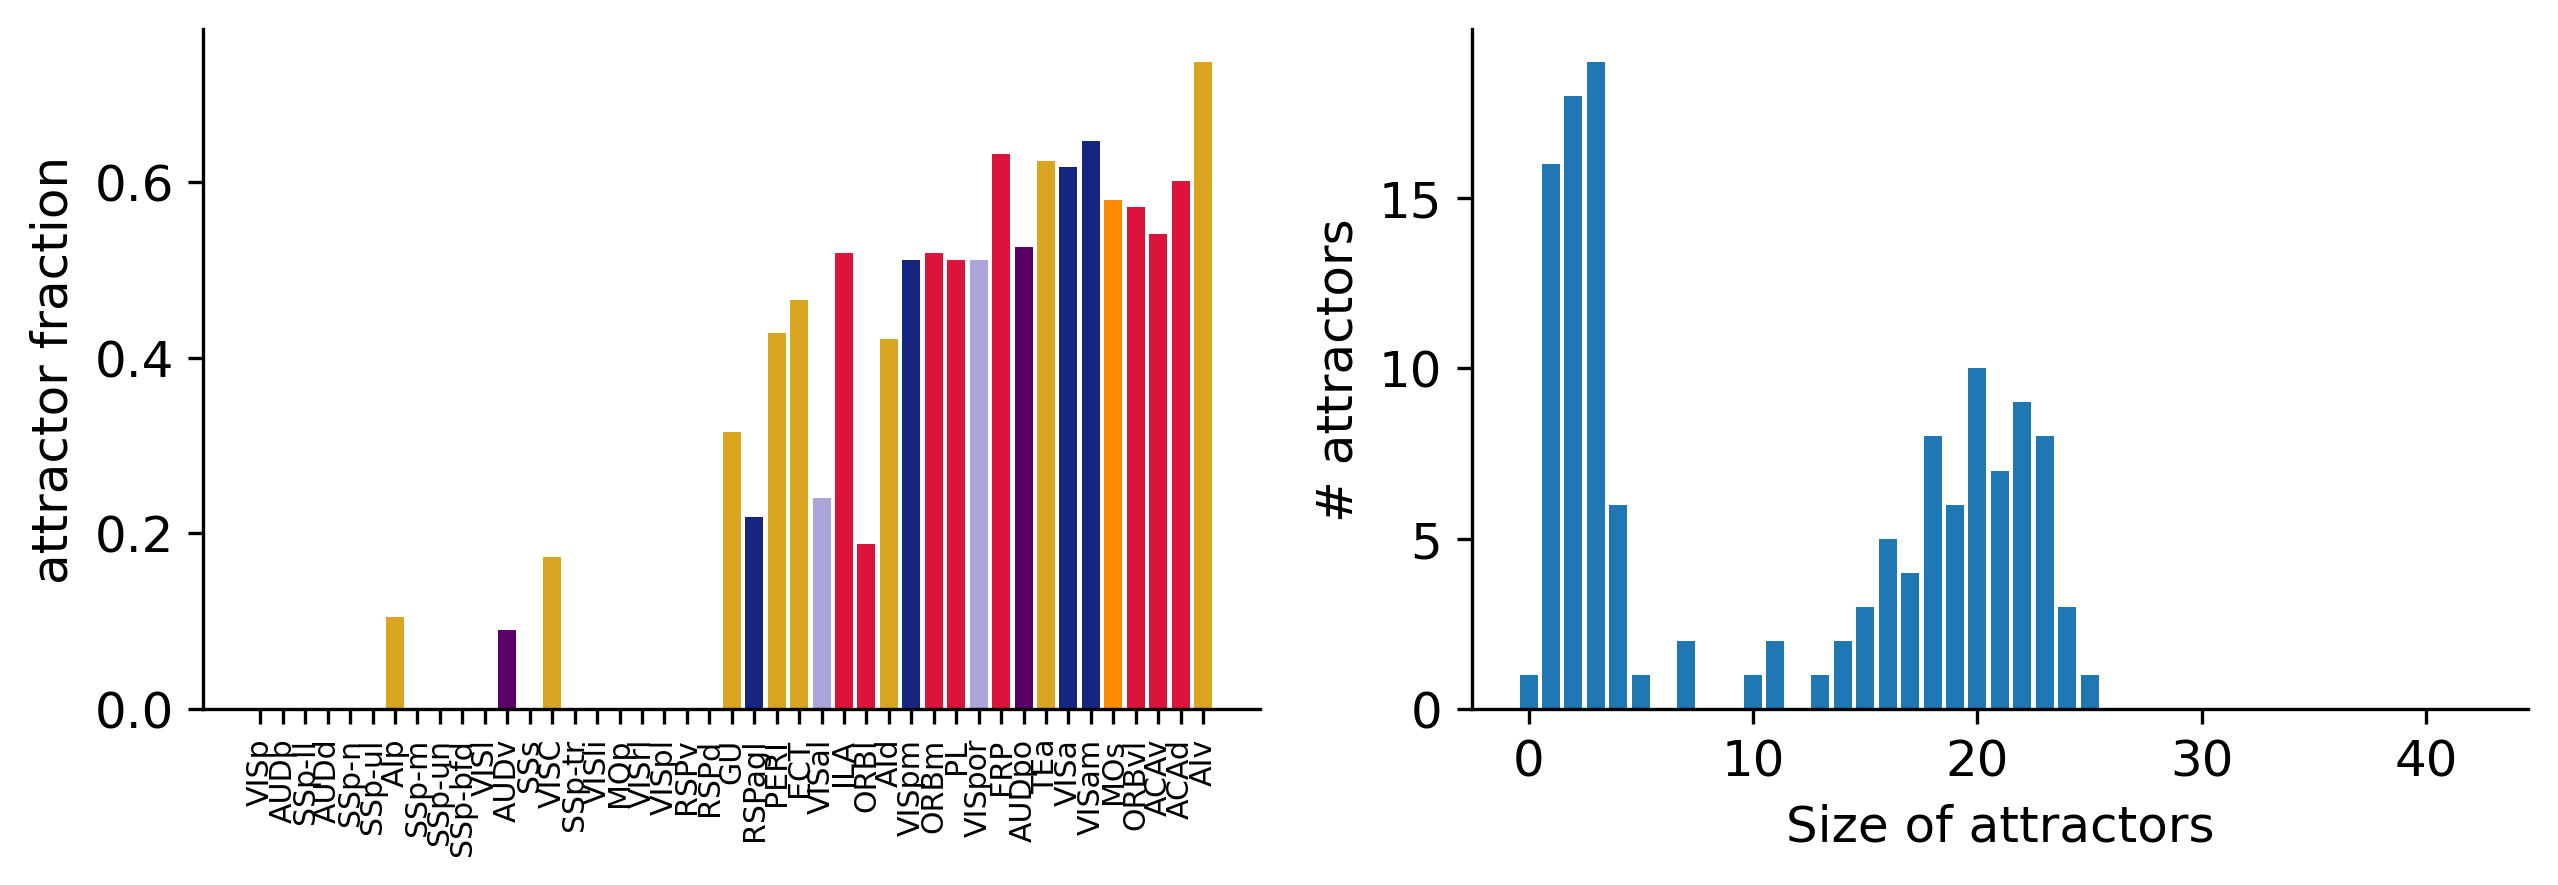

In [149]:
# analyze the attractor details. 
threshold = 5
countAreas, countFR = plotDistribution(attractmat, threshold, hierarchy_df, area_list, 43, (10,3),
                                       12, True, 'processMulti/'+ folderName + '_attDistribution.svg')
print('processMulti/'+ folderName + '_attDistribution.svg')

In [ ]:
# the following analysis is reimplemented in singleAreaLesion

In [98]:

# # show the effect of inhibiting any single area.
# a = [list(pamat[k,:]) for k in np.argsort(hierlist)[::-1][:43]]
# arr = np.array(a)
# plt.imshow(a)


stimAreaList = ['AIv','ACAd','ACAv','ORBvl','MOs','VISam','VISa','TEa','AUDpo','FRP','VISpor','PL','ORBm','VISpm','AId','ORBl','ILA','VISal','ECT','PERI','RSPagl','GU']


In [78]:
# quantify inhibiting any area => average FR change and # area change.
countAreaAIv = 0
frInhibitArea = np.zeros(len(stimAreaList))
print(frInhibitArea, len(frInhibitArea))

for i in range(len(stimPatternList)):
# for i in range(len(stimAreaList)): 
    sortedPamat = np.array([list(pamat[k, :]) for k in np.argsort(hierlist)[::-1][:43]])
    
    stimP = stimPatternList[i]
    nAreaStim = len(stimP)
    if nAreaStim > 2:
        continue
    pa = sortedPamat[:, i]
    fr = np.sum(pa[:22])/(22 - nAreaStim)
    
    for i in range(nAreaStim):
        indexStimArea = stimAreaList.index(stimP[i])
        if stimP[i] == 'AIv':
            countAreaAIv += 1
        frInhibitArea[indexStimArea] += fr
frInhibitArea /= countAreaAIv
frInhibitArea

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 22


ValueError: 'AIp' is not in list

In [302]:
paRaw = model_V1.persistentact_df.sort_values(by=['Hierarchy'], ascending=False)['persistentact']

Text(0, 0.5, 'average firing rate of inhibiting an area')

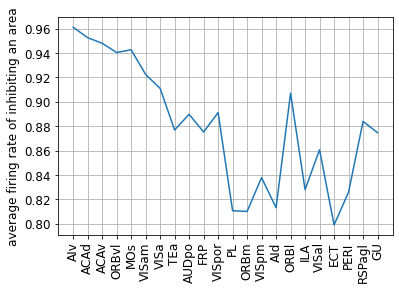

In [304]:
# plt.plot(frInhibitArea)
plt.plot(frInhibitArea / np.mean(paRaw[:22]))
plt.xticks(range(len(stimAreaList)), stimAreaList, rotation=90)
plt.grid('on')
plt.ylabel('average firing rate of inhibiting an area')

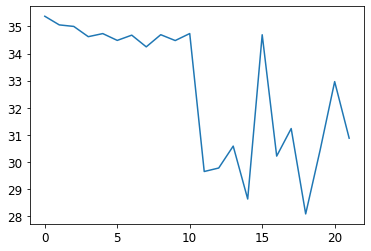

In [280]:
plt.plot(frList[:22])
# countFR

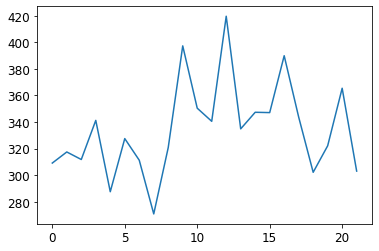

In [126]:
# plt.plot(loop_Hiermod)
z  = np.array(hierarchy_df).squeeze()
np.argsort(z)
plt.figure()
l = [loop_Hiermod[k] for k in np.argsort(z)]
plt.plot(l[0:22])

In [34]:
noLabelAreas=[]

# open the stim pattern list for following analysis
with open('results/hierLoopStr.json','r') as f:
    loop_Hiermod = json.load(f)
with open('results/hierEigCent.json','r') as f:
    eigCentX = json.load(f)
    

In [35]:

def getCorrLogRegMulti(attractmat, threshold, hierarchy_df, area_list, topN):

    hierlist = list(hierarchy_df['hierarchy index'])
    nAtt = attractmat.shape[0]
    n_areas = len(area_list)
    countFR = np.zeros(n_areas)
    countAreas = np.zeros(n_areas)
    
    frThreshold = 5
    eigCorrList, hierCorrList, pvCorrList, loopCorrList = [], [], [], []
    eigLogRegList, hierLogRegList, pvLogRegList, loopLogRegList = [], [], [], []
    
    for i in range(attractmat.shape[0]):
        curFR = attractmat[i, :]
        Y = curFR
        Ylabel = 'Firing rate'

        curnArea = sum(curFR > threshold)
        if curnArea == 0:
            continue
        
#         plotXYcomprCorr, plotXYcomprResidual, plotXYLogReg
        
        X = np.array(eigCentX)
        Xlabel = 'Eigencentrality\n (cell type specific)'
#         plotXYcompr(X, Y, Xlabel, Ylabel, area_list, (5, 3), 12, True,
#                     'processMulti/eigHiermod_FRcompr1.svg')
        eigHiermodCorr = plotXYcomprCorr(X, Y, Xlabel, Ylabel, parameters, False, area_list, frThreshold, (5, 3), 18, False,
                    'processMulti/eigHiermod_FRcompr2.svg')
        eigCorrList.append(eigHiermodCorr['r'])
        
        eigHiermodLogReg = plotXYLogReg(X, Y, Xlabel, 'Delay period state',  False, parameters, area_list, noLabelAreas, frThreshold, (5, 3), 18, False,
            'processMulti/eigHiermod_FRLogReg.svg') # Y is treated as binary with a threshold of frThreshold
        eigLogRegList.append(eigHiermodLogReg['prediction score'])
        
        
    
#         X = np.array(hierarchy_df).reshape((-1))
#         Xlabel = 'Hierarchy'
# #         plotXYcompr(X, Y, Xlabel, Ylabel, area_list, (5, 3), 12, True,
# #                     'processMulti/HierFRcompr1.svg')
#         HierCorr = plotXYcomprCorr(X, Y, Xlabel, Ylabel, parameters, False, area_list, frThreshold, (5, 3), 18, False,
#                     'processMulti/HierFRcompr2.svg')
#         hierCorrList.append(HierCorr['r'])

#         X = np.array(normPVgrad_df).reshape((-1))
#         Xlabel = 'PVdensity'
# #         plotXYcompr(X, Y, Xlabel, Ylabel, area_list, (5, 3), 12, True,
# #                     'processMulti/PVFRcompr1.svg')
#         PVCorr = plotXYcomprCorr(X, Y, Xlabel, Ylabel, parameters, False, area_list, frThreshold, (5, 3), 18, False,
#                     'processMulti/PVFRcompr2.svg')
#         pvCorrList.append(PVCorr['r'])
        
        X = np.array(loop_Hiermod)
        Xlabel = 'Loop strength\n (cell type specific)'
#         plotXYcompr(X, Y, Xlabel, Ylabel, area_list, (5, 3), 12, True,
#                     'processMulti/loopHiermod_FRcompr1.svg')
        loopHiermodCorr = plotXYcomprCorr(X, Y, Xlabel, Ylabel, parameters, False, area_list, frThreshold, (5, 3), 18, False,
                    'processMulti/loopHiermod_FRcompr2.svg')
        loopCorrList.append(loopHiermodCorr['r'])
        
        loopHiermodLogReg = plotXYLogReg(X, Y, Xlabel, 'Delay period state',  False, parameters, area_list, noLabelAreas, frThreshold, (5, 3), 18, False,
            'processMulti/loopHiermod_FRLogReg.svg') # Y is treated as binary with a threshold of frThreshold
        loopLogRegList.append(loopHiermodLogReg['prediction score'])

#     corrList = [eigCorrList, hierCorrList, pvCorrList, loopCorrList]    
    corrList = [eigCorrList, loopCorrList]
    logRegList = [eigLogRegList, loopLogRegList]
    
    return corrList, logRegList

In [36]:
def plotCorrLogRegMulti(corrList, logRegList, figSize, fontSize, saveFig, fileName):
    fig = plt.figure(figsize=figSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    fig.add_subplot(121)
    x_pos = range(len(corrList))
    corrMean = [np.mean(x) for x in corrList]
    corrStd = [np.std(x) for x in corrList]
    plt.bar(x_pos, corrMean, yerr=corrStd)
    fig.add_subplot(122)
    logRegMean = [np.mean(x) for x in logRegList]
    logRegStd = [np.std(x) for x in logRegList]
    plt.bar(x_pos, logRegMean, yerr=logRegStd)
#     ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)
    return

WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.9527260030068518, 'r^2', 0.9076868368054118, 'pvalue', 2.168553566302854e-13, 'rSpear', 0.9561538461538461, 'rSpear^2', 0.9142301775147929, 'pvalueSpear', 9.280258981486267e-14]
[0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6744186046511628]
['r', -0.5272668738347371, 'r^2', 0.2780103562434566, 'pvalue', 0.006760705931642785, 'rSpear', -0.5453846153846154, 'rSpear^2', 0.2974443786982248, 'pvalueSpear', 0.004807865215026952]
[0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7209302325581395]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.9552162267103148, 'r^2', 0.9124380397706915, 'pvalue', 4.0685789650056814e-13, 'rSpear', 0.9539130434782607, 'rSpear^2', 0.909950094517958, 'pvalueSpear', 5.544061620769688e-13]
[0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7209302325581395]
['r', -0.47086921731981524, 'r^2', 0.22171781981937538, 'pvalue', 0.02021316896577452, 'rSpear', -0.49391304347826087, 'rSpear^2', 0.2439500945179584, 'pvalueSpear', 0.014166268020548068]
[0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6976744186046512]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.9529072999110022, 'r^2', 0.9080323222236767, 'pvalue', 6.997074660815453e-13, 'rSpear', 0.9539130434782607, 'rSpear^2', 0.909950094517958, 'pvalueSpear', 5.544061620769688e-13]
[0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7209302325581395]
['r', -0.5179855156469347, 'r^2', 0.2683089944200209, 'pvalue', 0.009520916080881636, 'rSpear', -0.5408695652173913, 'rSpear^2', 0.29253988657844987, 'pvalueSpear', 0.0063521895787367125]
[0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6976744186046512]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.9416218758028145, 'r^2', 0.8866517569904111, 'pvalue', 7.050103233853289e-12, 'rSpear', 0.9504347826086955, 'rSpear^2', 0.9033262759924383, 'pvalueSpear', 1.2143629807472531e-12]
[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7209302325581395]
['r', -0.528805497808191, 'r^2', 0.27963525451216864, 'pvalue', 0.007889779471207023, 'rSpear', -0.5295652173913042, 'rSpear^2', 0.28043931947069933, 'pvalueSpear', 0.007784589602340773]
[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6976744186046512]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.9483529045817569, 'r^2', 0.8993732316286549, 'pvalue', 1.9677955942103712e-11, 'rSpear', 0.9390175042348957, 'rSpear^2', 0.8817538732595324, 'pvalueSpear', 9.967410203212725e-11]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7906976744186046]
['r', -0.43936428222162166, 'r^2', 0.1930409724921208, 'pvalue', 0.04076656705623292, 'rSpear', -0.4703557312252965, 'rSpear^2', 0.22123451389648335, 'pvalueSpear', 0.027168310320796737]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7209302325581395]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.9464184060503404, 'r^2', 0.8957077993108671, 'pvalue', 8.89302083090016e-12, 'rSpear', 0.9466403162055337, 'rSpear^2', 0.8961278882657128, 'pvalueSpear', 8.522205691075868e-12]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7674418604651163]
['r', -0.46210782521399435, 'r^2', 0.21354364212400756, 'pvalue', 0.02641980950823721, 'rSpear', -0.4762845849802372, 'rSpear^2', 0.22684700588979678, 'pvalueSpear', 0.02159004257524623]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6976744186046512]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.94207425498036, 'r^2', 0.8875039018968004, 'pvalue', 1.977680285109728e-11, 'rSpear', 0.9466403162055337, 'rSpear^2', 0.8961278882657128, 'pvalueSpear', 8.522205691075868e-12]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7674418604651163]
['r', -0.5224754178112347, 'r^2', 0.2729805622170243, 'pvalue', 0.010538013354151582, 'rSpear', -0.5306324110671937, 'rSpear^2', 0.28157075567498324, 'pvalueSpear', 0.009189293482353325]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6976744186046512]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.945379017739638, 'r^2', 0.8937414871823627, 'pvalue', 1.0697263813294569e-10, 'rSpear', 0.9428571428571428, 'rSpear^2', 0.8889795918367347, 'pvalueSpear', 1.6262348159357704e-10]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7674418604651163]
['r', -0.5355153378881159, 'r^2', 0.2867766771134229, 'pvalue', 0.012354328124190484, 'rSpear', -0.6233766233766234, 'rSpear^2', 0.38859841457244054, 'pvalueSpear', 0.0025346926925616147]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6976744186046512]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.9336626622244719, 'r^2', 0.8717259668320884, 'pvalue', 6.471171455104223e-10, 'rSpear', 0.9376623376623376, 'rSpear^2', 0.8792106594703997, 'pvalueSpear', 3.6414652685977965e-10]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7674418604651163]
['r', -0.40255300723164844, 'r^2', 0.1620489236312436, 'pvalue', 0.07041970093617703, 'rSpear', -0.43636363636363634, 'rSpear^2', 0.19041322314049586, 'pvalueSpear', 0.04796935978332511]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6511627906976745]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.9326255592481572, 'r^2', 0.8697904337629379, 'pvalue', 2.629111805789801e-10, 'rSpear', 0.9446640316205535, 'rSpear^2', 0.892390132637598, 'pvalueSpear', 3.862695618087642e-11]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7674418604651163]
['r', -0.43118641482635056, 'r^2', 0.18592172433080167, 'pvalue', 0.04511857895016427, 'rSpear', -0.45567476002258617, 'rSpear^2', 0.2076394869216415, 'pvalueSpear', 0.03307006765919109]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7209302325581395]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.9254359748987356, 'r^2', 0.8564317436367732, 'pvalue', 5.150864114717313e-09, 'rSpear', 0.9308270676691727, 'rSpear^2', 0.8664390299055905, 'pvalueSpear', 2.6744257920213915e-09]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7906976744186046]
['r', -0.5117511631224151, 'r^2', 0.2618892529571447, 'pvalue', 0.02108117105039162, 'rSpear', -0.5894736842105263, 'rSpear^2', 0.34747922437673123, 'pvalueSpear', 0.006233369103076906]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6976744186046512]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.9456312110693083, 'r^2', 0.8942183873484066, 'pvalue', 3.2337705486591964e-10, 'rSpear', 0.9533834586466164, 'rSpear^2', 0.9089400192209846, 'pvalueSpear', 8.33304572667919e-11]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7906976744186046]
['r', -0.510779444221157, 'r^2', 0.260895640638874, 'pvalue', 0.02136851411452974, 'rSpear', -0.6150375939849623, 'rSpear^2', 0.3782712420148113, 'pvalueSpear', 0.003900311298213227]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7209302325581395]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.9275567783852405, 'r^2', 0.8603615771284062, 'pvalue', 1.4580005476080901e-09, 'rSpear', 0.9363636363636364, 'rSpear^2', 0.8767768595041323, 'pvalueSpear', 4.40676072758876e-10]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7674418604651163]
['r', -0.5154338401689168, 'r^2', 0.2656720435912765, 'pvalue', 0.01678385527200828, 'rSpear', -0.5896103896103897, 'rSpear^2', 0.34764041153651554, 'pvalueSpear', 0.004908349532622716]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6976744186046512]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.9276251492040943, 'r^2', 0.8604884174359183, 'pvalue', 5.267199152055748e-10, 'rSpear', 0.9446640316205535, 'rSpear^2', 0.892390132637598, 'pvalueSpear', 3.862695618087642e-11]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7906976744186046]
['r', -0.5001192313638704, 'r^2', 0.2501192455799885, 'pvalue', 0.017775033264688645, 'rSpear', -0.5098814229249012, 'rSpear^2', 0.259979065443922, 'pvalueSpear', 0.015342627496744856]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7209302325581395]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.9451577532338834, 'r^2', 0.8933231784981225, 'pvalue', 3.5388799638009407e-11, 'rSpear', 0.9401468097120271, 'rSpear^2', 0.8838760238117026, 'pvalueSpear', 8.307348486990954e-11]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7906976744186046]
['r', -0.5392505072804517, 'r^2', 0.29079110960222443, 'pvalue', 0.009601339586134178, 'rSpear', -0.5957086391869001, 'rSpear^2', 0.3548687828019083, 'pvalueSpear', 0.0034407178486192216]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7674418604651163]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 0.9240692534798286, 'r^2', 0.8539039852267677, 'pvalue', 1.622627229181193e-08, 'rSpear', 0.9298245614035087, 'rSpear^2', 0.8645737149892273, 'pvalueSpear', 8.470122190291055e-09]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.813953488372093]
['r', -0.4824484334352812, 'r^2', 0.23275649092415696, 'pvalue', 0.03643536782661061, 'rSpear', -0.5526315789473685, 'rSpear^2', 0.3054016620498616, 'pvalueSpear', 0.014134856843017745]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['prediction score', 0.627906976744186]
['r', 0.9154985197669991, 'r^2', 0.8381375396955665, 'pvalue', 3.9092940542426816e-08, 'rSpear', 0.9140350877192982, 'rSpear^2', 0.8354601415820252, 'pvalueSpear', 4.50061446114764e-08]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.813953488372093]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', -0.5507801370704822, 'r^2', 0.3033587593913792, 'pvalue', 0.014529397112208041, 'rSpear', -0.6070175438596491, 'rSpear^2', 0.368470298553401, 'pvalueSpear', 0.00585043286767083]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6744186046511628]
['r', 0.9211565788793352, 'r^2', 0.848529442812681, 'pvalue', 3.176964753914113e-09, 'rSpear', 0.9363636363636364, 'rSpear^2', 0.8767768595041323, 'pvalueSpear', 4.40676072758876e-10]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7674418604651163]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', -0.5962902100202515, 'r^2', 0.3555620145659957, 'pvalue', 0.004331260241531856, 'rSpear', -0.6441558441558441, 'rSpear^2', 0.41493675156012816, 'pvalueSpear', 0.0016241422989667685]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6976744186046512]
['r', 0.9110020581245551, 'r^2', 0.8299247499071754, 'pvalue', 1.49239019977848e-07, 'rSpear', 0.915376676986584, 'rSpear^2', 0.837914460771001, 'pvalueSpear', 1.0113271116055492e-07]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.8372093023255814]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', -0.524055151804098, 'r^2', 0.2746338021324162, 'pvalue', 0.025588957350216688, 'rSpear', -0.5995872033023736, 'rSpear^2', 0.35950481436396187, 'pvalueSpear', 0.008536698768223001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.627906976744186]
['r', 0.9150658447310298, 'r^2', 0.8373455001933131, 'pvalue', 2.659873491960925e-07, 'rSpear', 0.9338235294117647, 'rSpear^2', 0.872026384083045, 'pvalueSpear', 4.3263269874737686e-08]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.8604651162790697]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', -0.41489527101044177, 'r^2', 0.17213808590682791, 'pvalue', 0.09772489318186502, 'rSpear', -0.5490196078431373, 'rSpear^2', 0.3014225297962323, 'pvalueSpear', 0.022461151768182565]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6046511627906976]
['r', 0.9268155538062527, 'r^2', 0.8589870707771908, 'pvalue', 9.015746679080097e-08, 'rSpear', 0.9338235294117647, 'rSpear^2', 0.872026384083045, 'pvalueSpear', 4.3263269874737686e-08]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.8604651162790697]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', -0.4824686975255504, 'r^2', 0.23277604409200103, 'pvalue', 0.049824574622746094, 'rSpear', -0.6348039215686275, 'rSpear^2', 0.4029760188389082, 'pvalueSpear', 0.006188697466695524]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.5813953488372093]
['r', 0.8897668705722785, 'r^2', 0.7916850839679859, 'pvalue', 3.944492213990314e-06, 'rSpear', 0.8970588235294116, 'rSpear^2', 0.804714532871972, 'pvalueSpear', 2.4923759658858677e-06]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.8837209302325582]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', -0.4597095342490819, 'r^2', 0.2113328558795078, 'pvalue', 0.07320834458069742, 'rSpear', -0.5117647058823529, 'rSpear^2', 0.2619031141868512, 'pvalueSpear', 0.04272344816333178]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6511627906976745]
['r', 0.863486307905479, 'r^2', 0.7456086039402356, 'pvalue', 3.362804974013224e-05, 'rSpear', 0.8321428571428571, 'rSpear^2', 0.6924617346938774, 'pvalueSpear', 0.00011902824493849791]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.9302325581395349]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', -0.3832419203845152, 'r^2', 0.1468743695400111, 'pvalue', 0.15852543311667314, 'rSpear', -0.47857142857142854, 'rSpear^2', 0.22903061224489793, 'pvalueSpear', 0.07113080825563321]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.6511627906976745]
['r', 0.21321697041357252, 'r^2', 0.045461476472342256, 'pvalue', 0.5542195481814929, 'rSpear', 0.309090909090909, 'rSpear^2', 0.0955371900826446, 'pvalueSpear', 0.3848412302612835]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.9534883720930233]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWar

['r', -0.05406779526800121, 'r^2', 0.0029233264851424943, 'pvalue', 0.88207184330334, 'rSpear', -0.13939393939393938, 'rSpear^2', 0.019430670339761244, 'pvalueSpear', 0.7009318849100584]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1]
['prediction score', 0.7674418604651163]
['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0]
['prediction score', 0.9767441860465116]
['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0]
['prediction score', 0.9767441860465116]
['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0]
['prediction score', 0.9767441860465116]
['r', nan, 'r^2', nan, 

WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWa

['prediction score', 0.9767441860465116]
['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0]
['prediction score', 0.9767441860465116]
['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0]
['prediction score', 0.9767441860465116]
['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0]
['prediction score', 0.9767441860465116]
['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0]
['prediction score', 0.9767441860465116]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWa

['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0]
['prediction score', 0.9767441860465116]
['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0]
['prediction score', 0.9767441860465116]
['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0]
['prediction score', 0.9767441860465116]
['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0]
['prediction score', 0.9767441860465116]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', 1.0, 'r^2', 1.0, 'pvalue', 0.0, 'rSpear', 0.9999999999999999, 'rSpear^2', 0.9999999999999998, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1]
['prediction score', 0.9534883720930233]
['r', -1.0, 'r^2', 1.0, 'pvalue', 0.0, 'rSpear', -0.9999999999999999, 'rSpear^2', 0.9999999999999998, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1]
['prediction score', 0.9534883720930233]
['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3049: RuntimeWa

['prediction score', 0.9767441860465116]
['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
['prediction score', 0.9767441860465116]
['r', 0.9999999999999998, 'r^2', 0.9999999999999996, 'pvalue', nan, 'rSpear', 0.9999999999999999, 'rSpear^2', 0.9999999999999998, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1]
['prediction score', 0.9534883720930233]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

['r', -1.0, 'r^2', 1.0, 'pvalue', 0.0, 'rSpear', -0.9999999999999999, 'rSpear^2', 0.9999999999999998, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1]
['prediction score', 0.9534883720930233]
['r', 1.0, 'r^2', 1.0, 'pvalue', 0.0, 'rSpear', 0.9999999999999999, 'rSpear^2', 0.9999999999999998, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1]
['prediction score', 0.9534883720930233]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWar

['r', -1.0, 'r^2', 1.0, 'pvalue', 0.0, 'rSpear', -0.9999999999999999, 'rSpear^2', 0.9999999999999998, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1]
['prediction score', 0.9534883720930233]
['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
['prediction score', 0.9767441860465116]
['r', nan, 'r^2', nan, 'pvalue', nan, 'rSpear', nan, 'rSpear^2', nan, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
['prediction score', 0.9767441860465116]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]


['r', 1.0, 'r^2', 1.0, 'pvalue', 0.0, 'rSpear', 0.9999999999999999, 'rSpear^2', 0.9999999999999998, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1]
['prediction score', 0.9534883720930233]


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
 [py.warnings]


['r', -1.0, 'r^2', 1.0, 'pvalue', 0.0, 'rSpear', -0.9999999999999999, 'rSpear^2', 0.9999999999999998, 'pvalueSpear', nan]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1]
['prediction score', 0.9534883720930233]


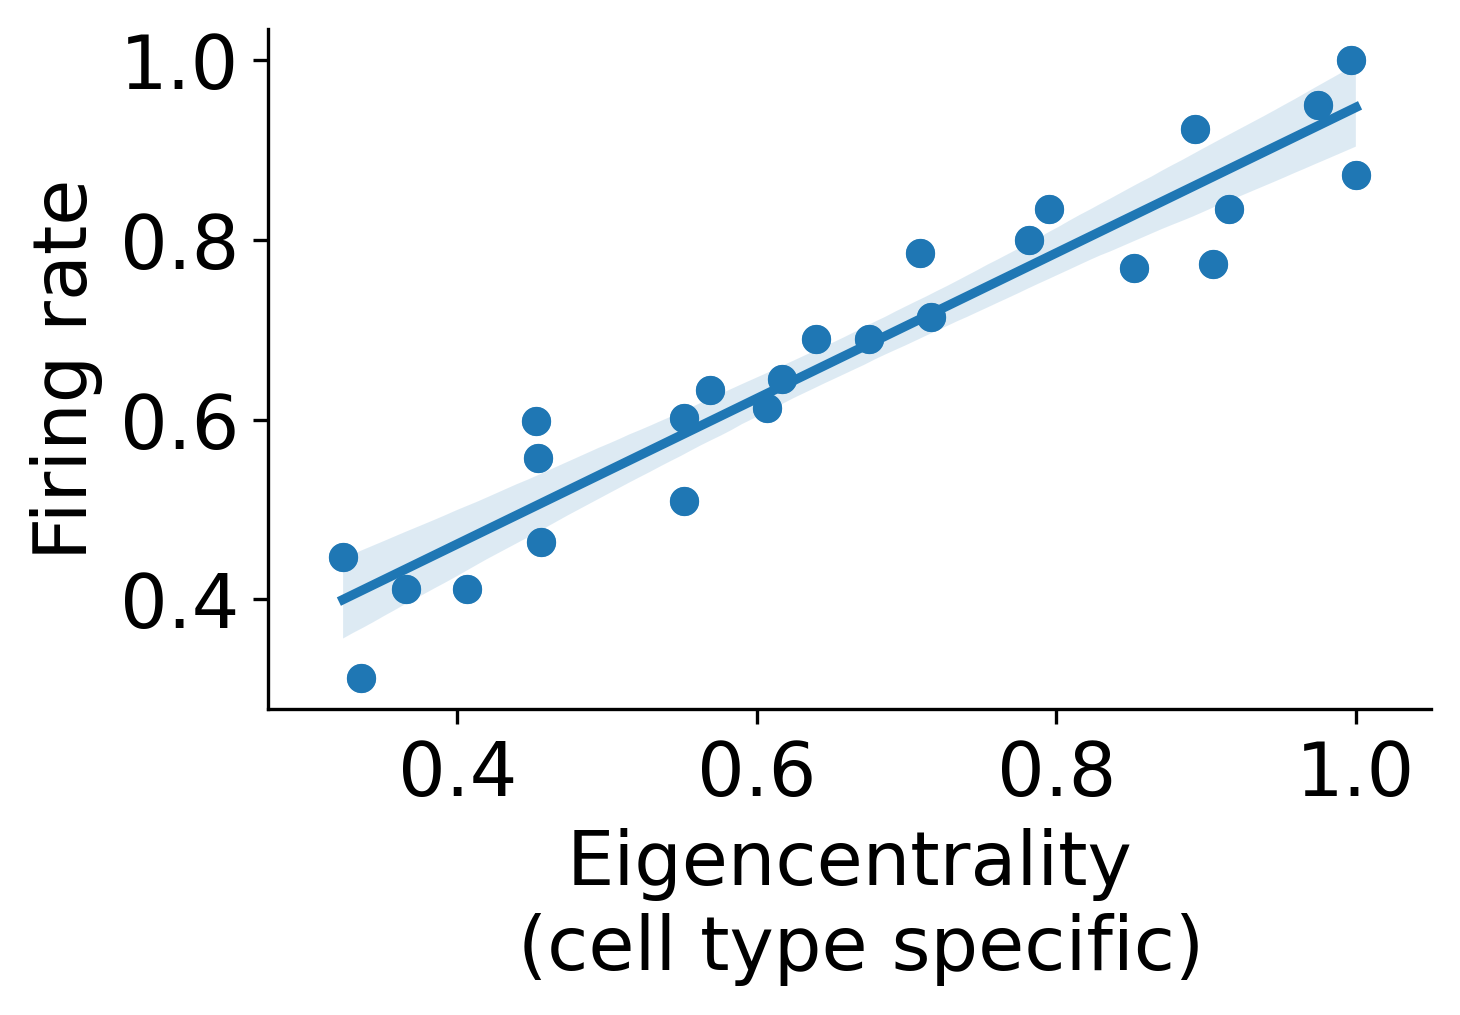

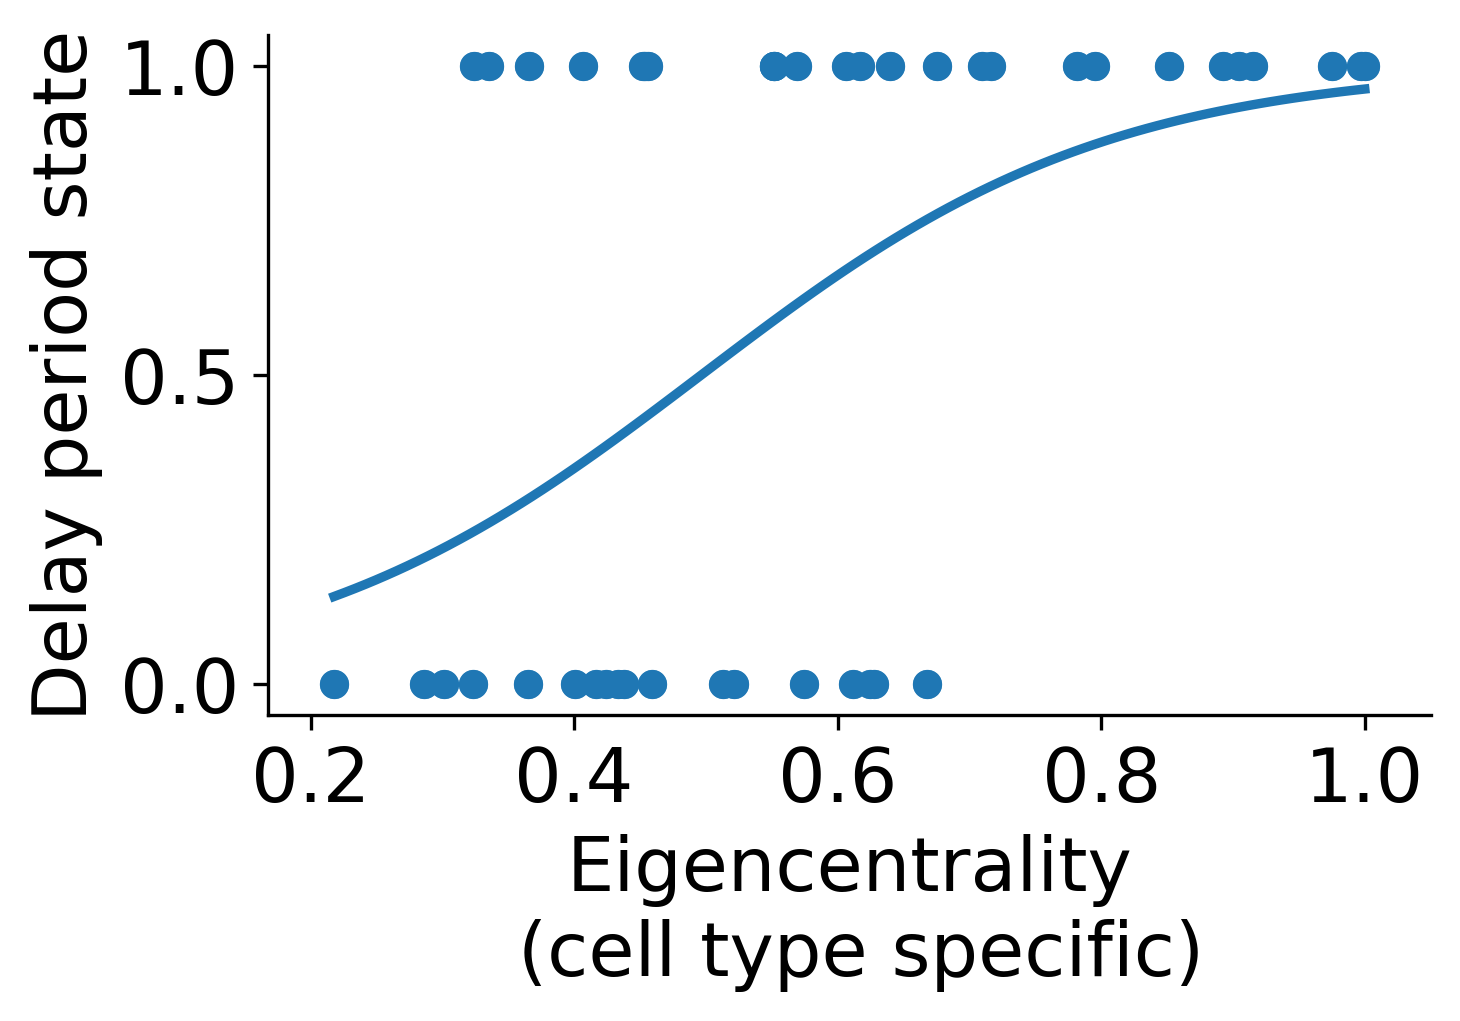

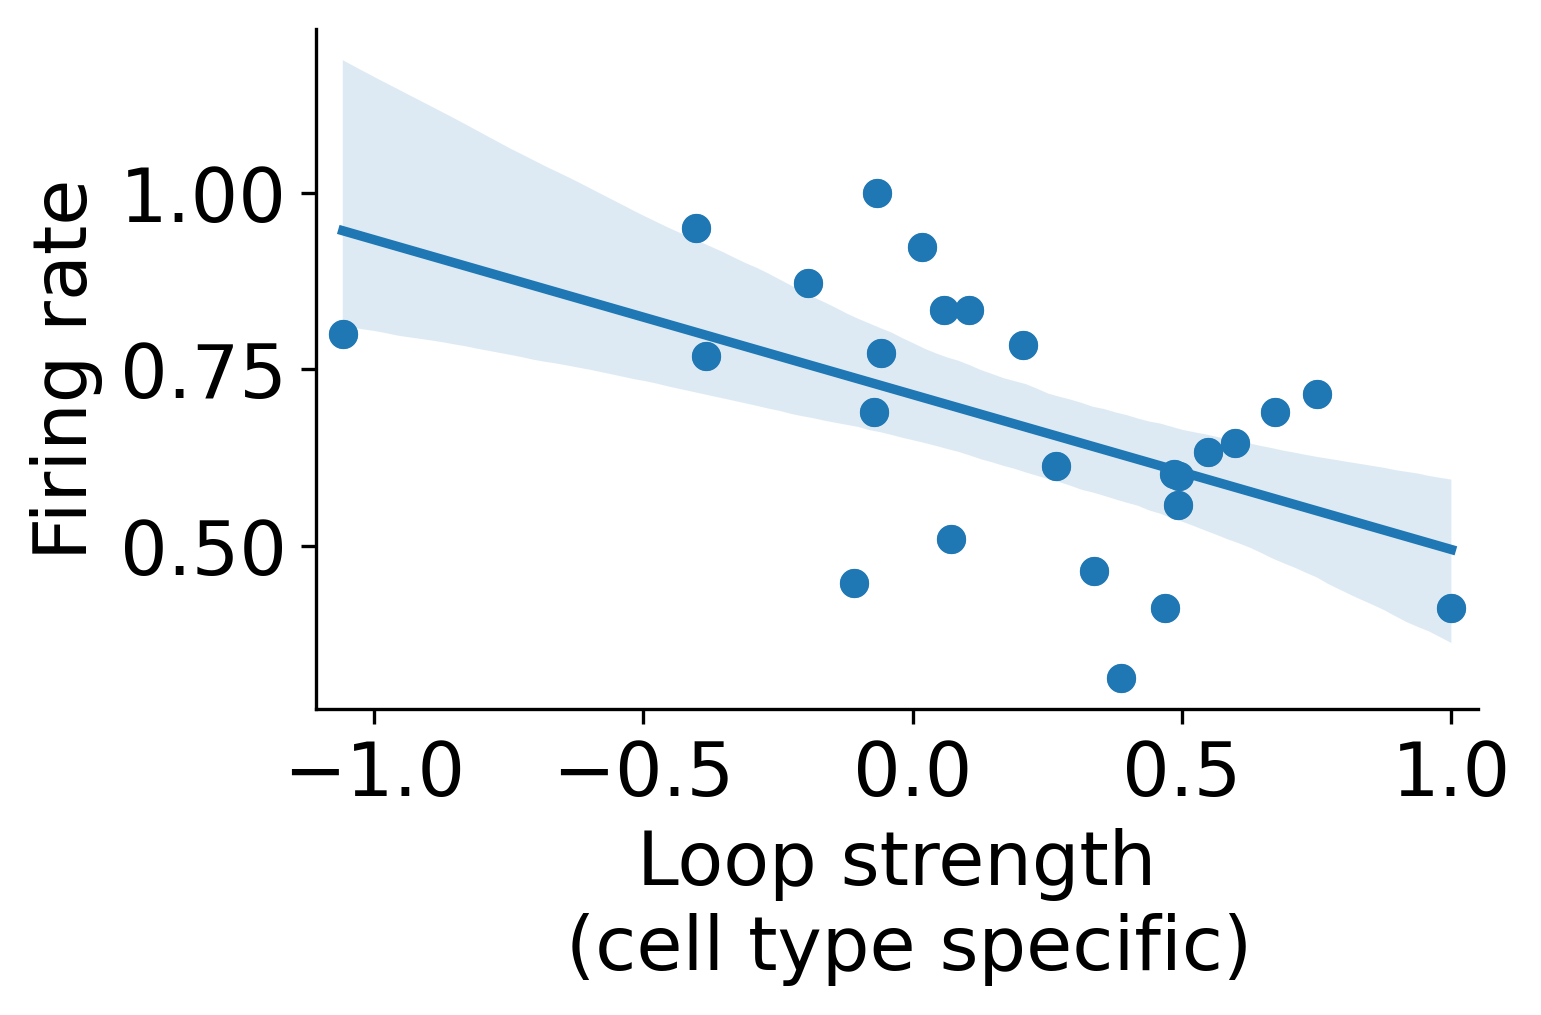

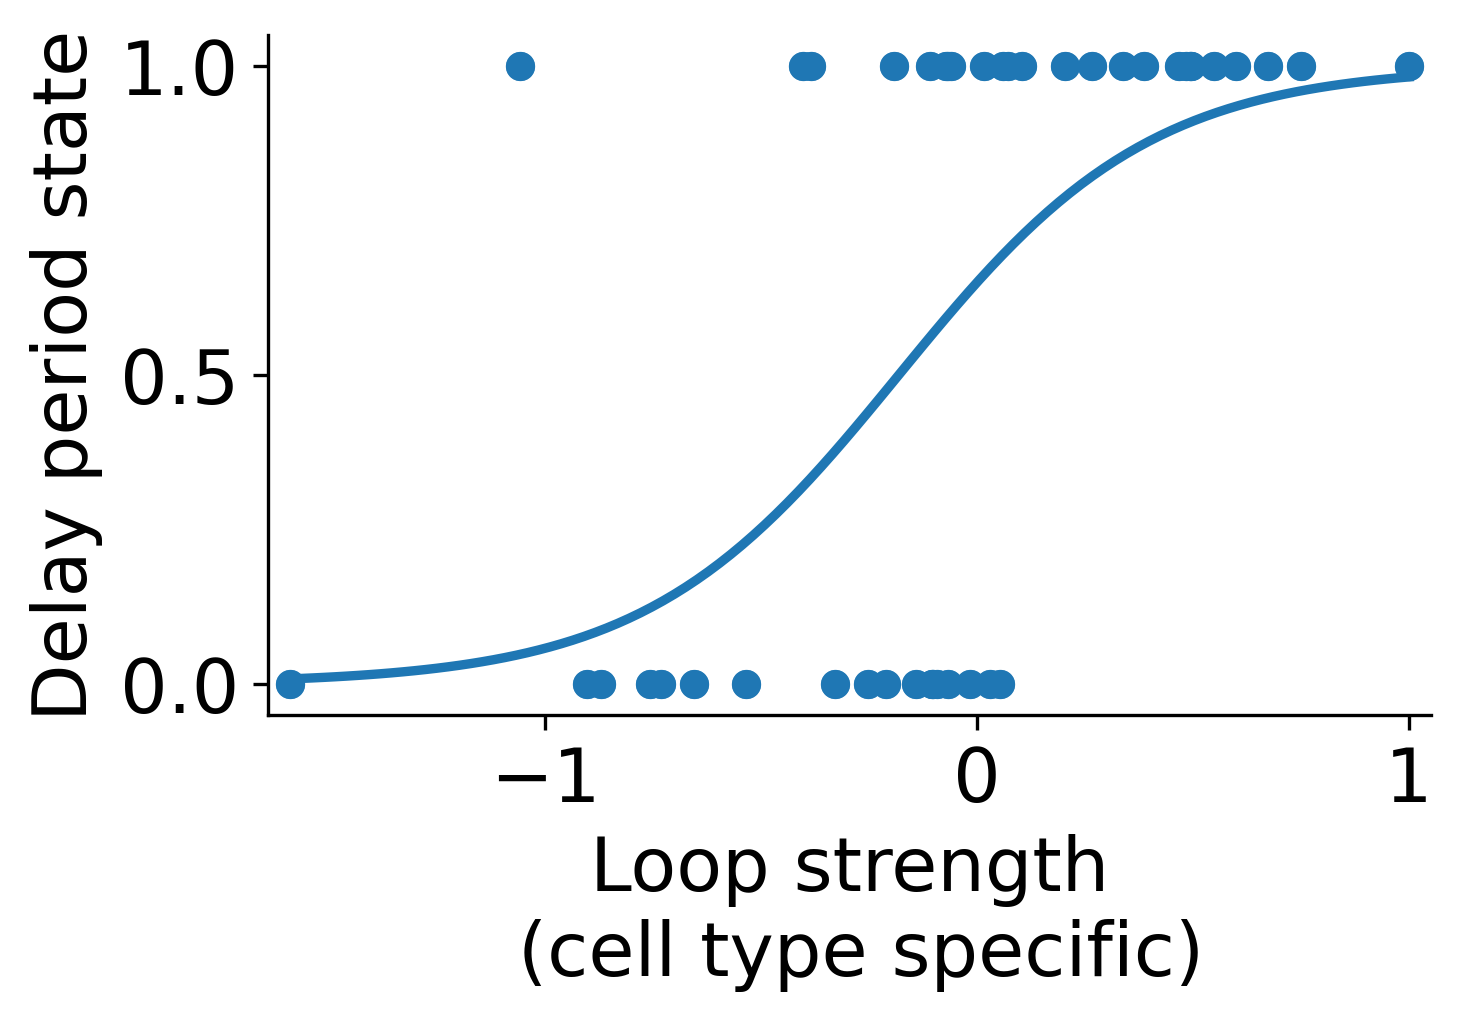

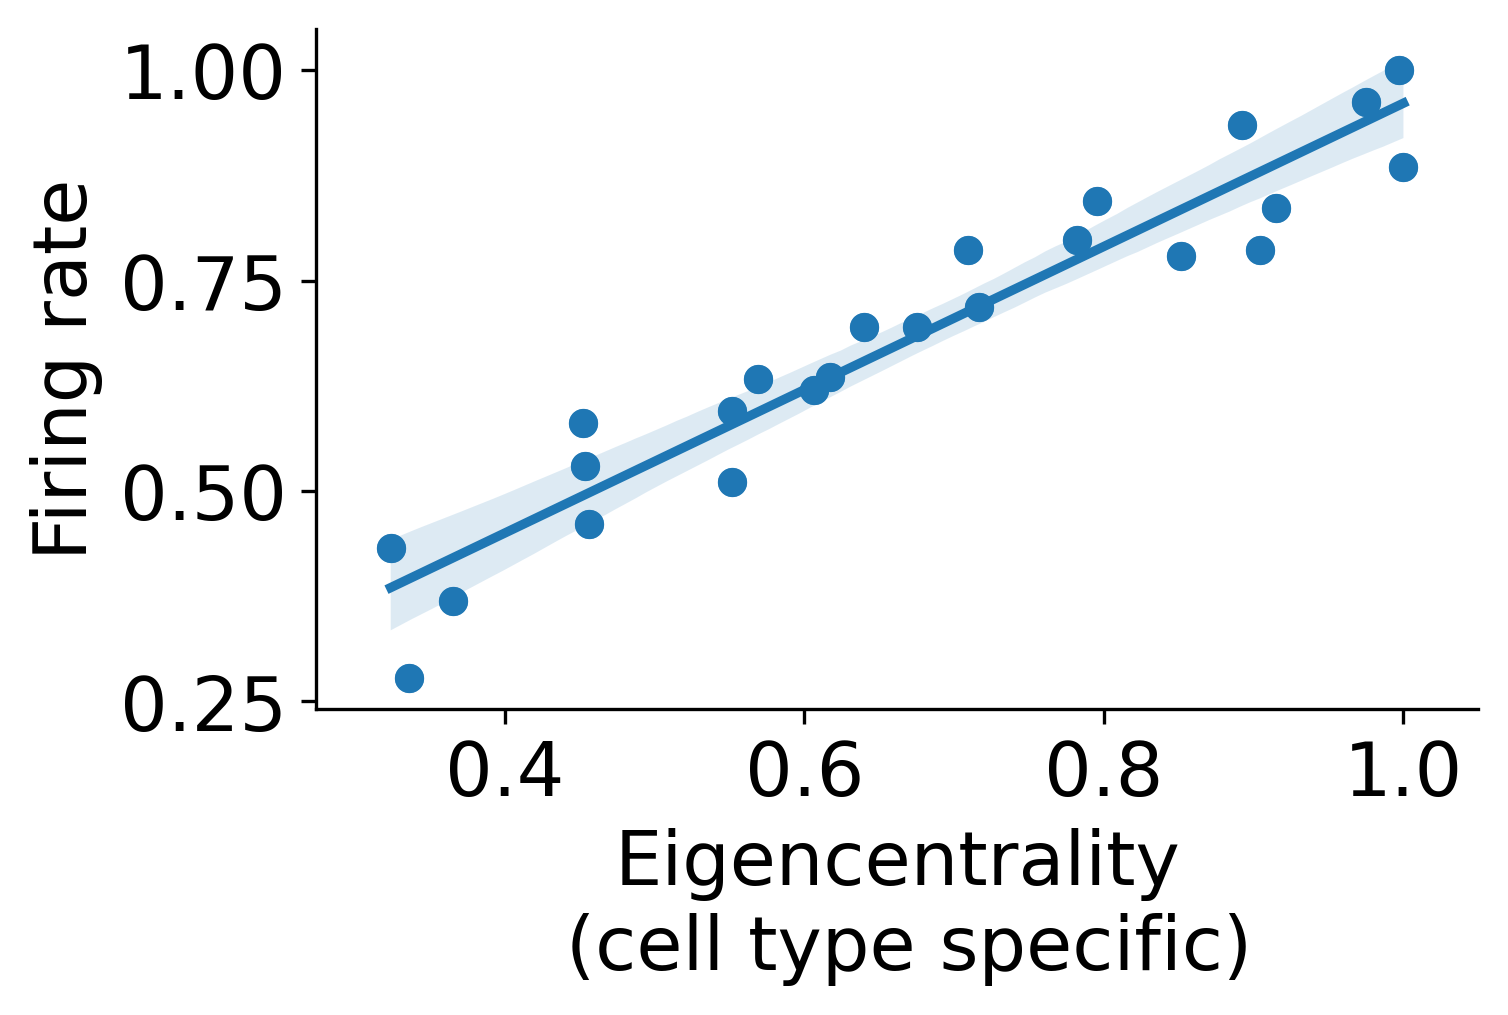

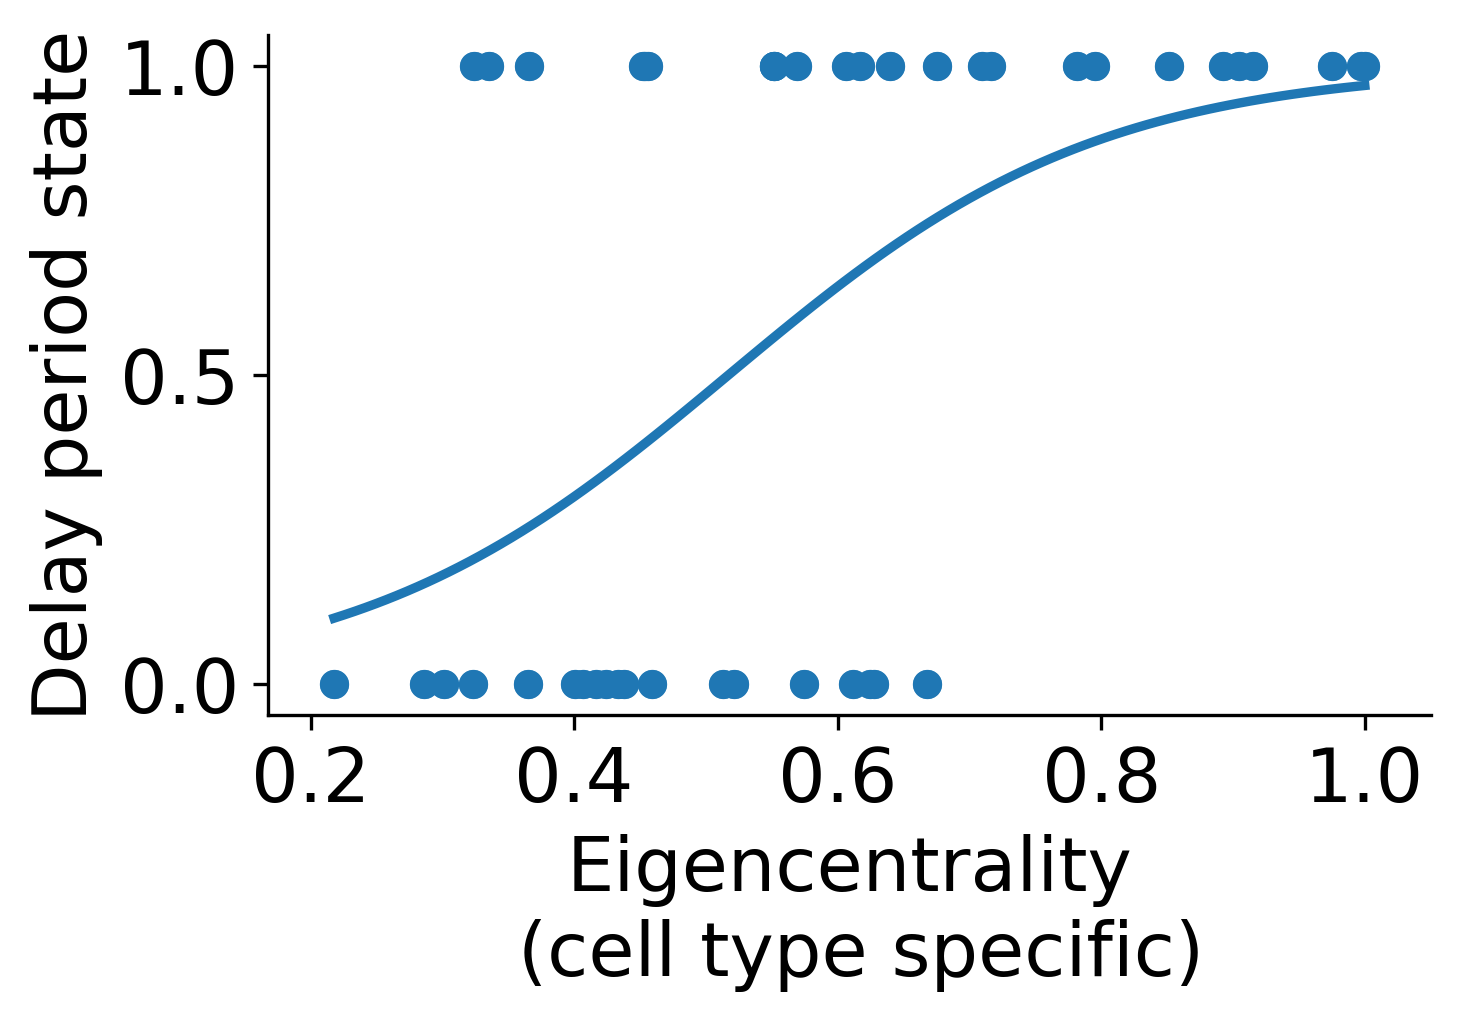

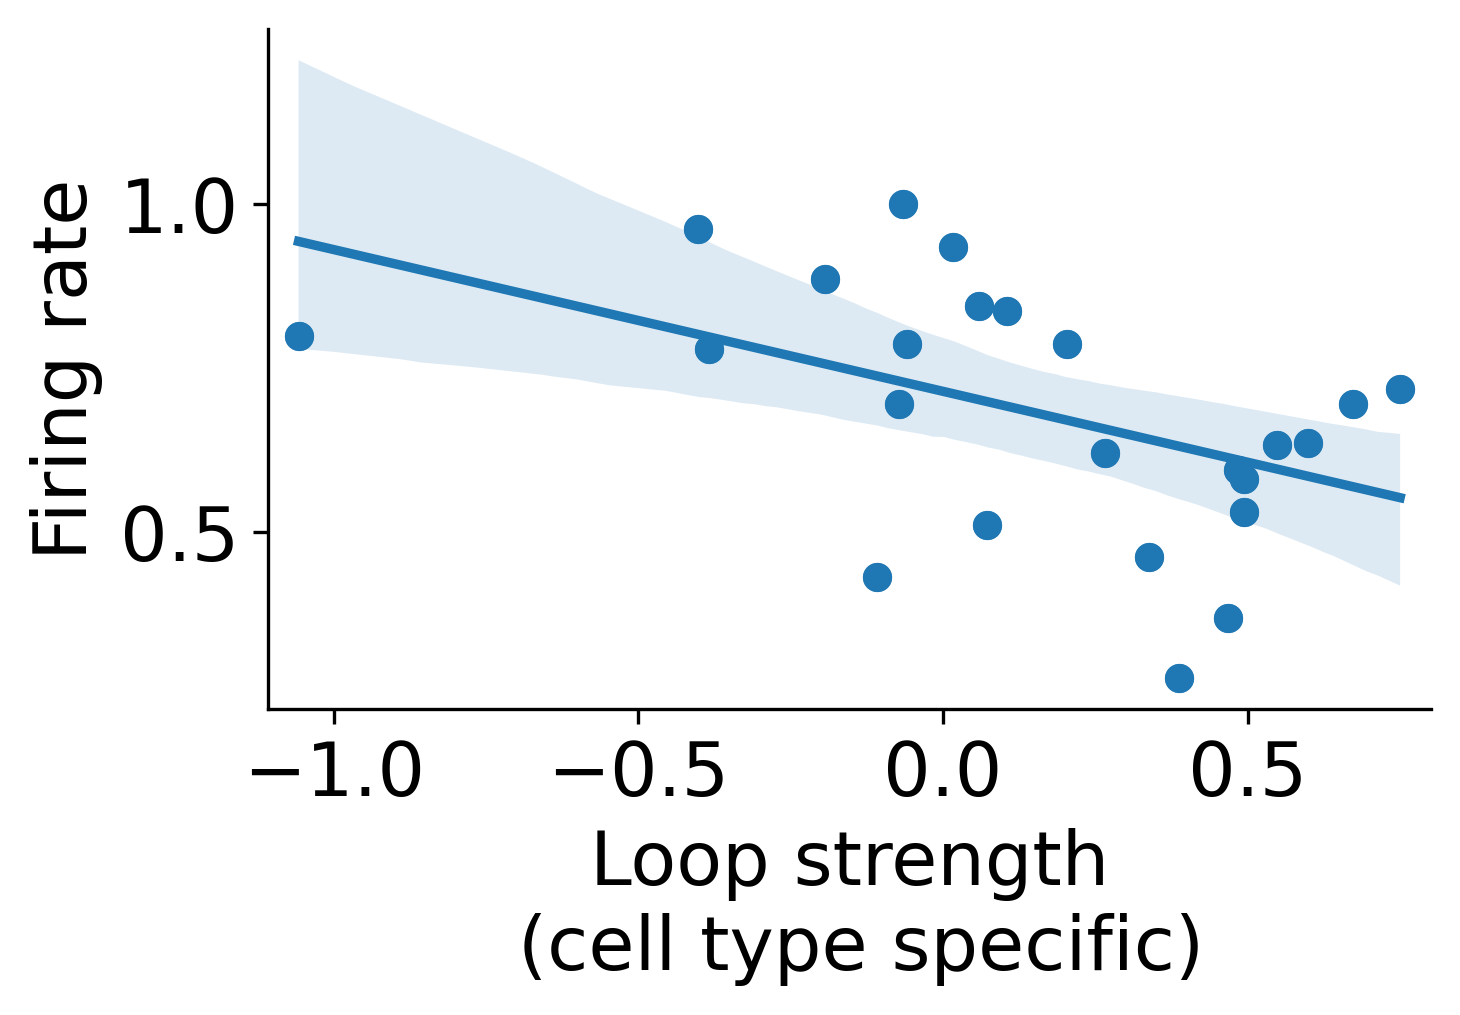

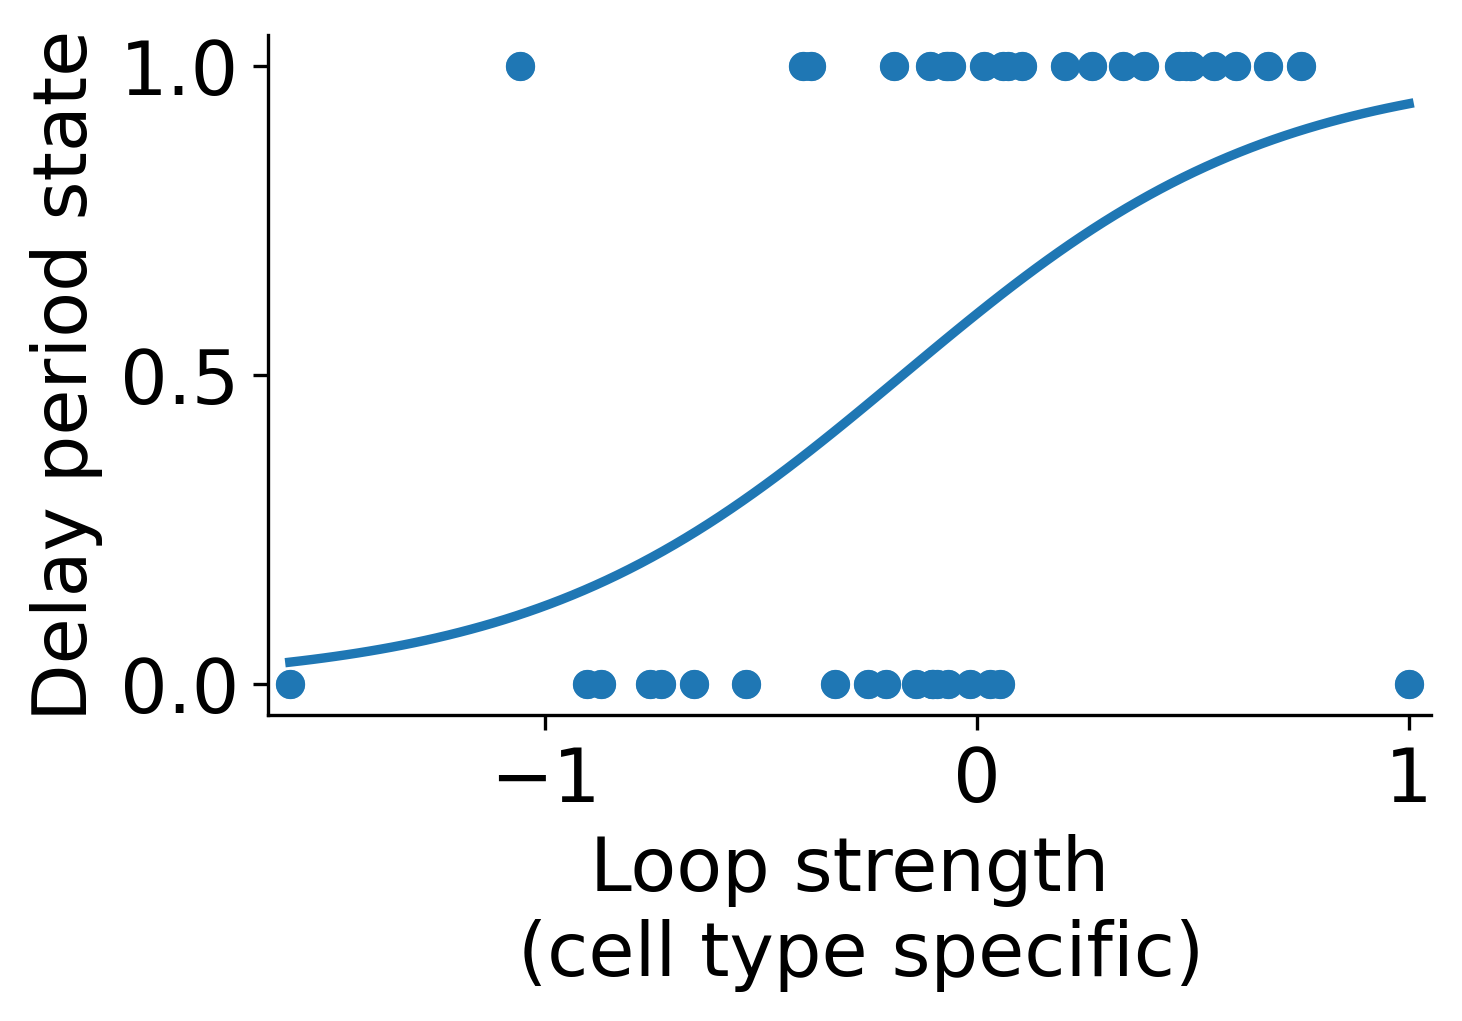

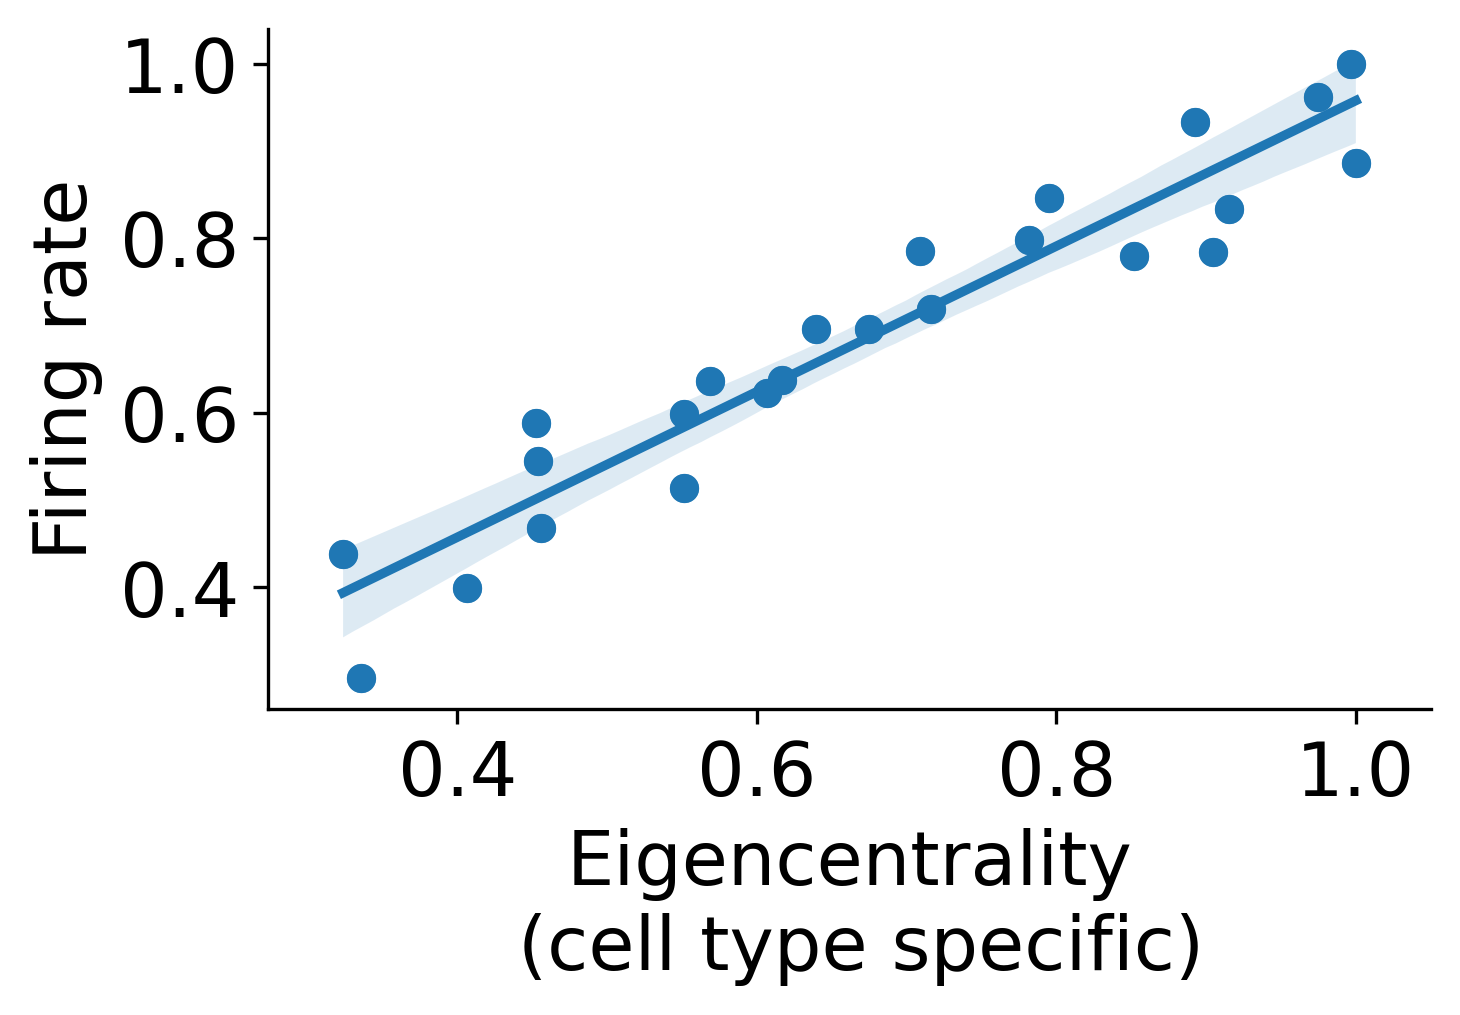

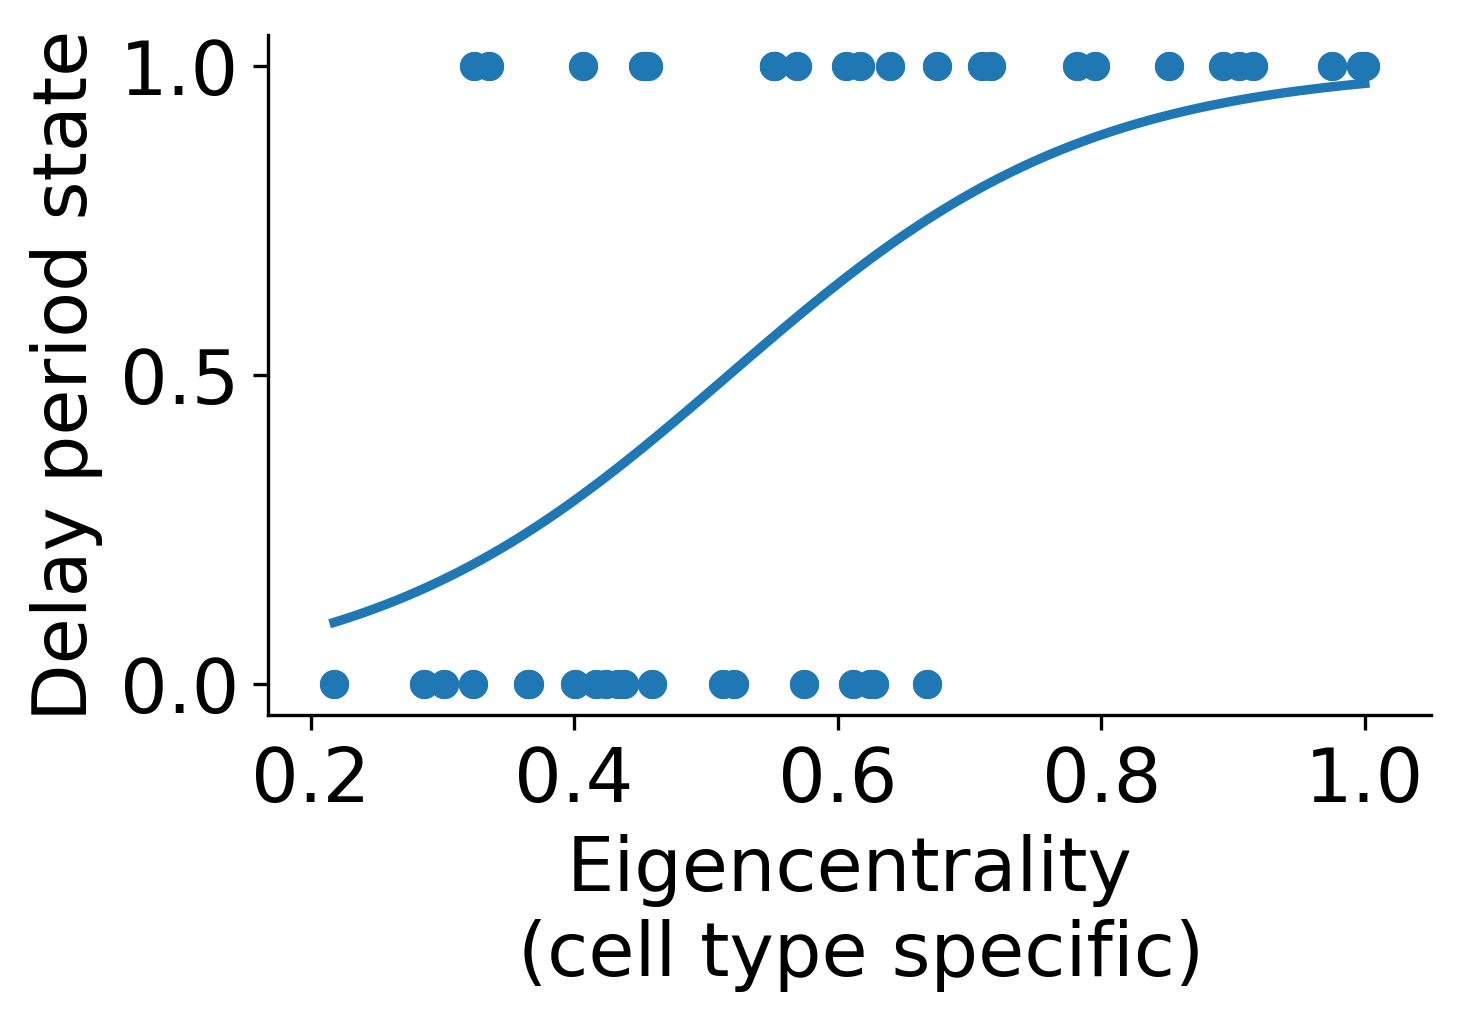

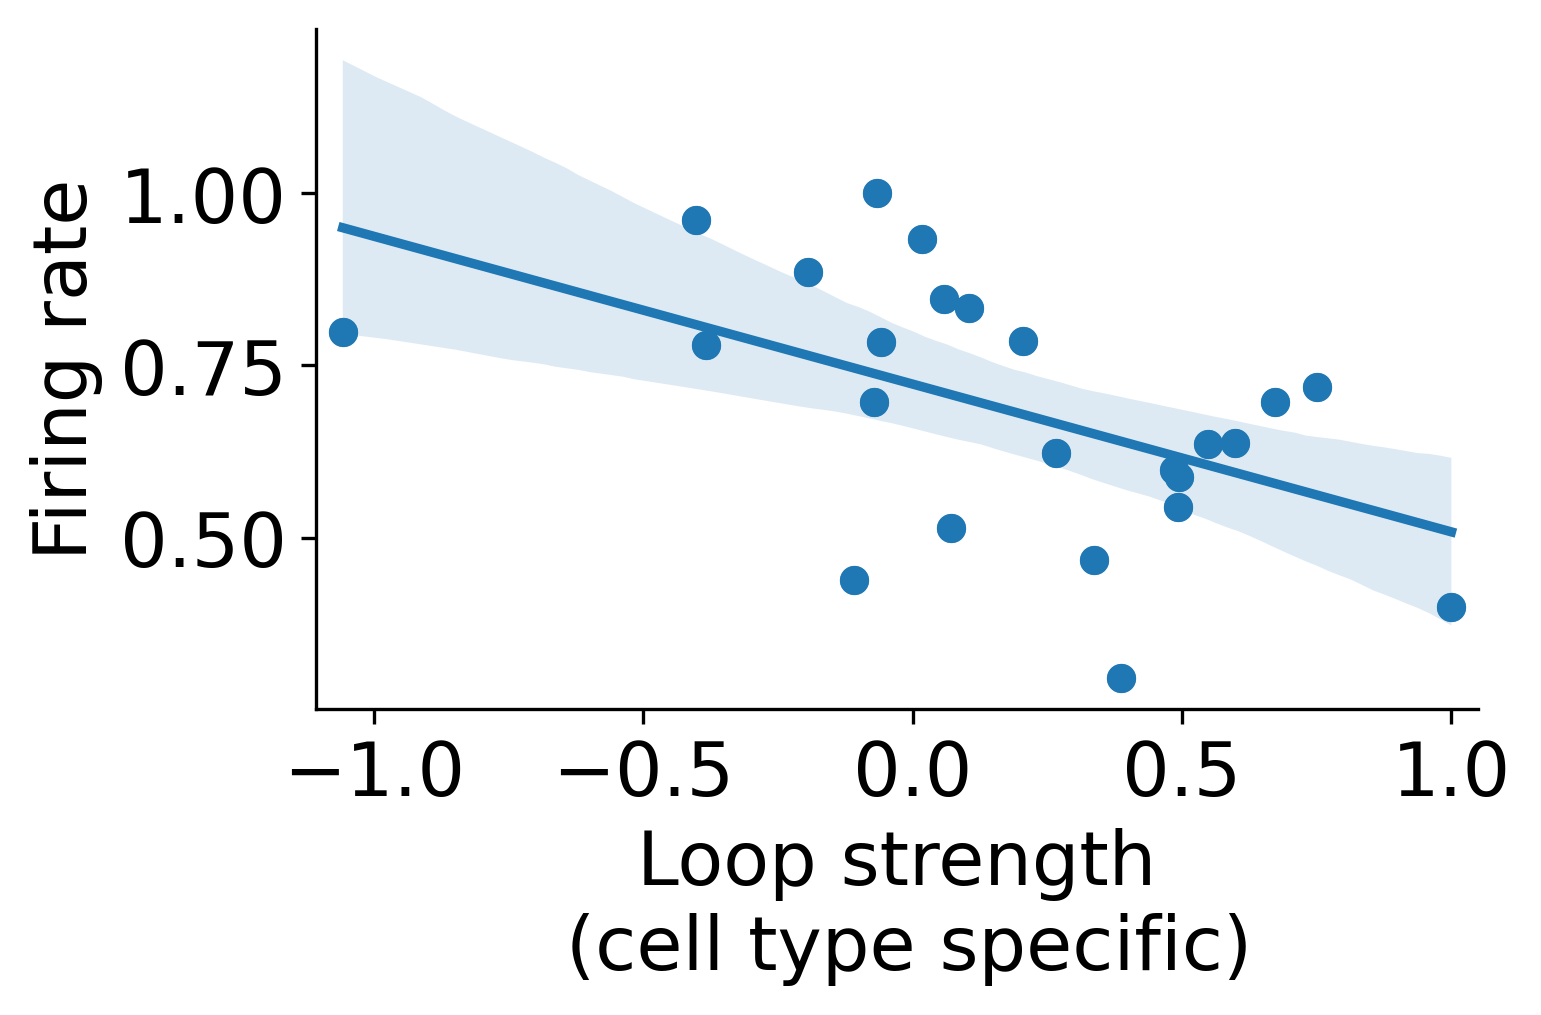

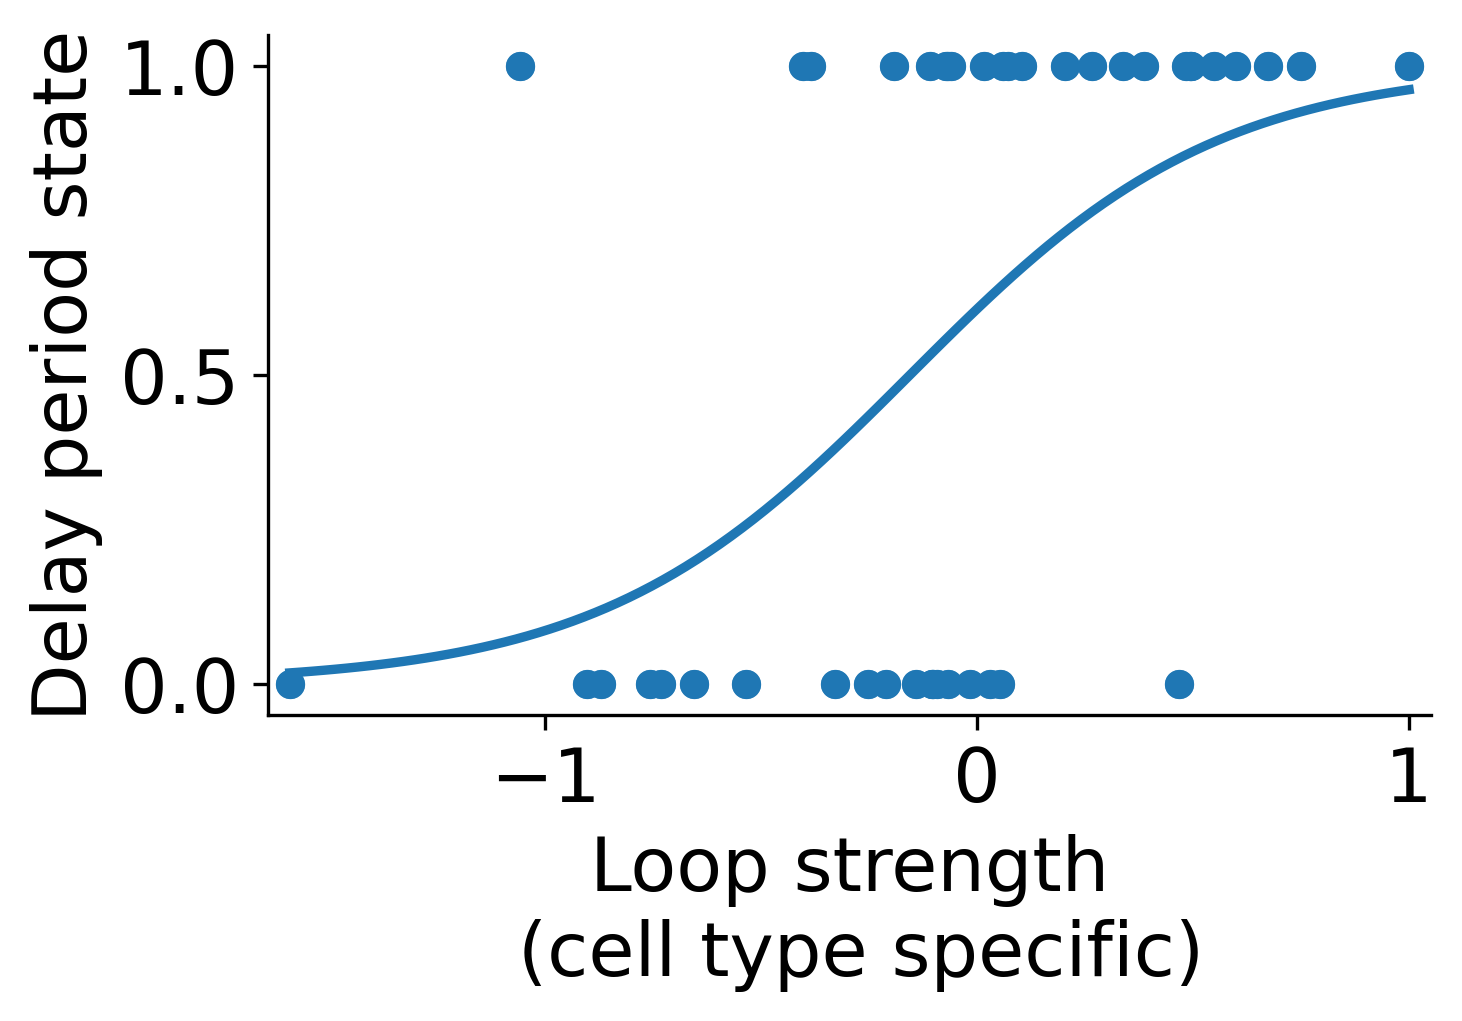

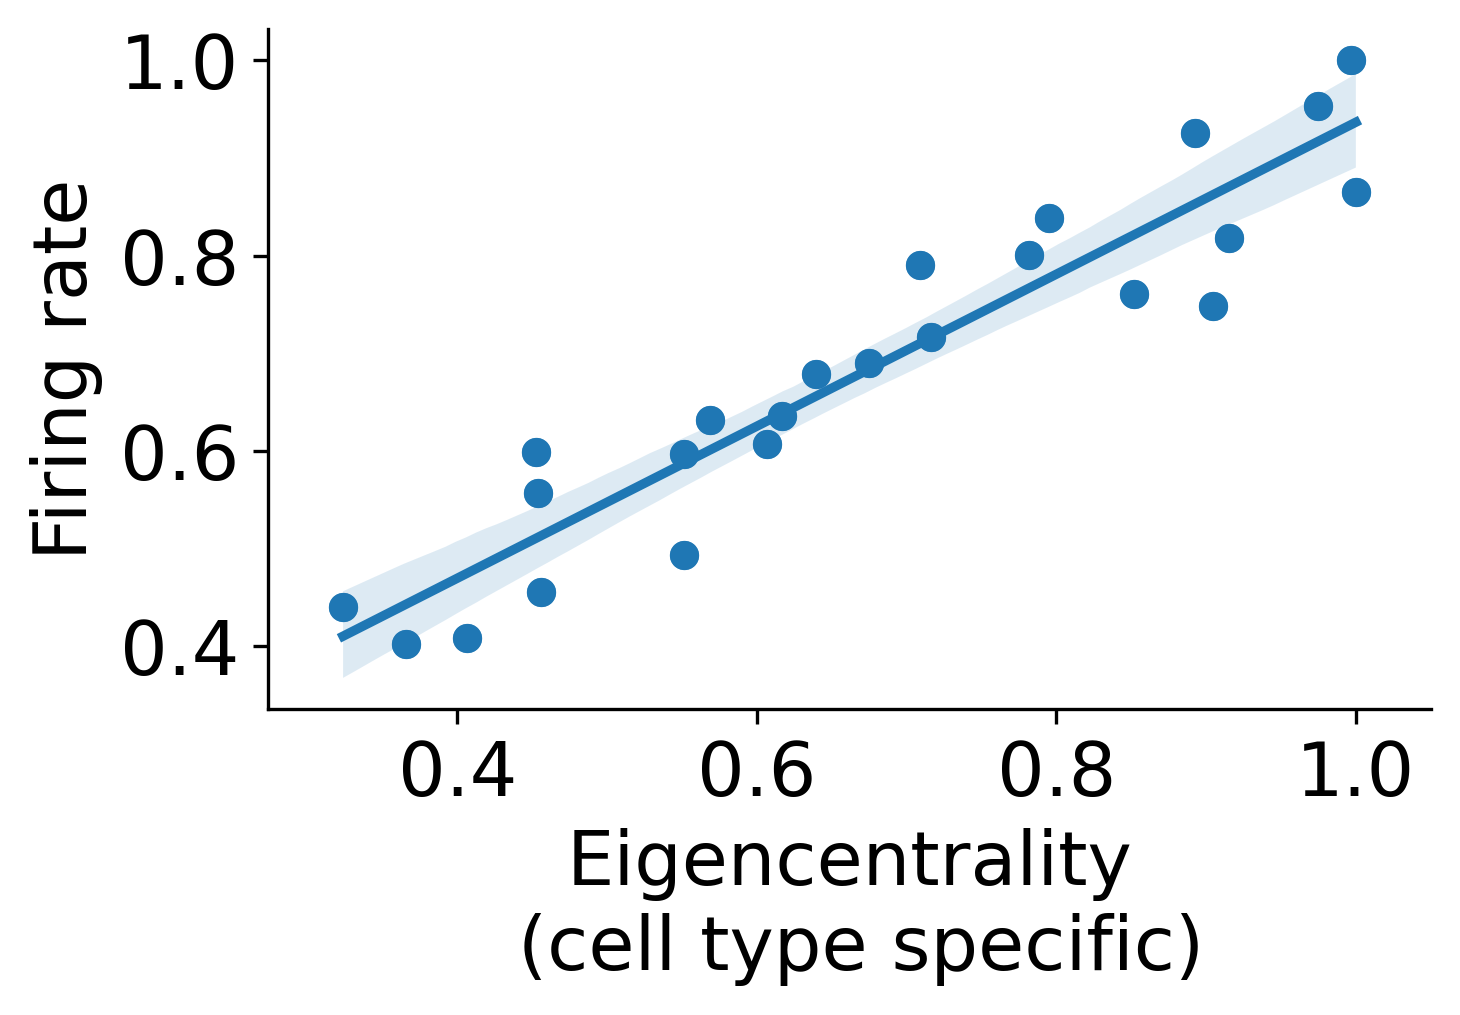

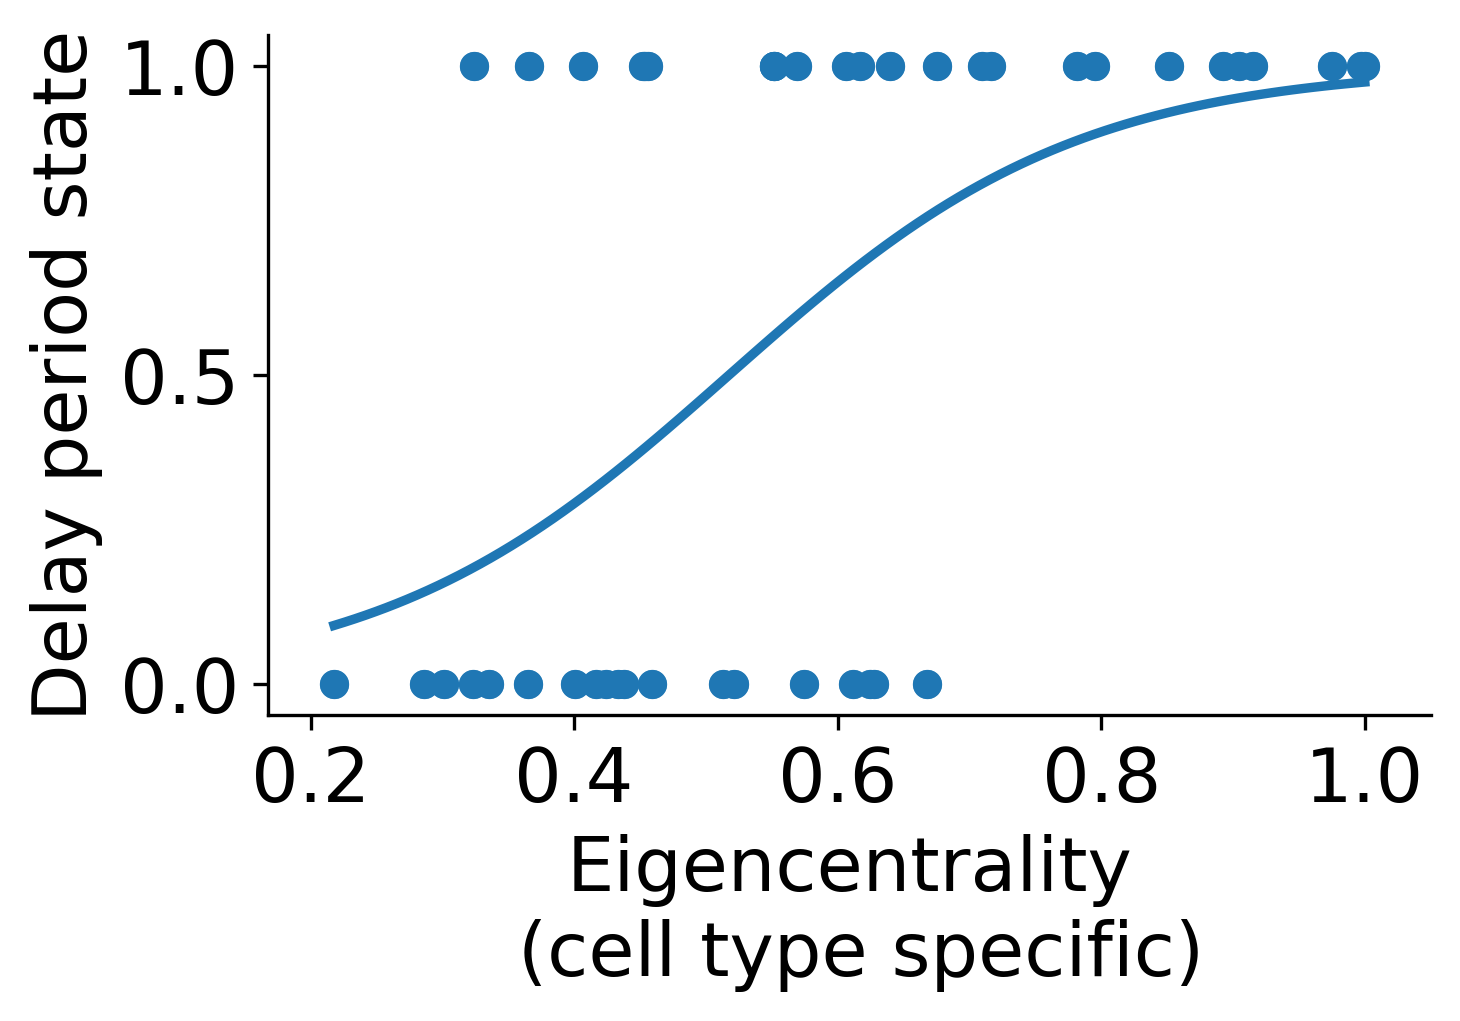

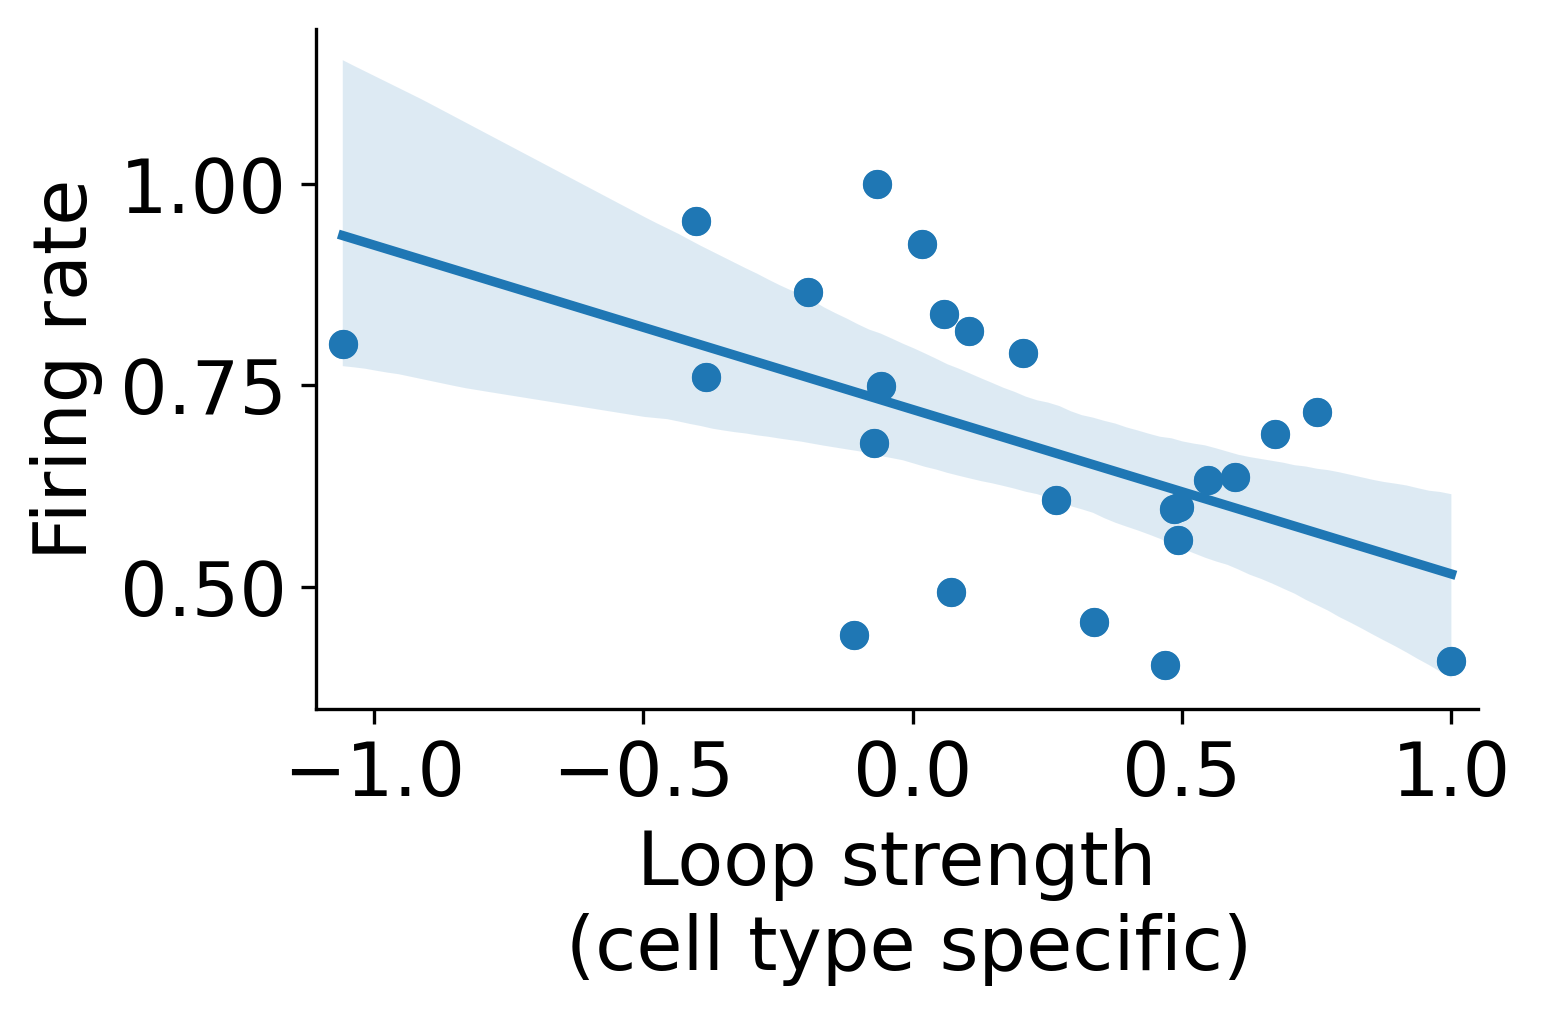

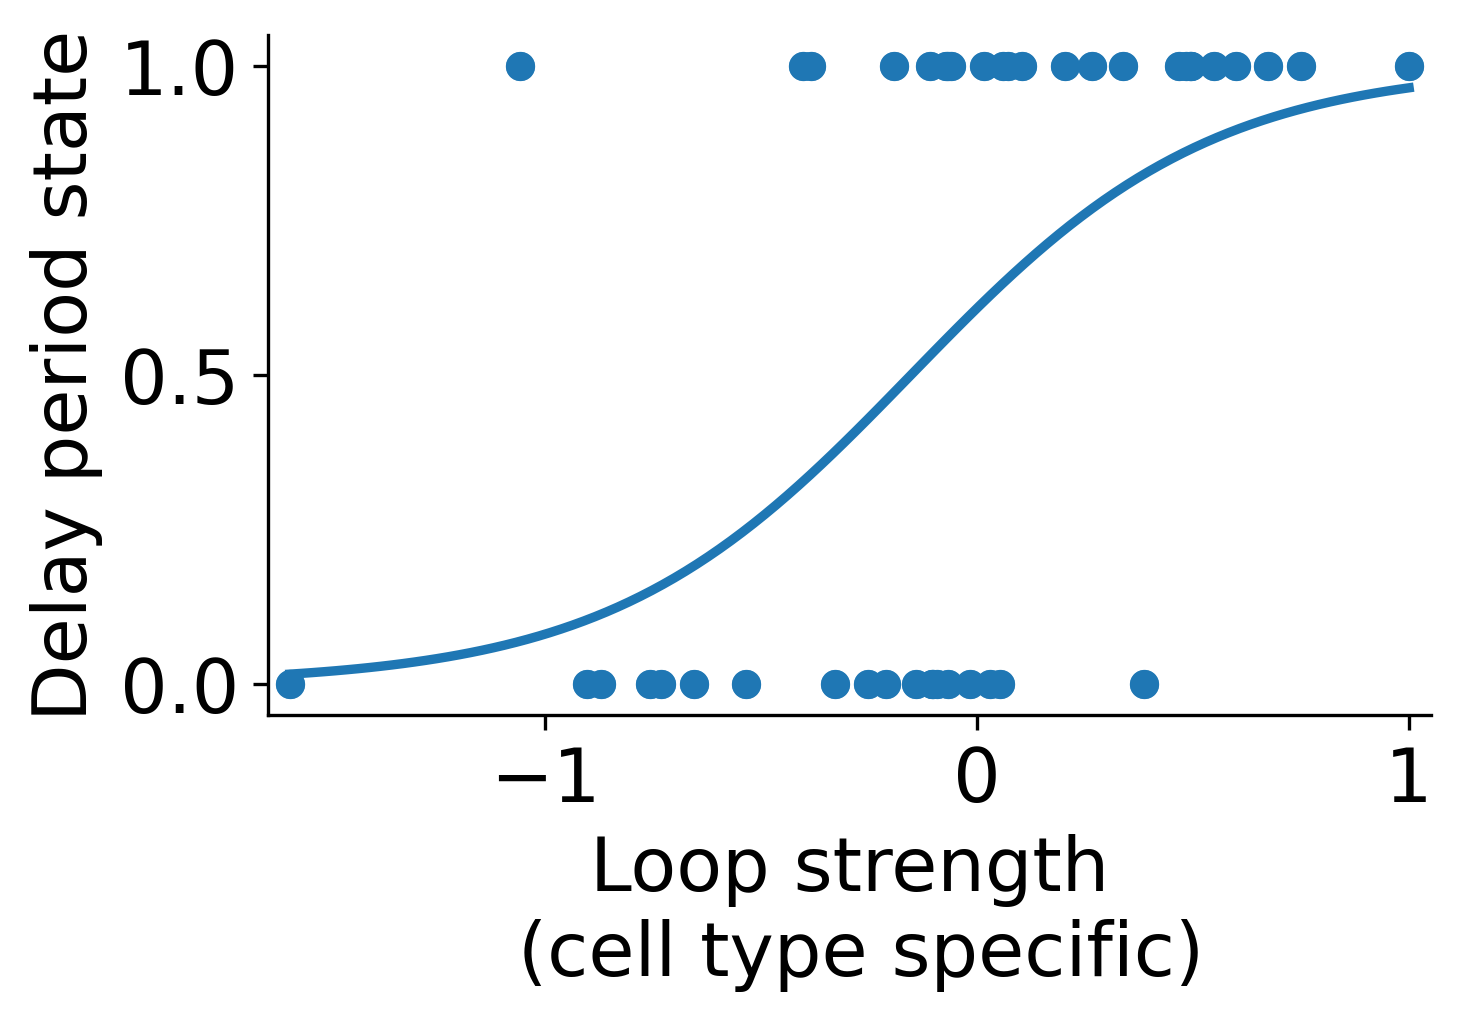

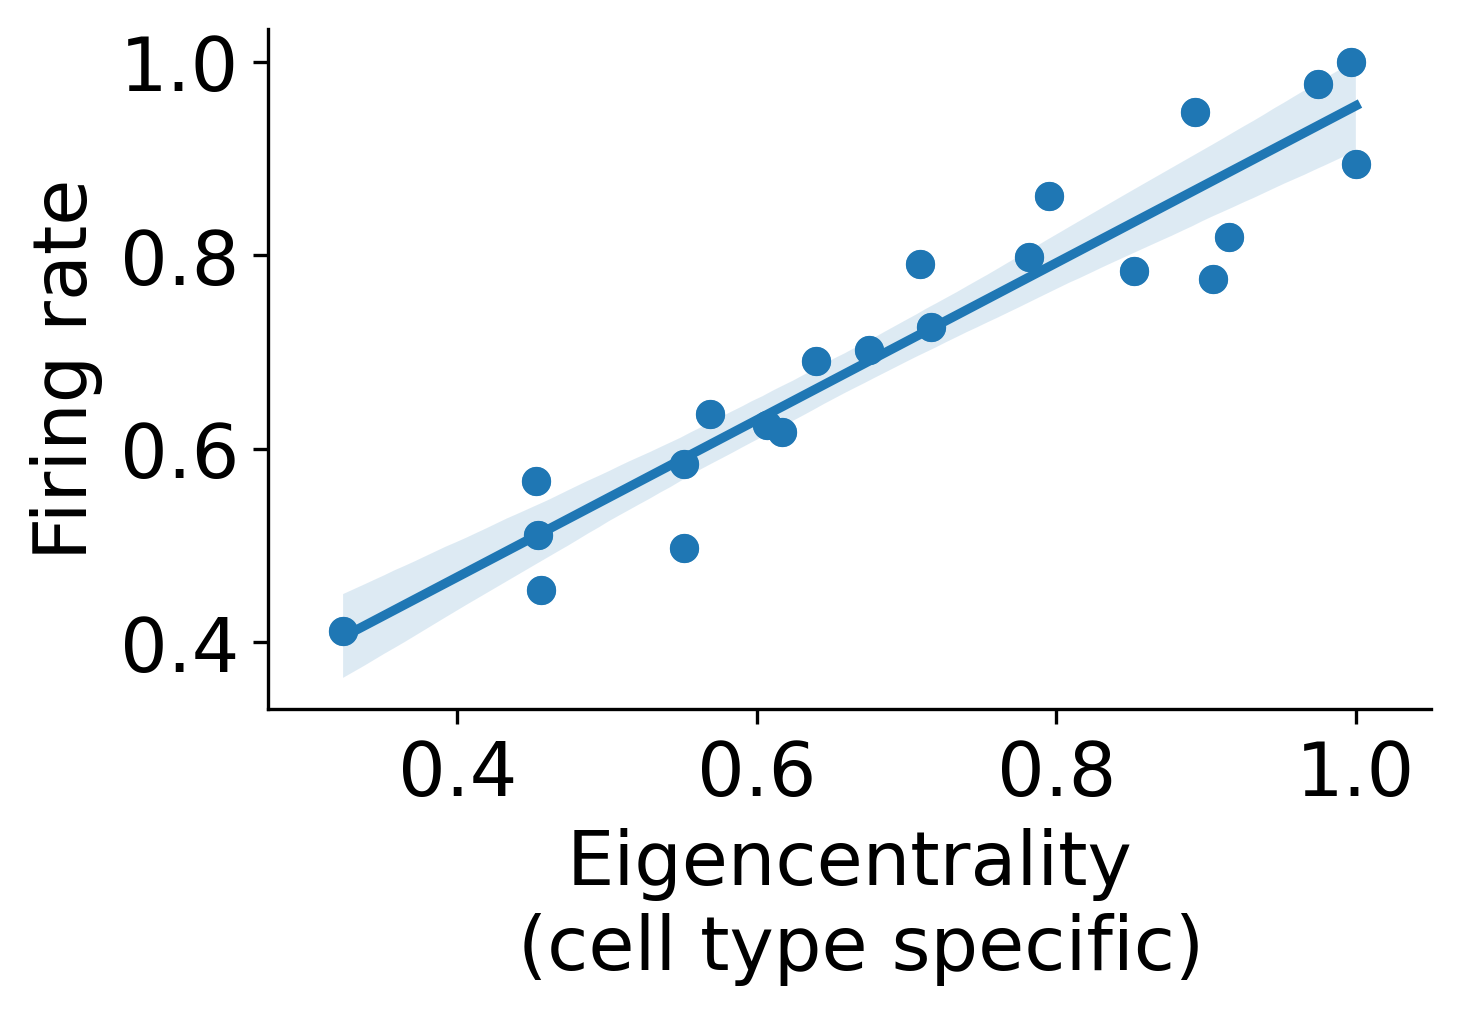

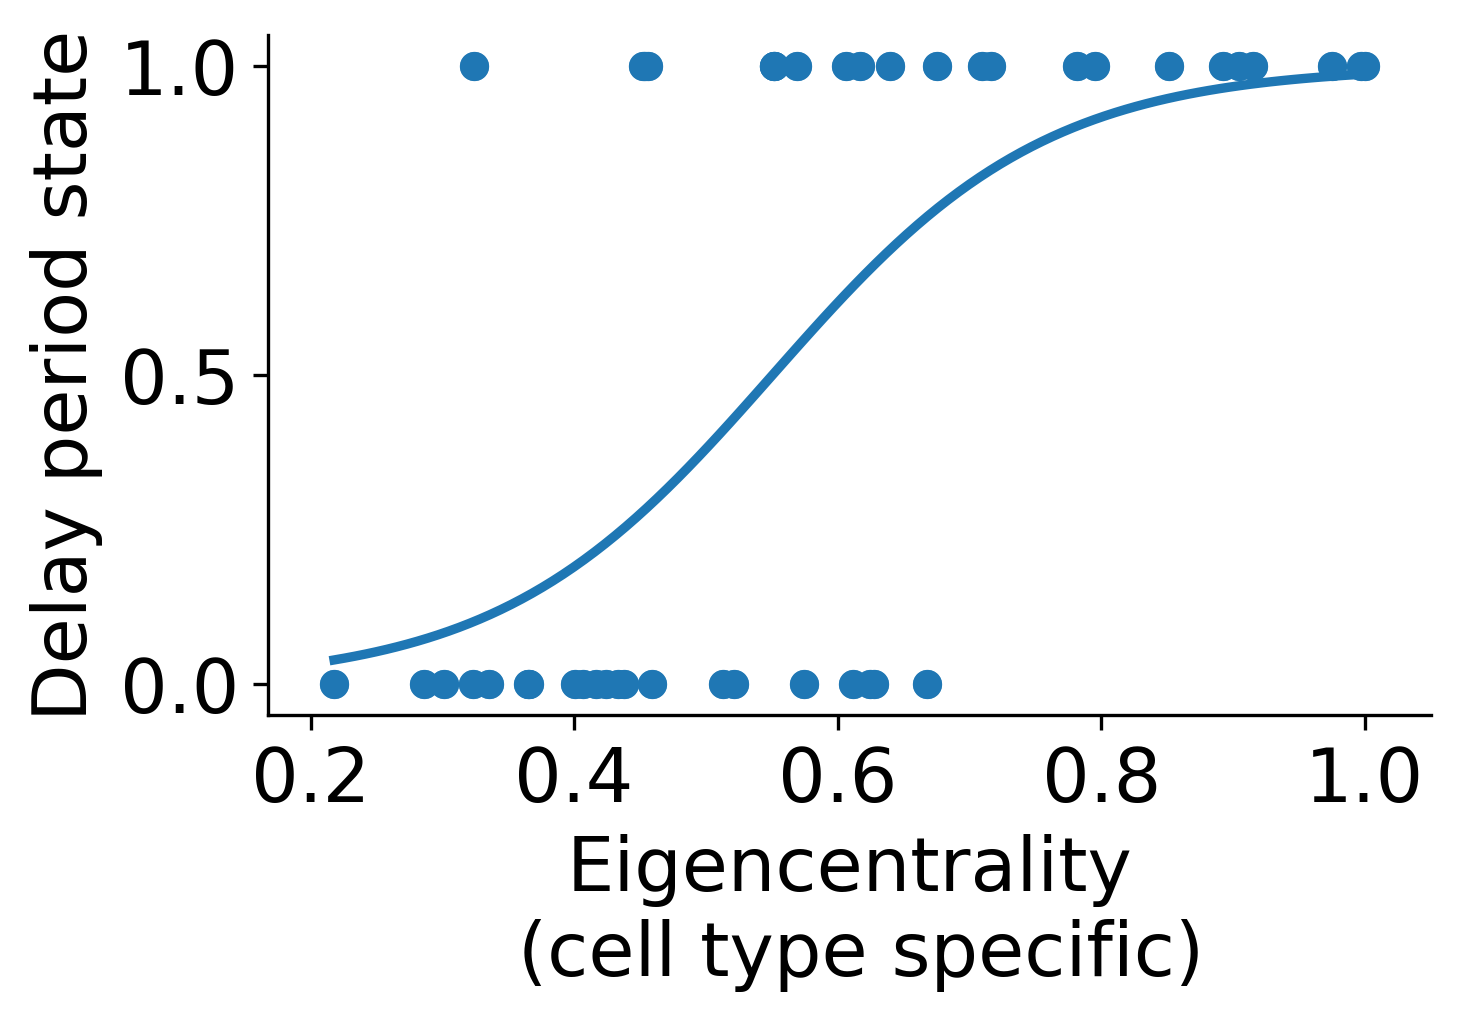

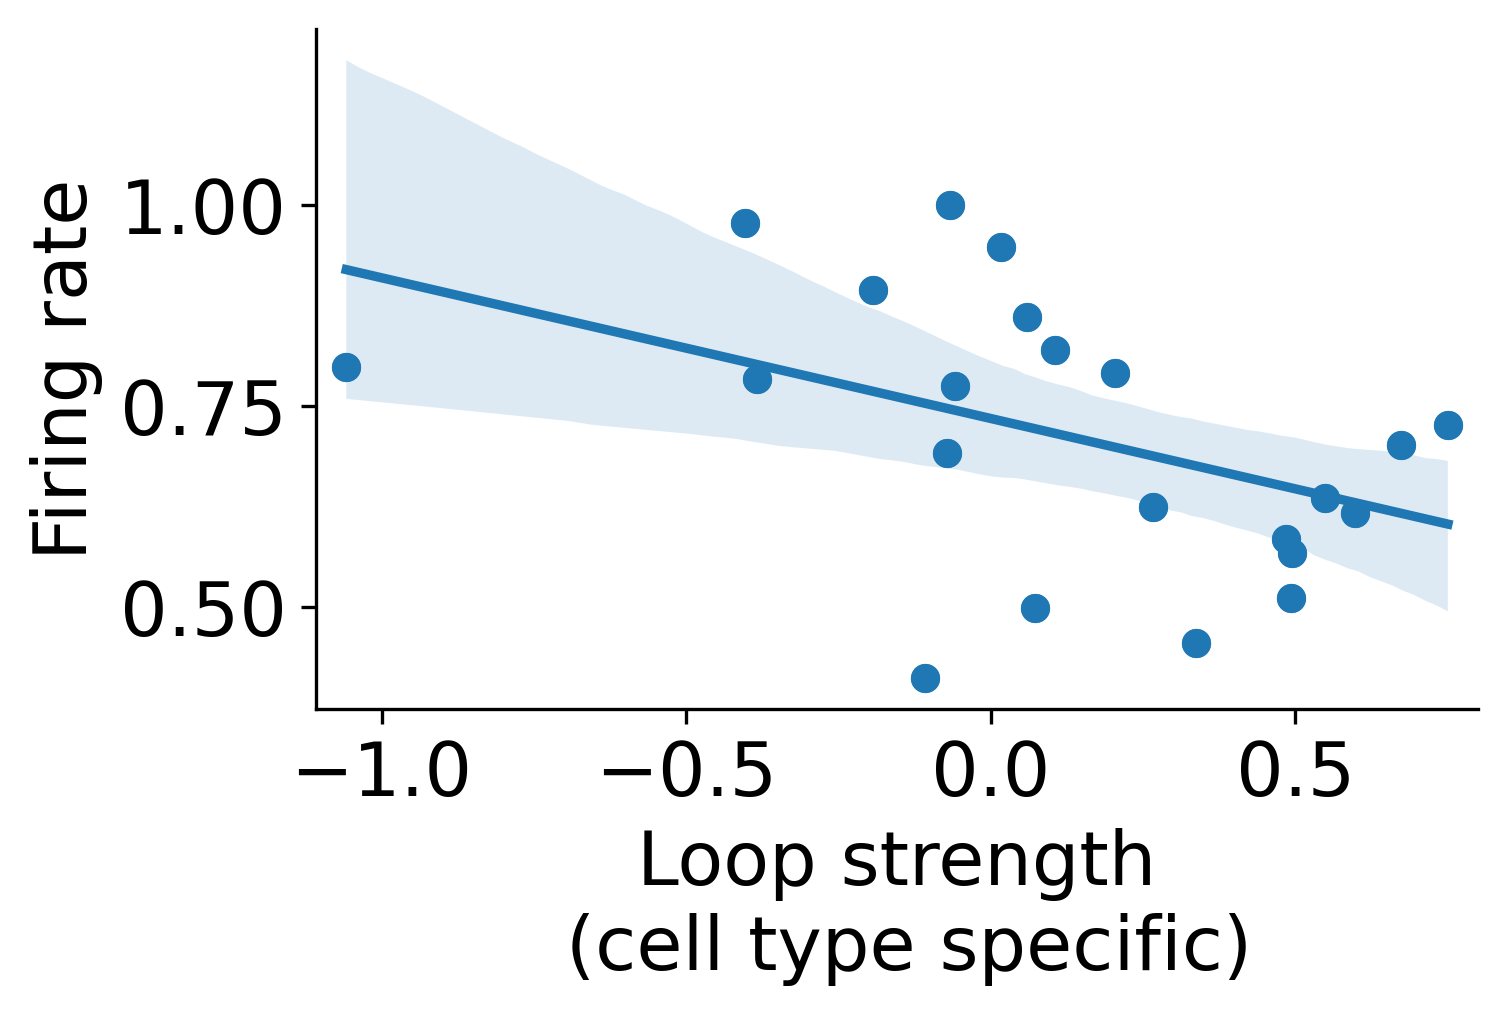

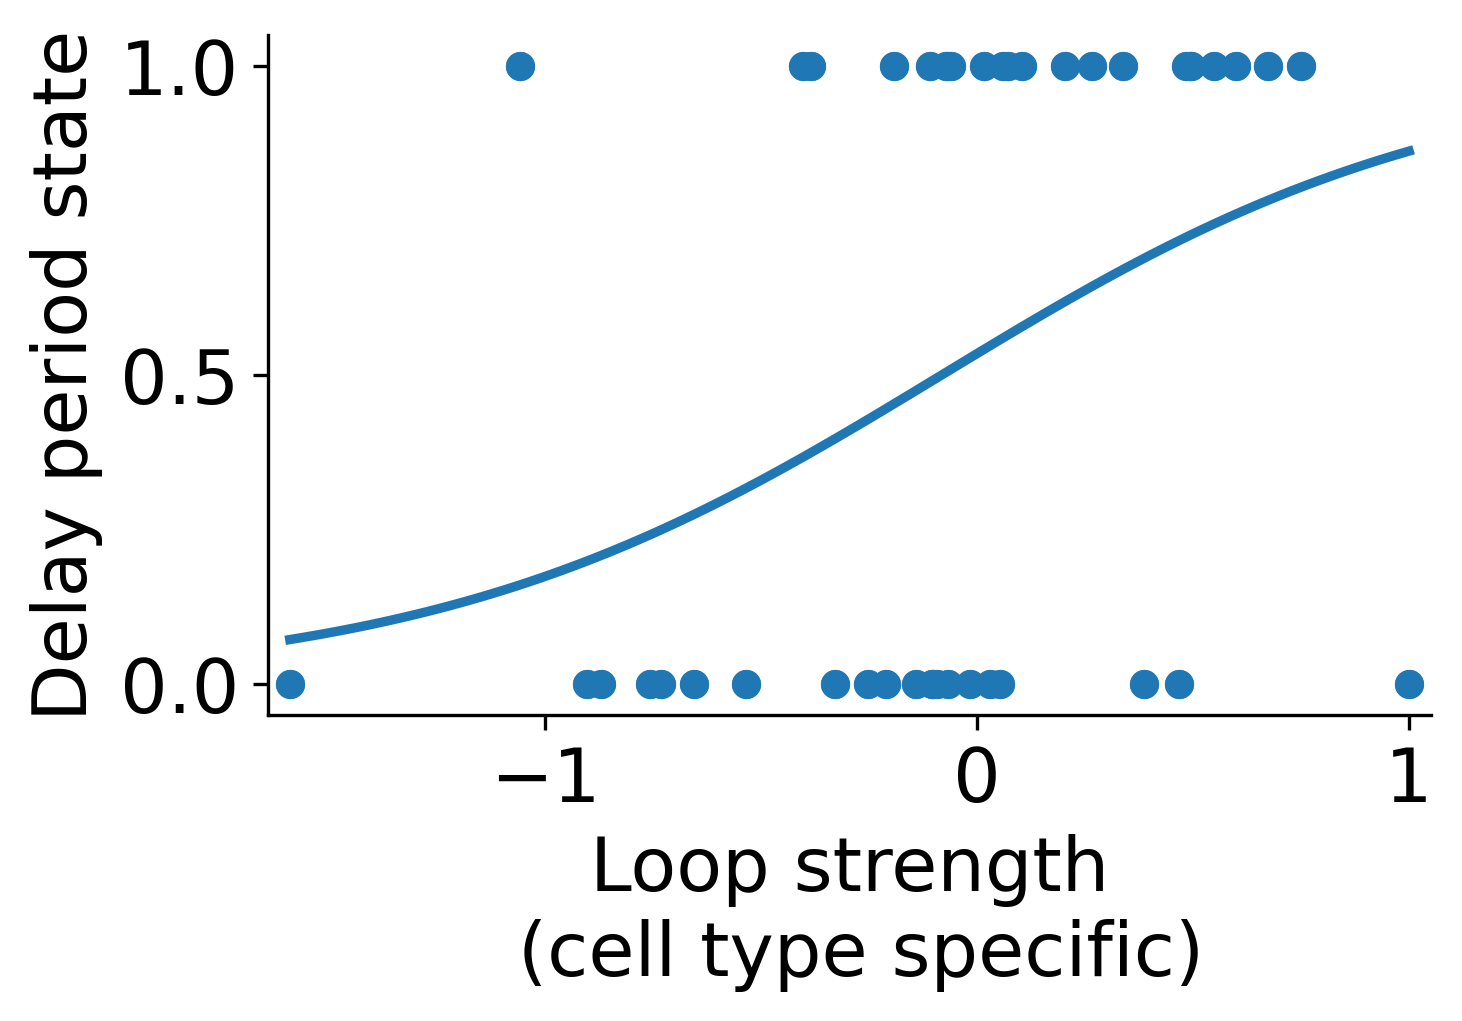

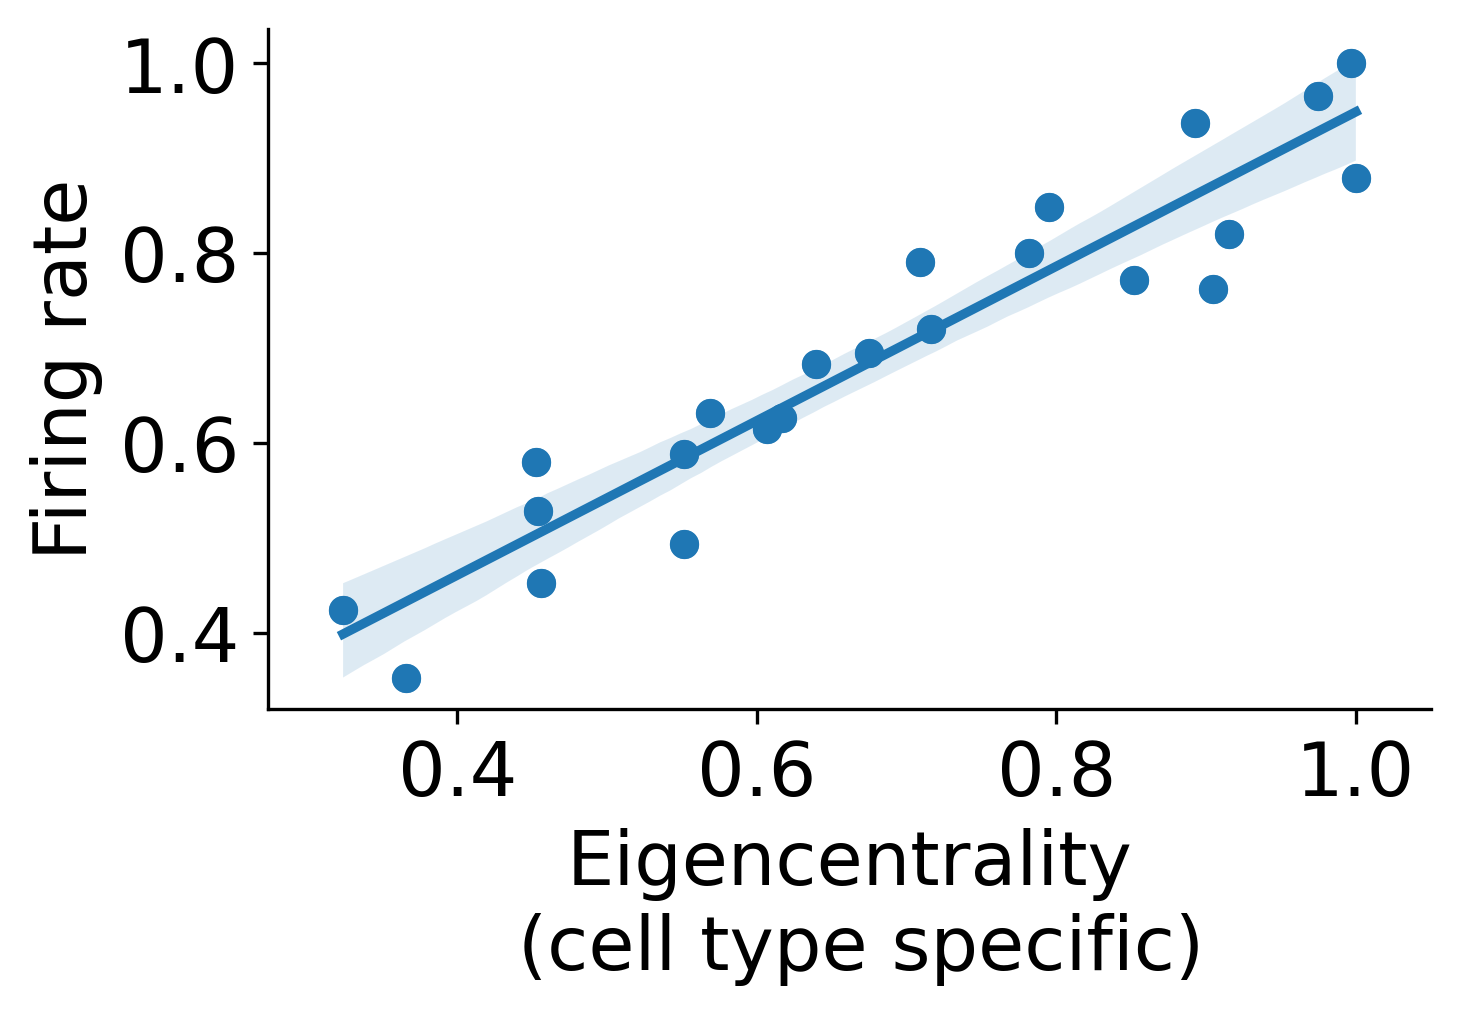

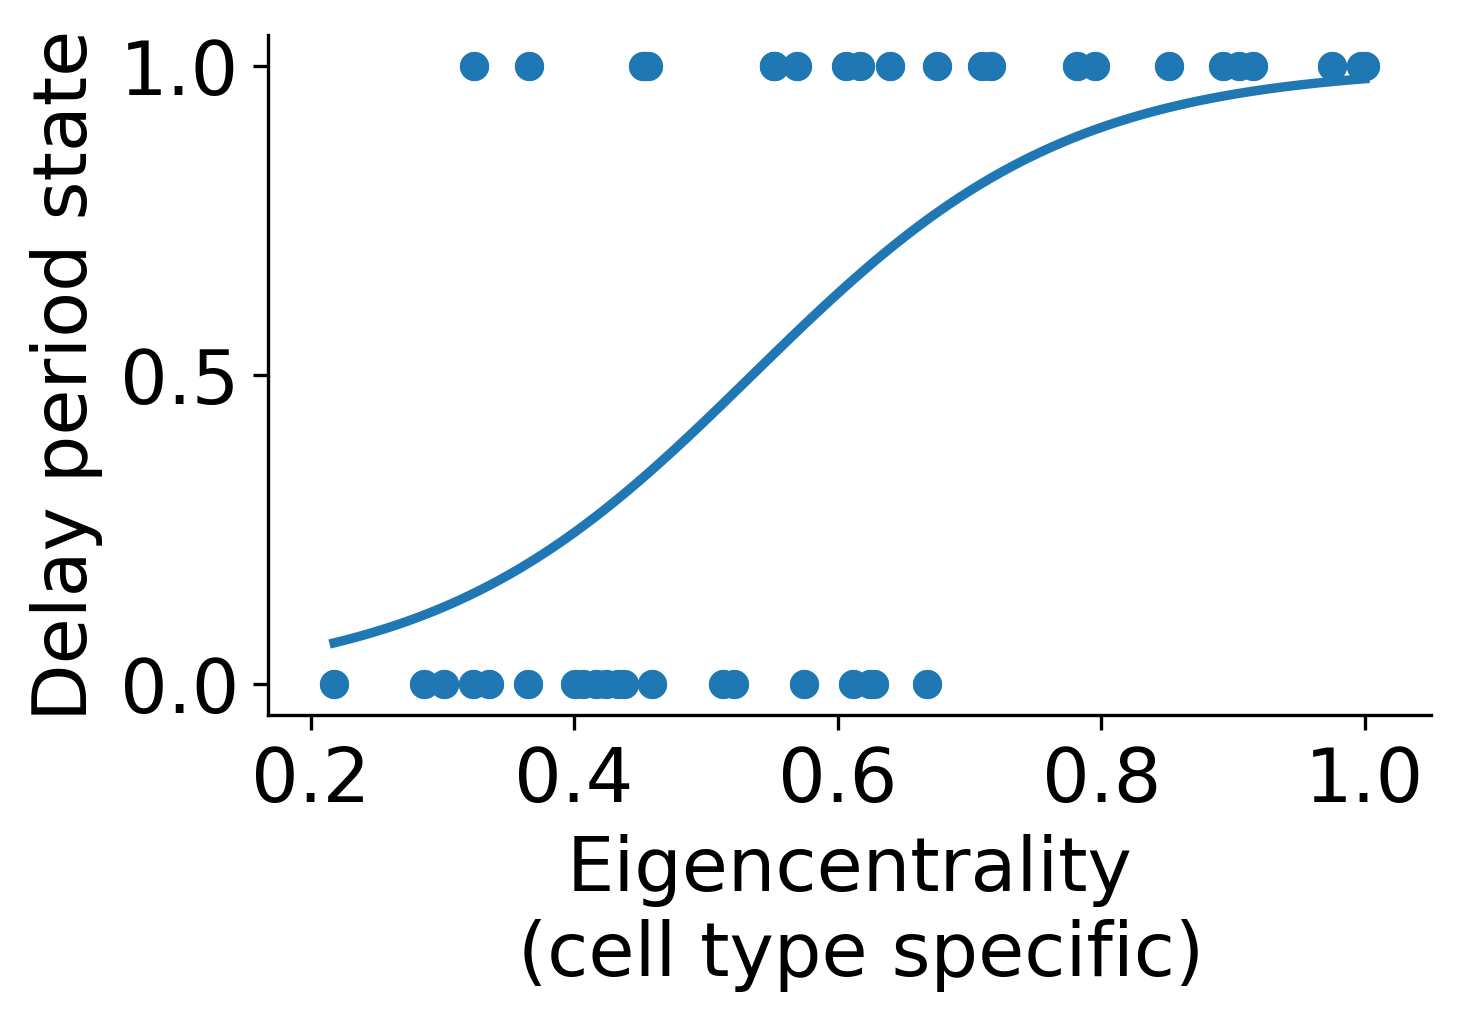

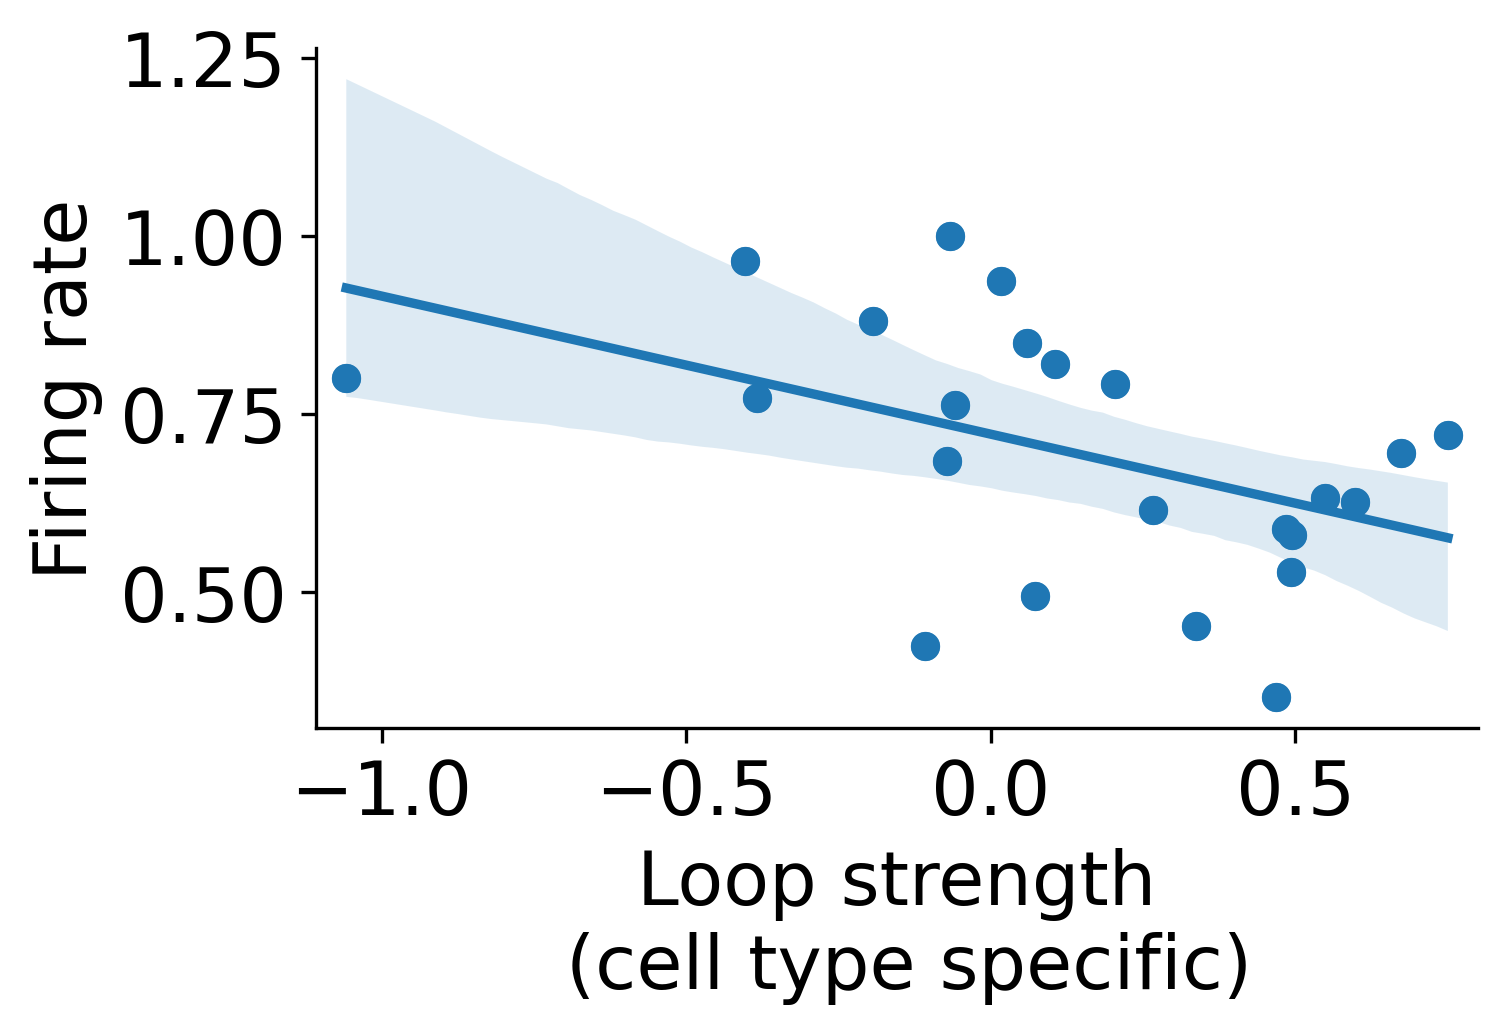

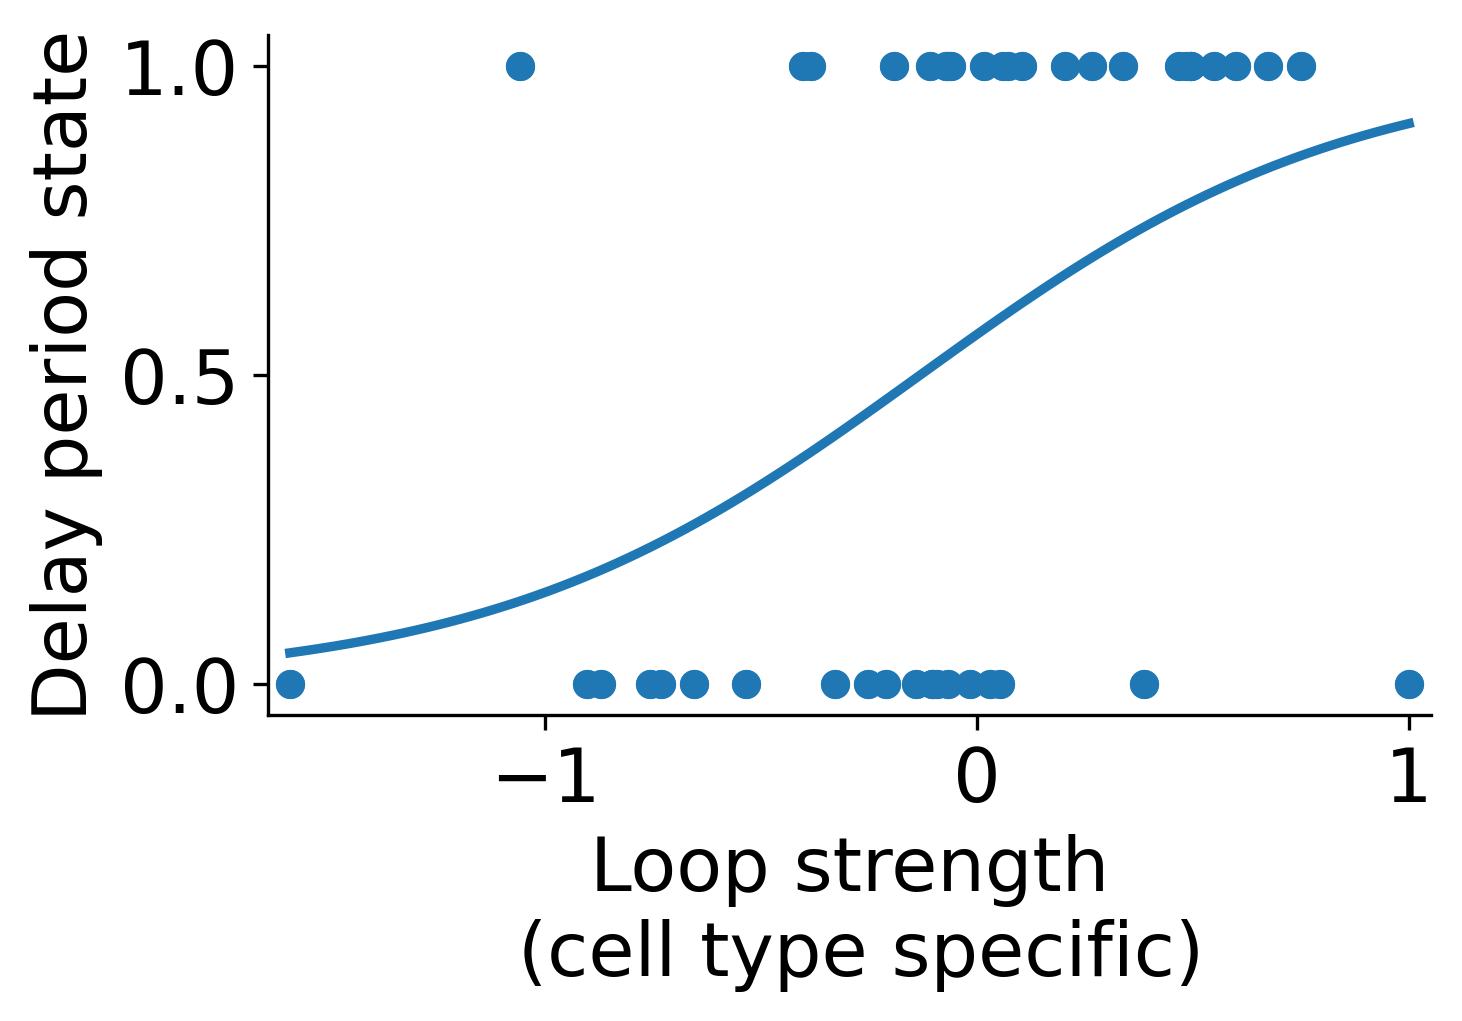

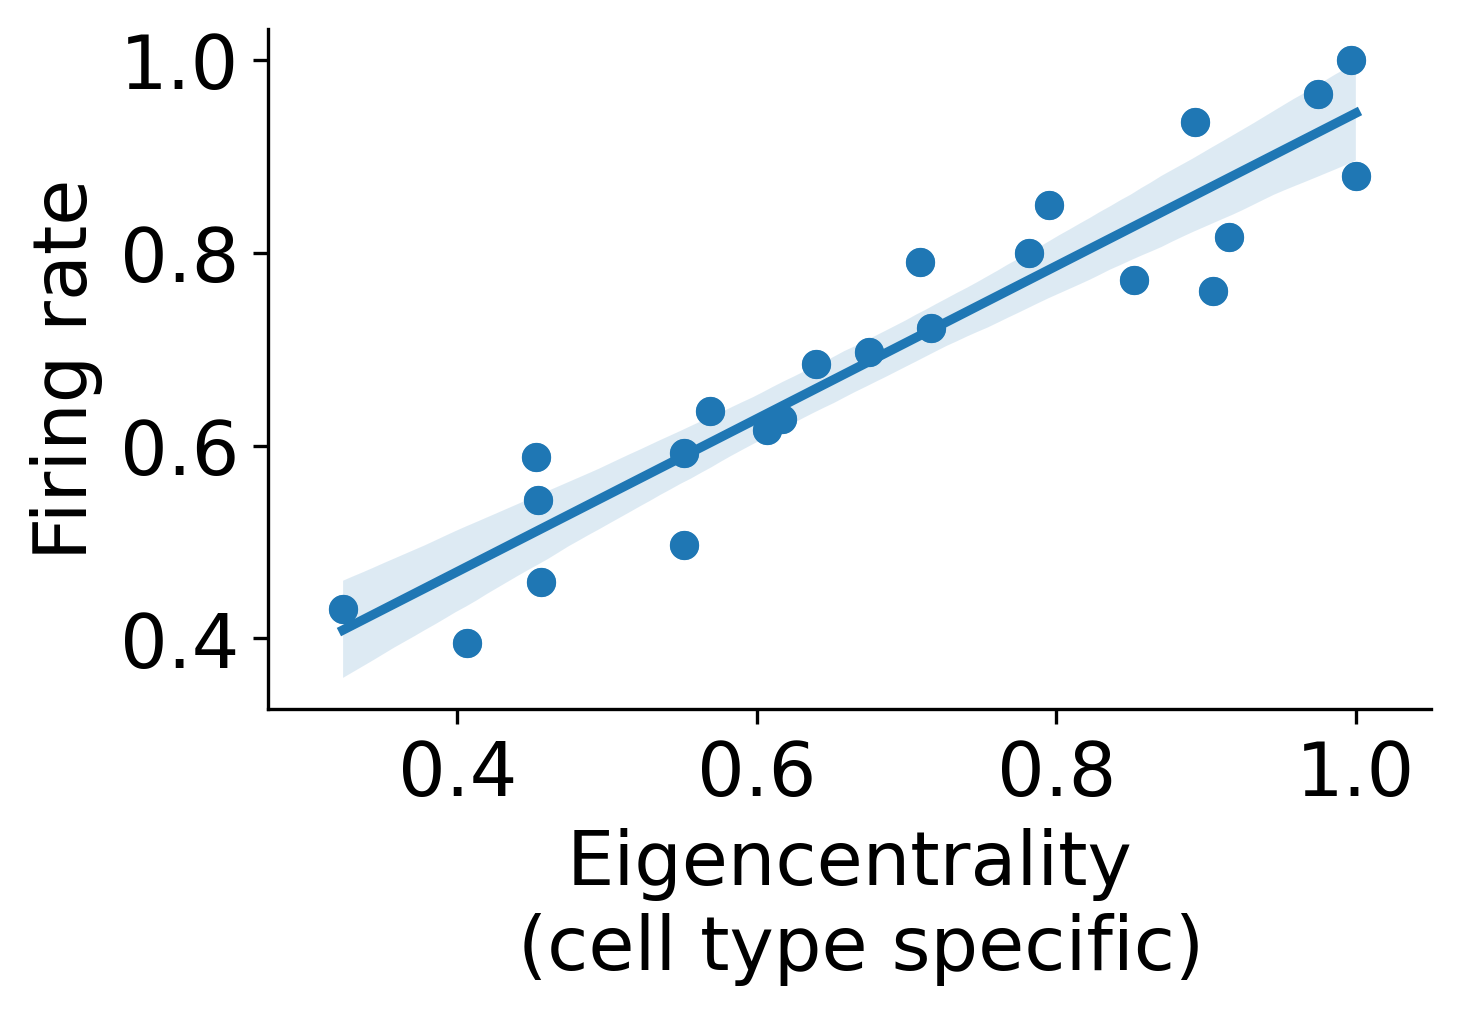

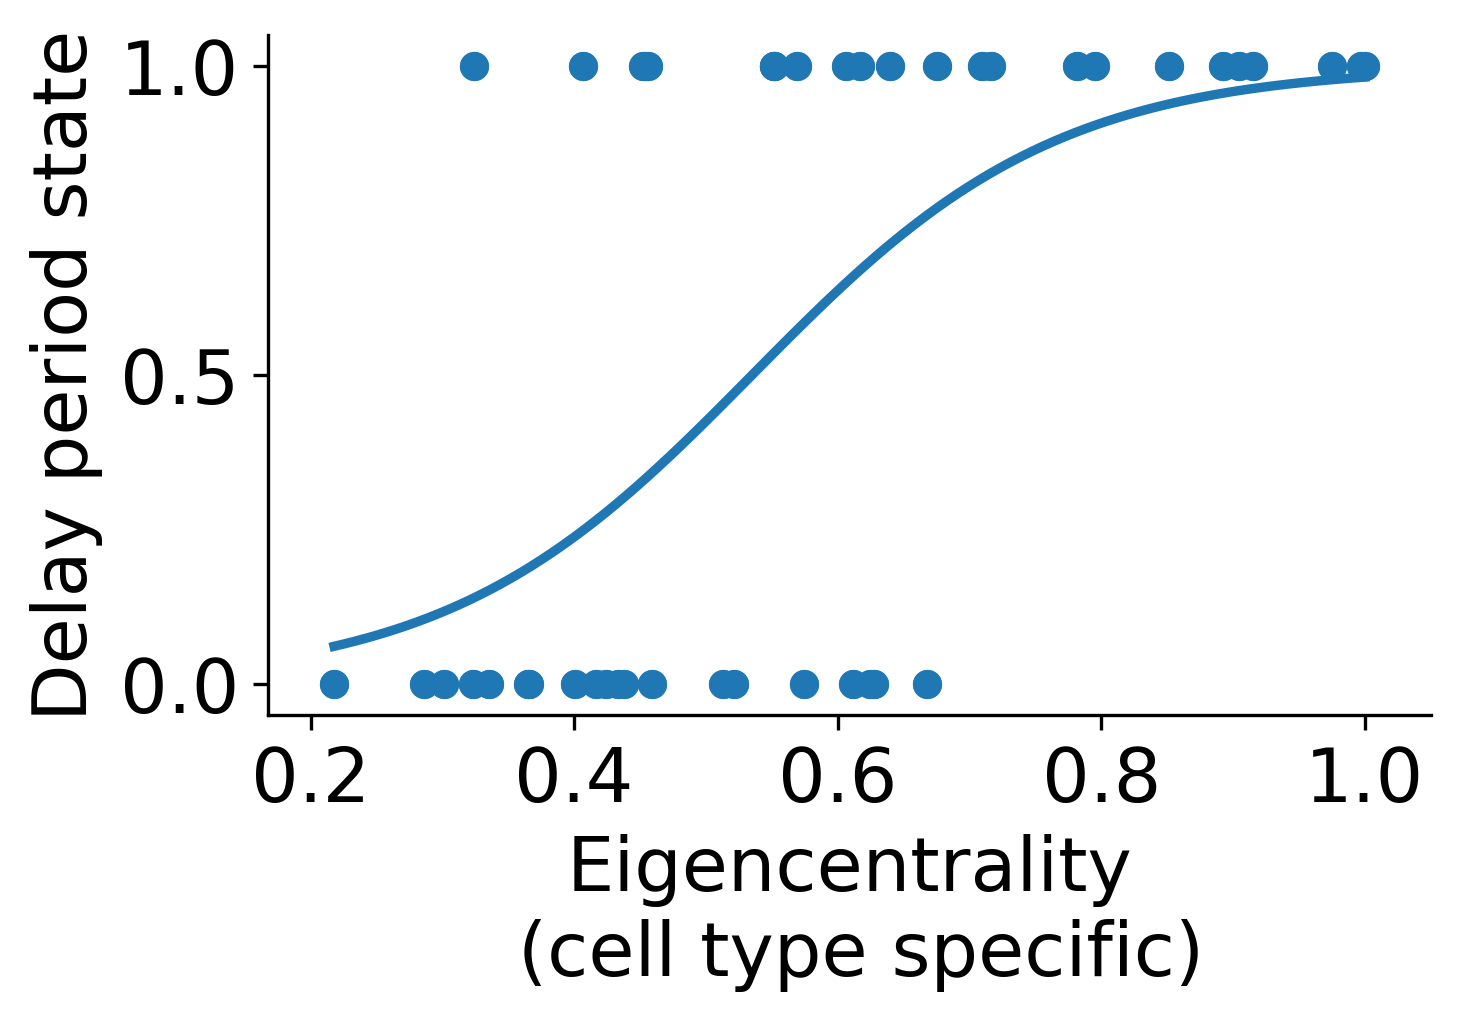

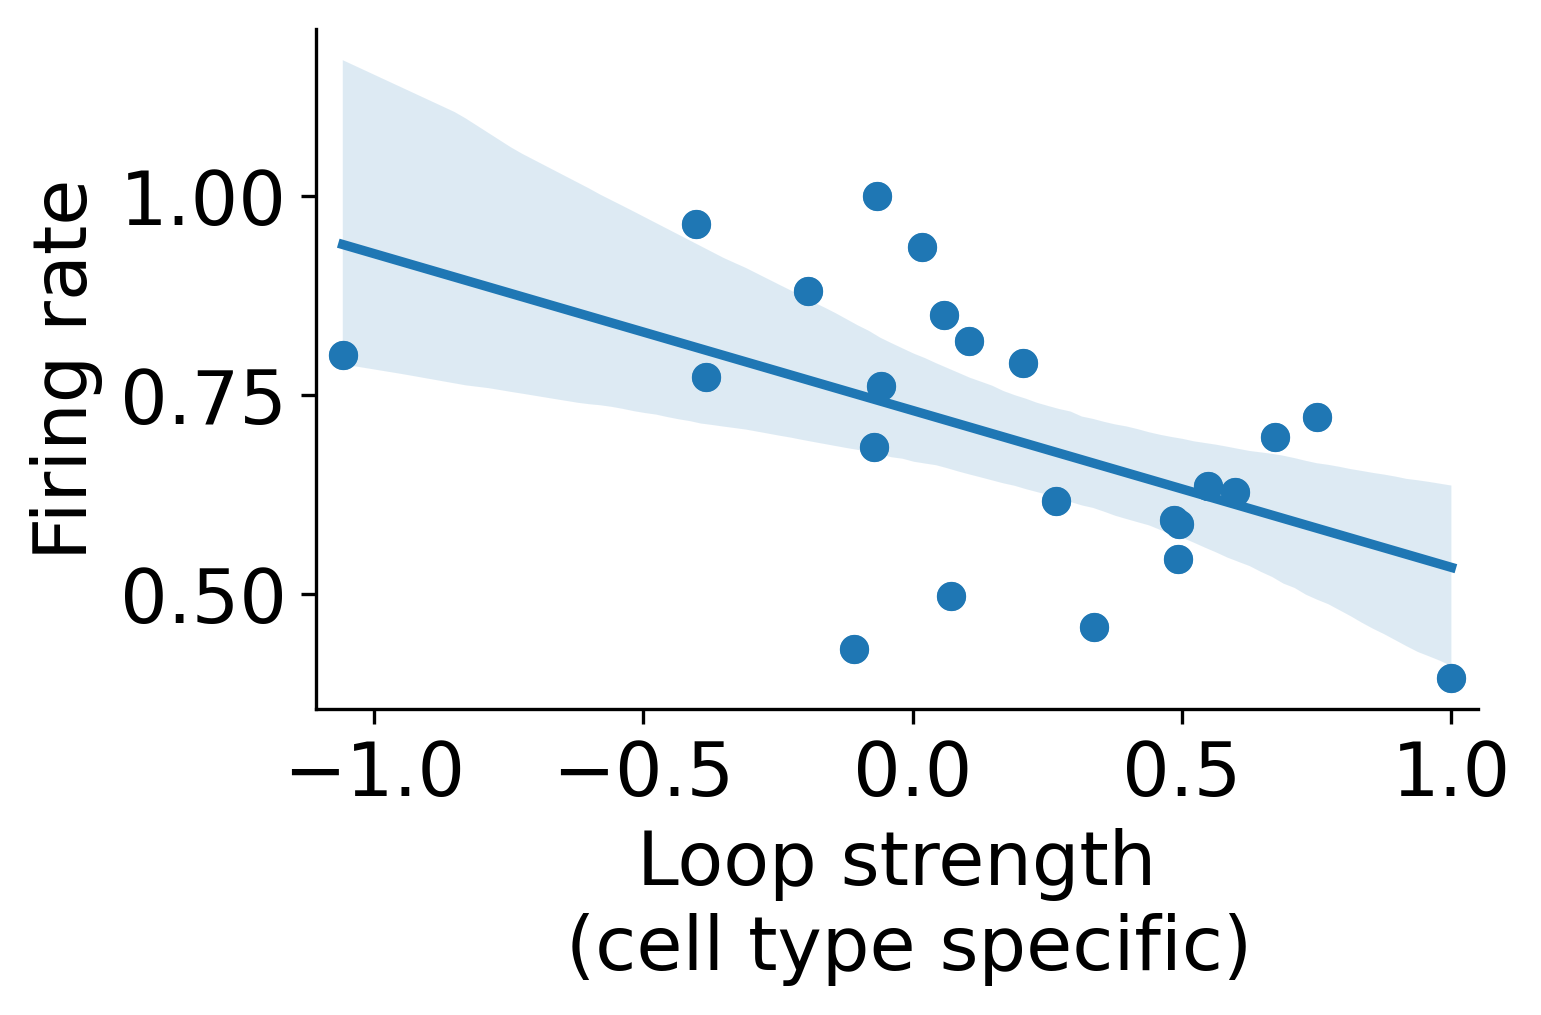

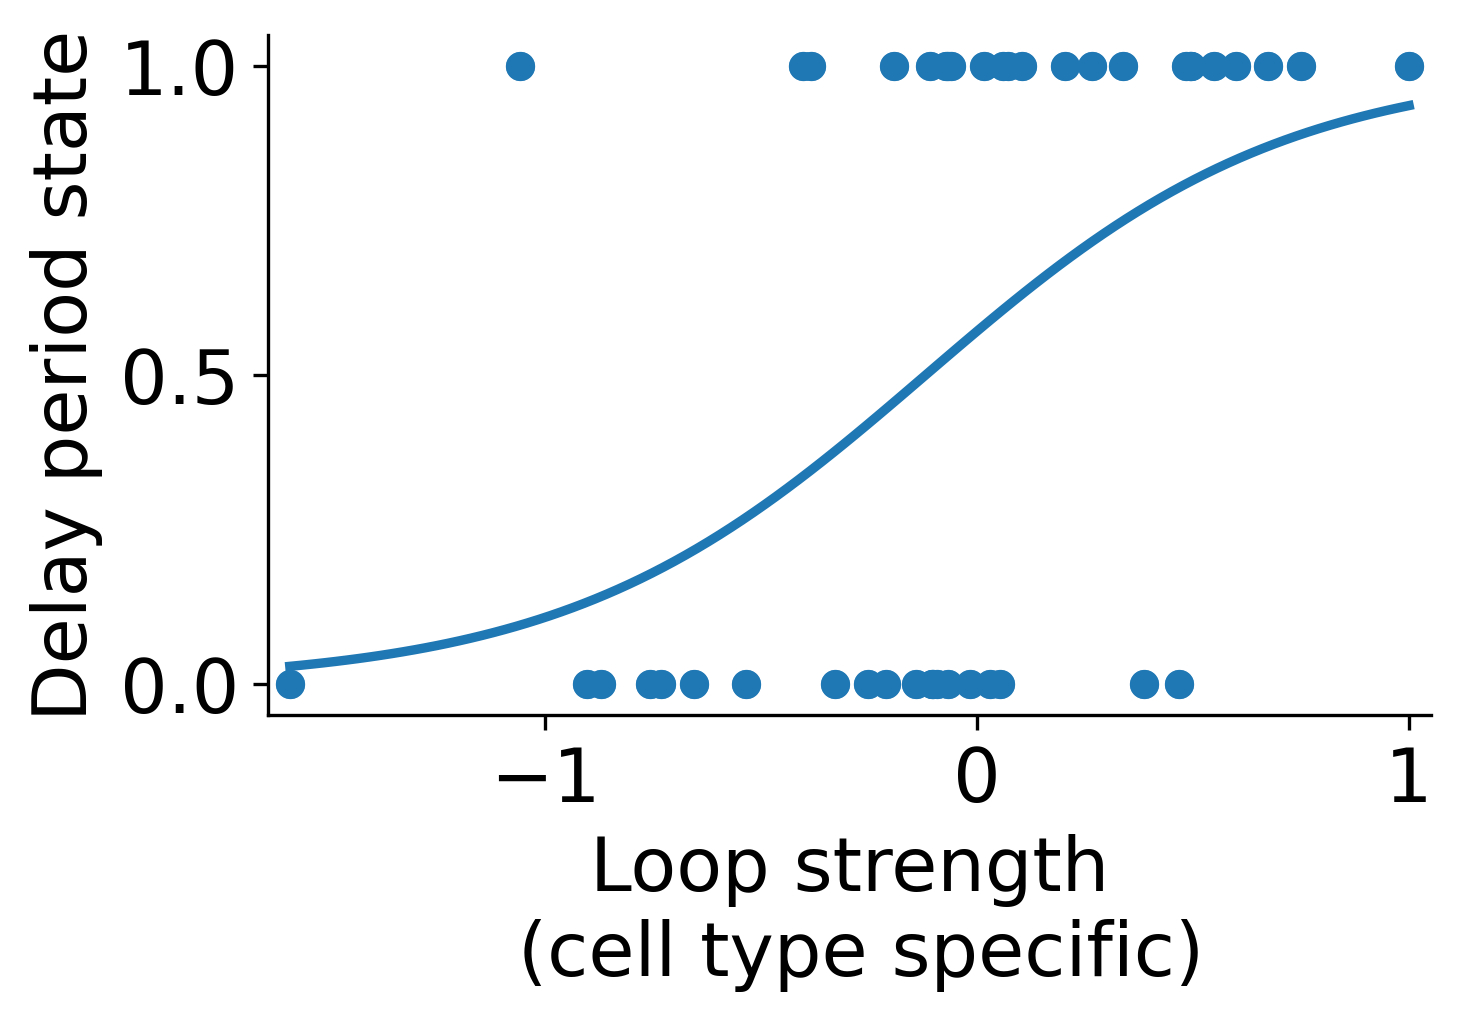

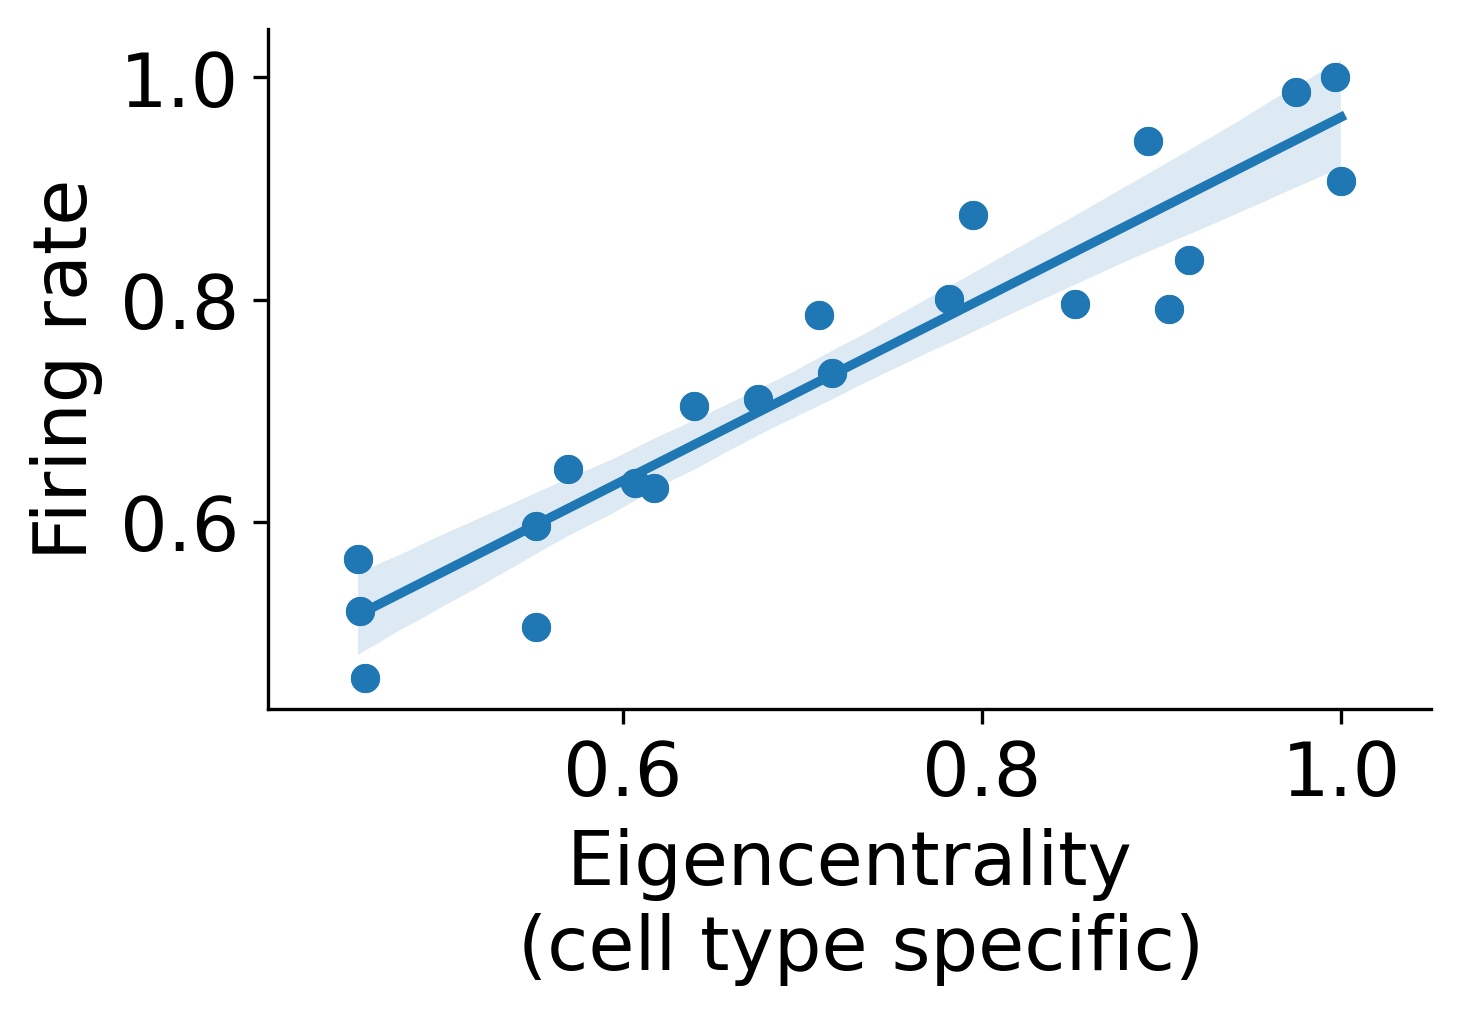

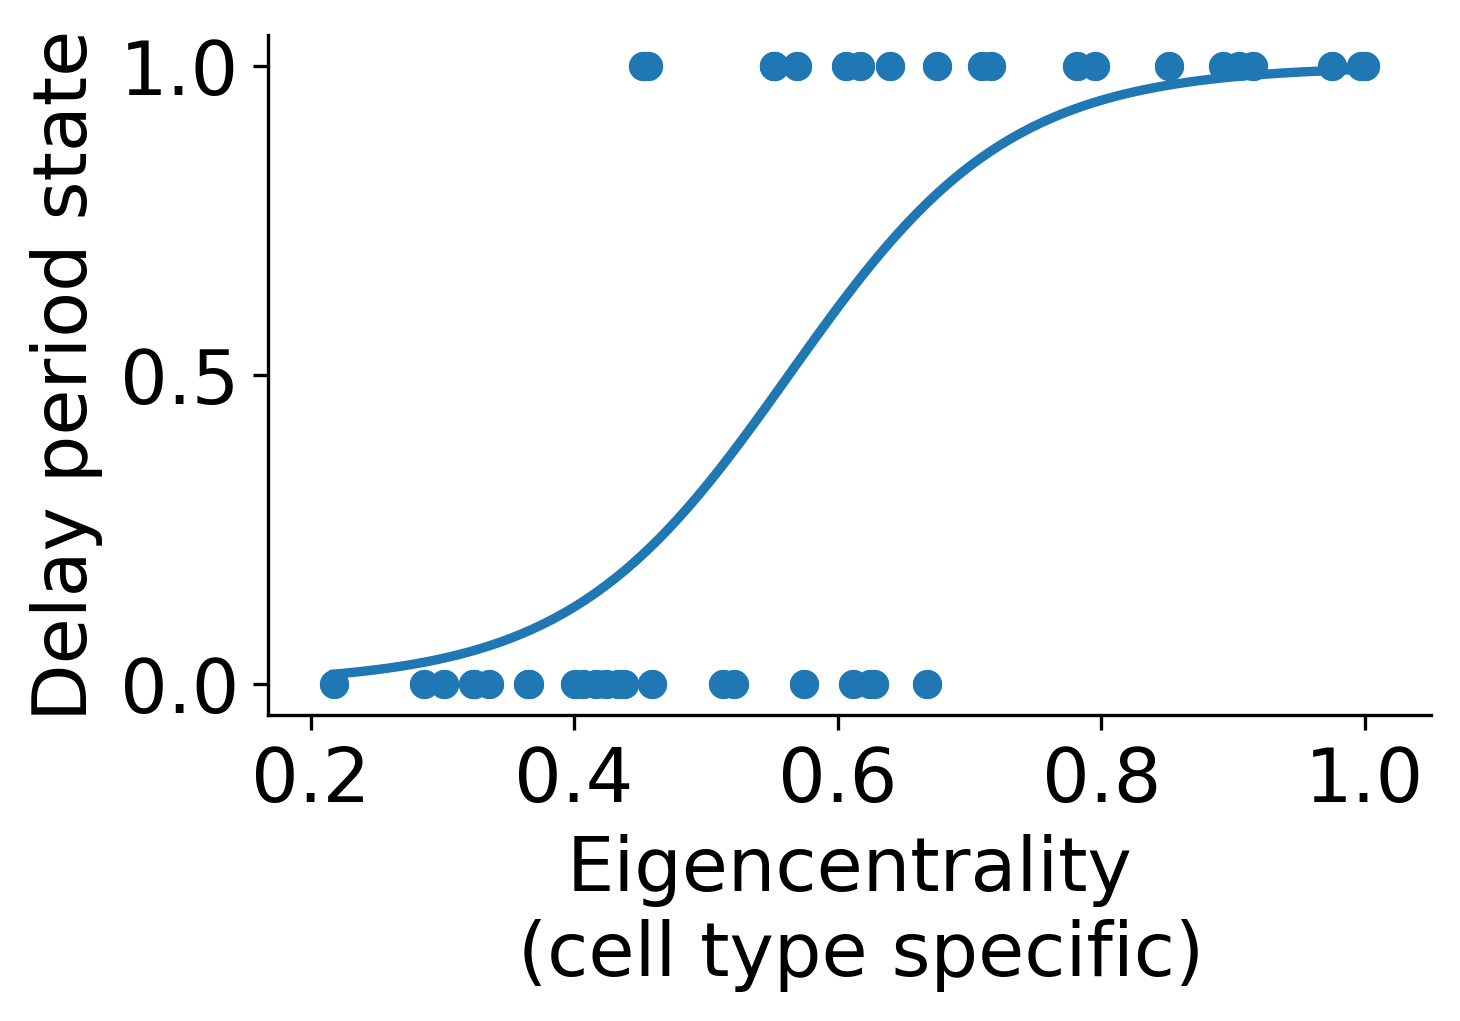

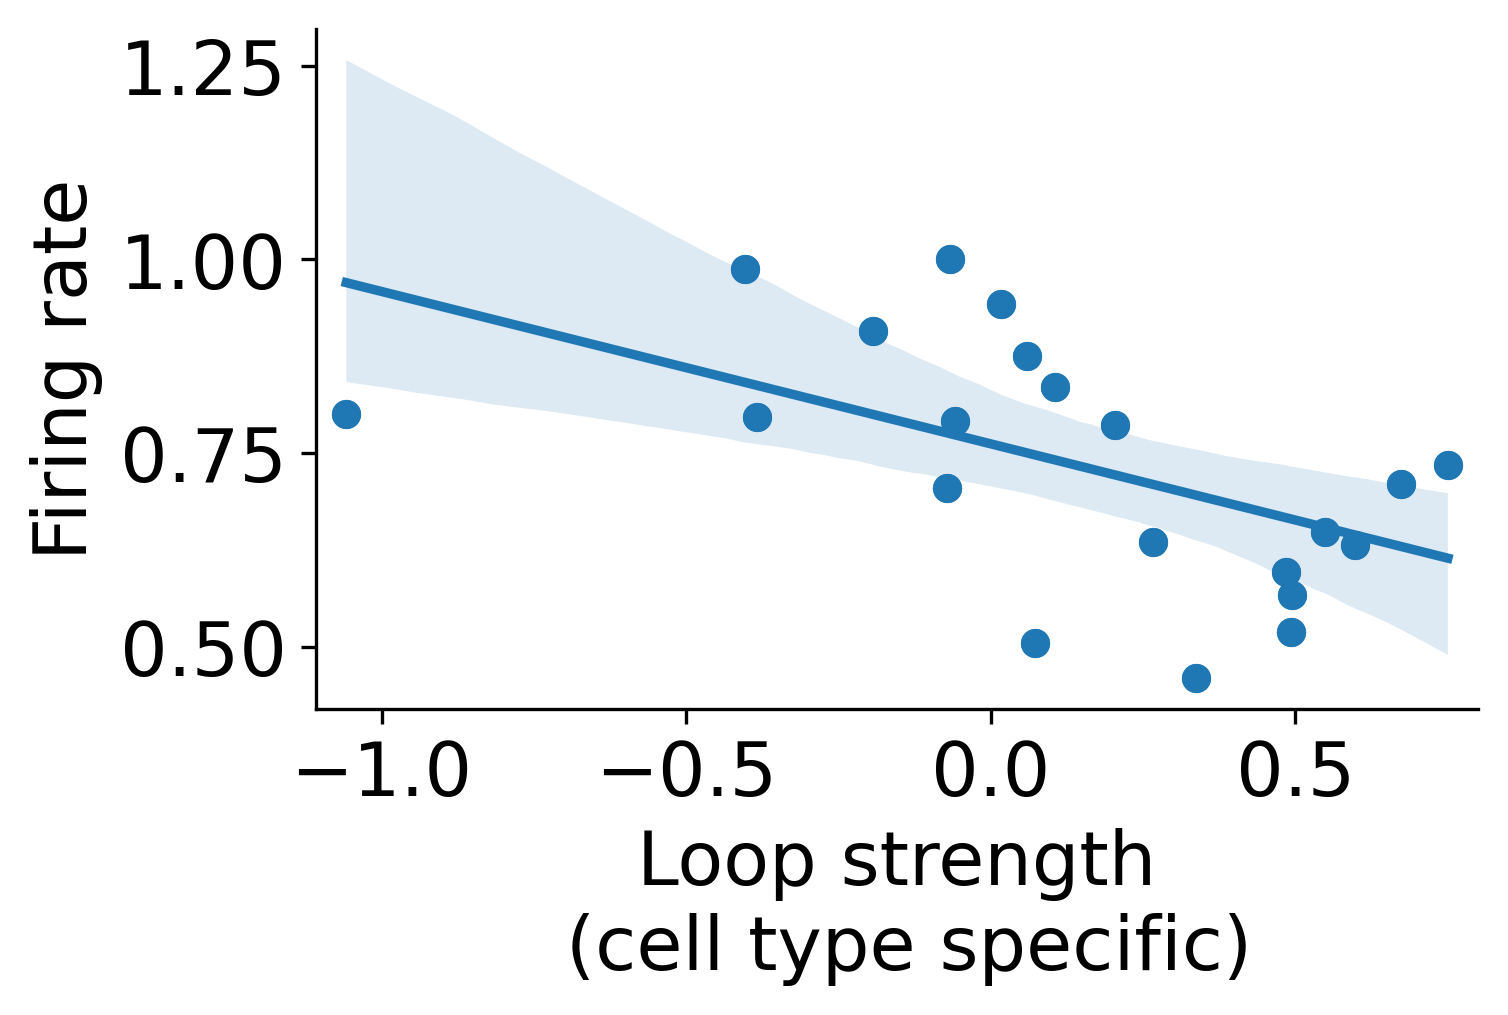

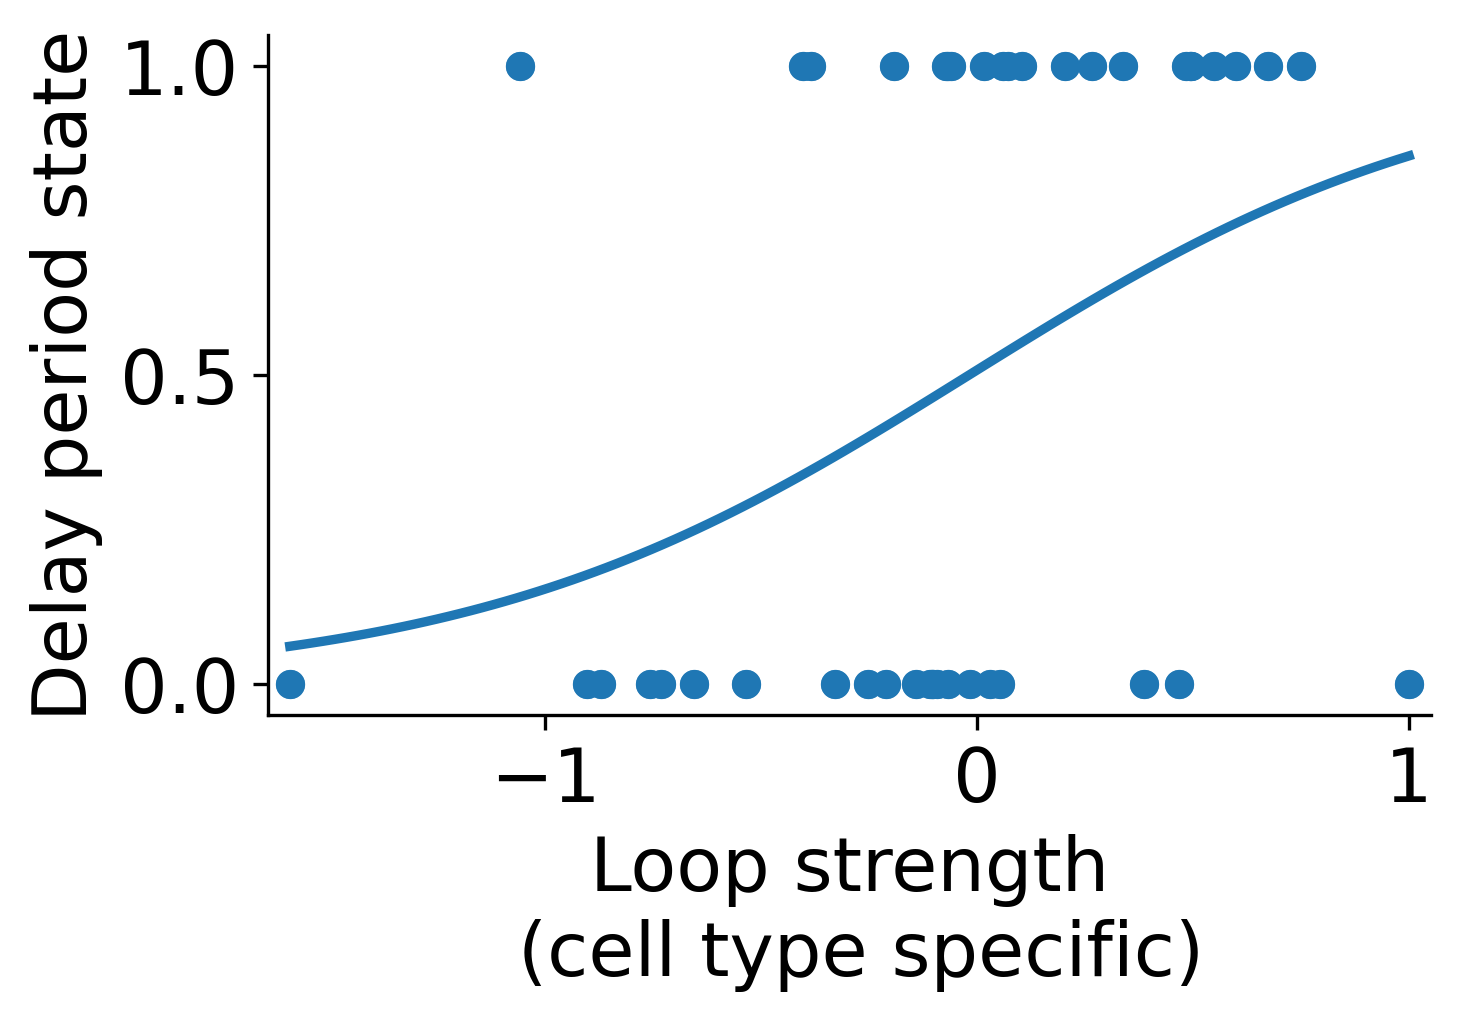

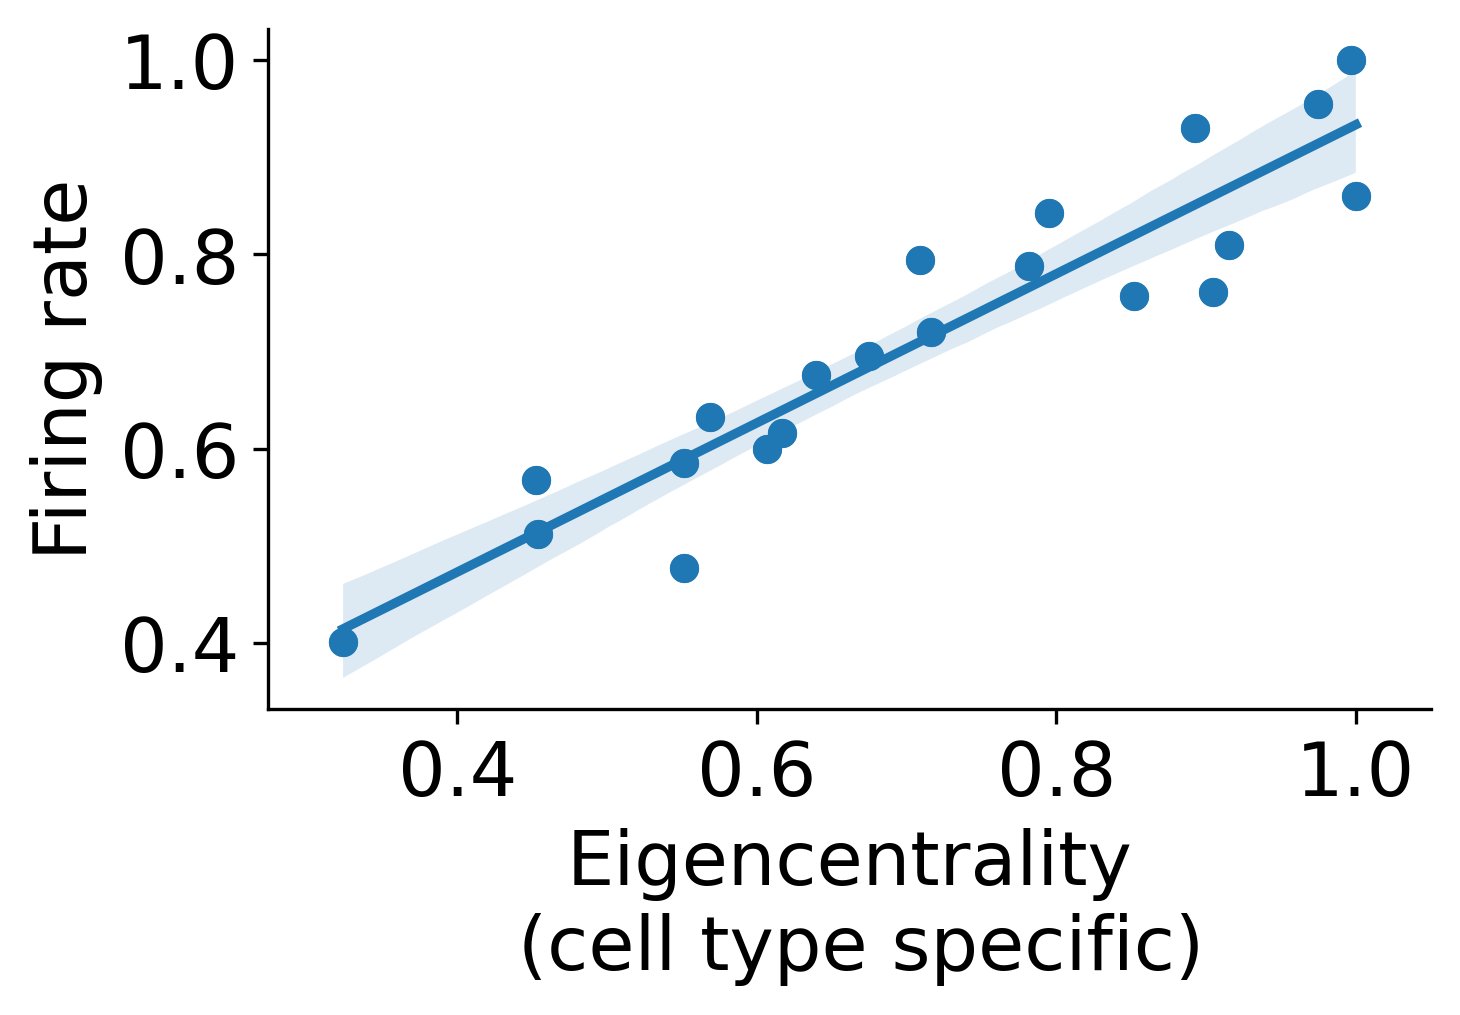

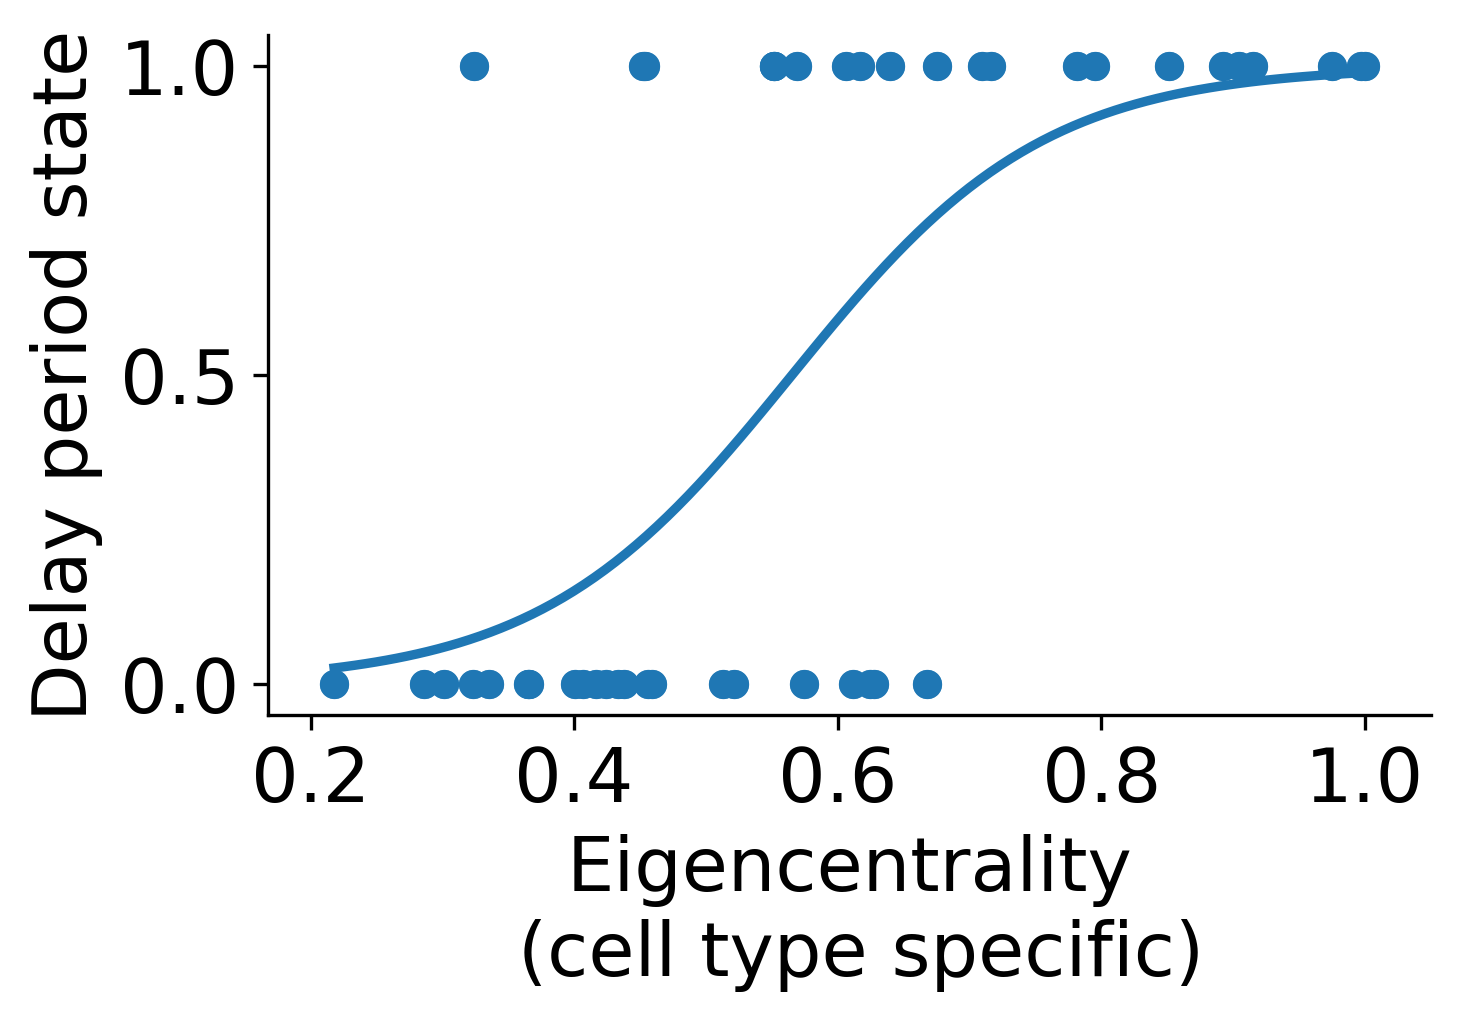

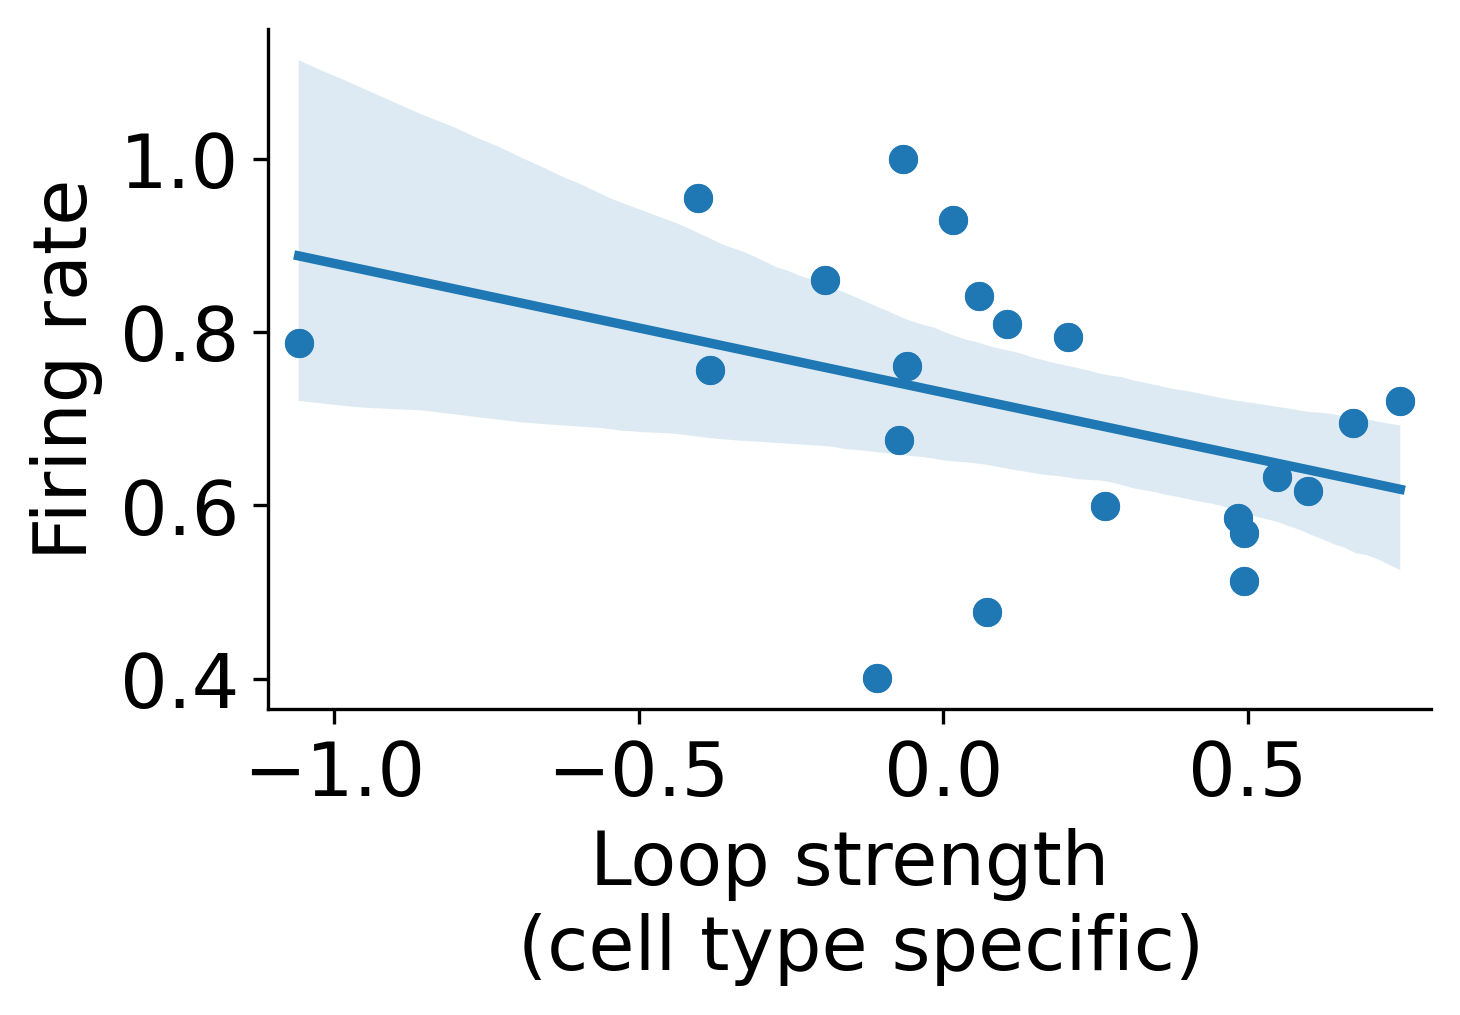

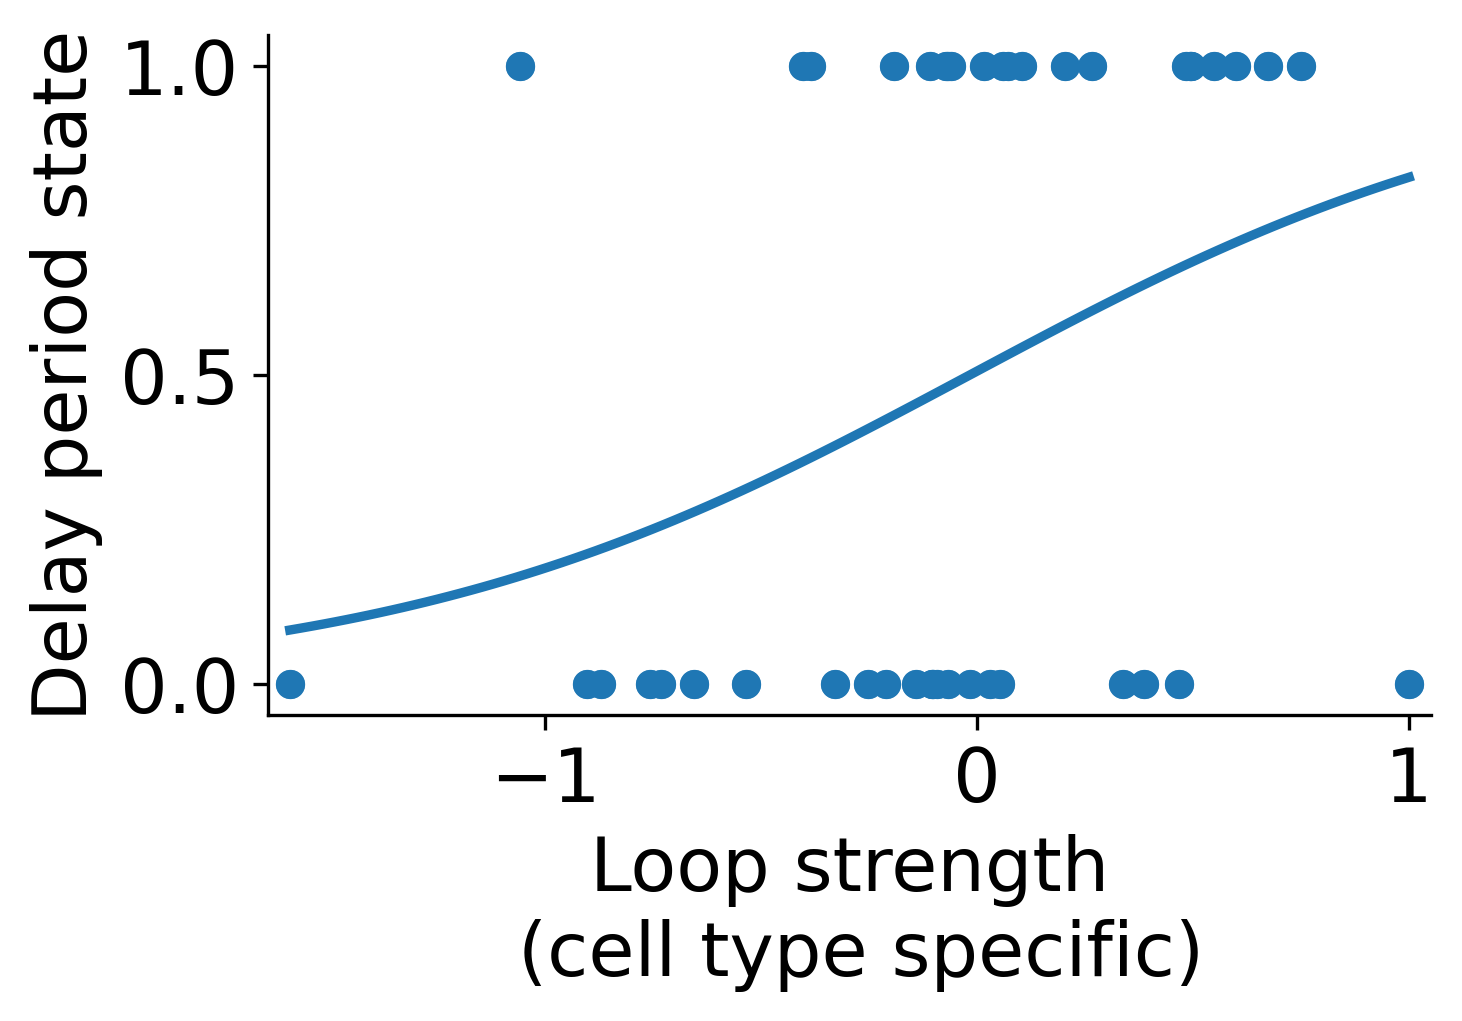

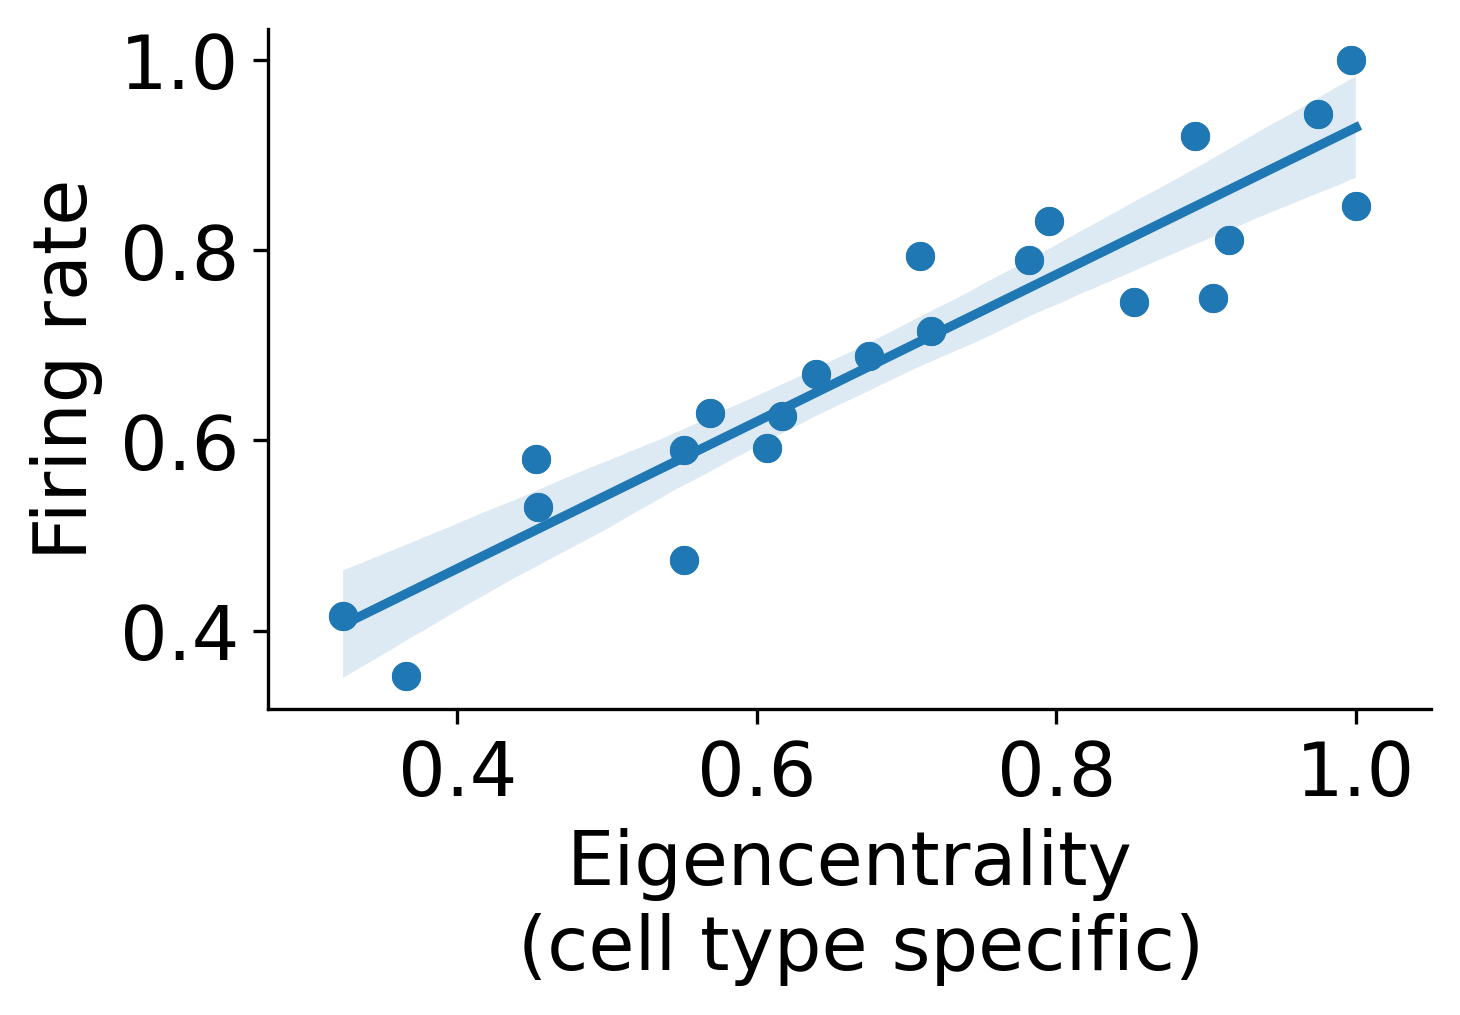

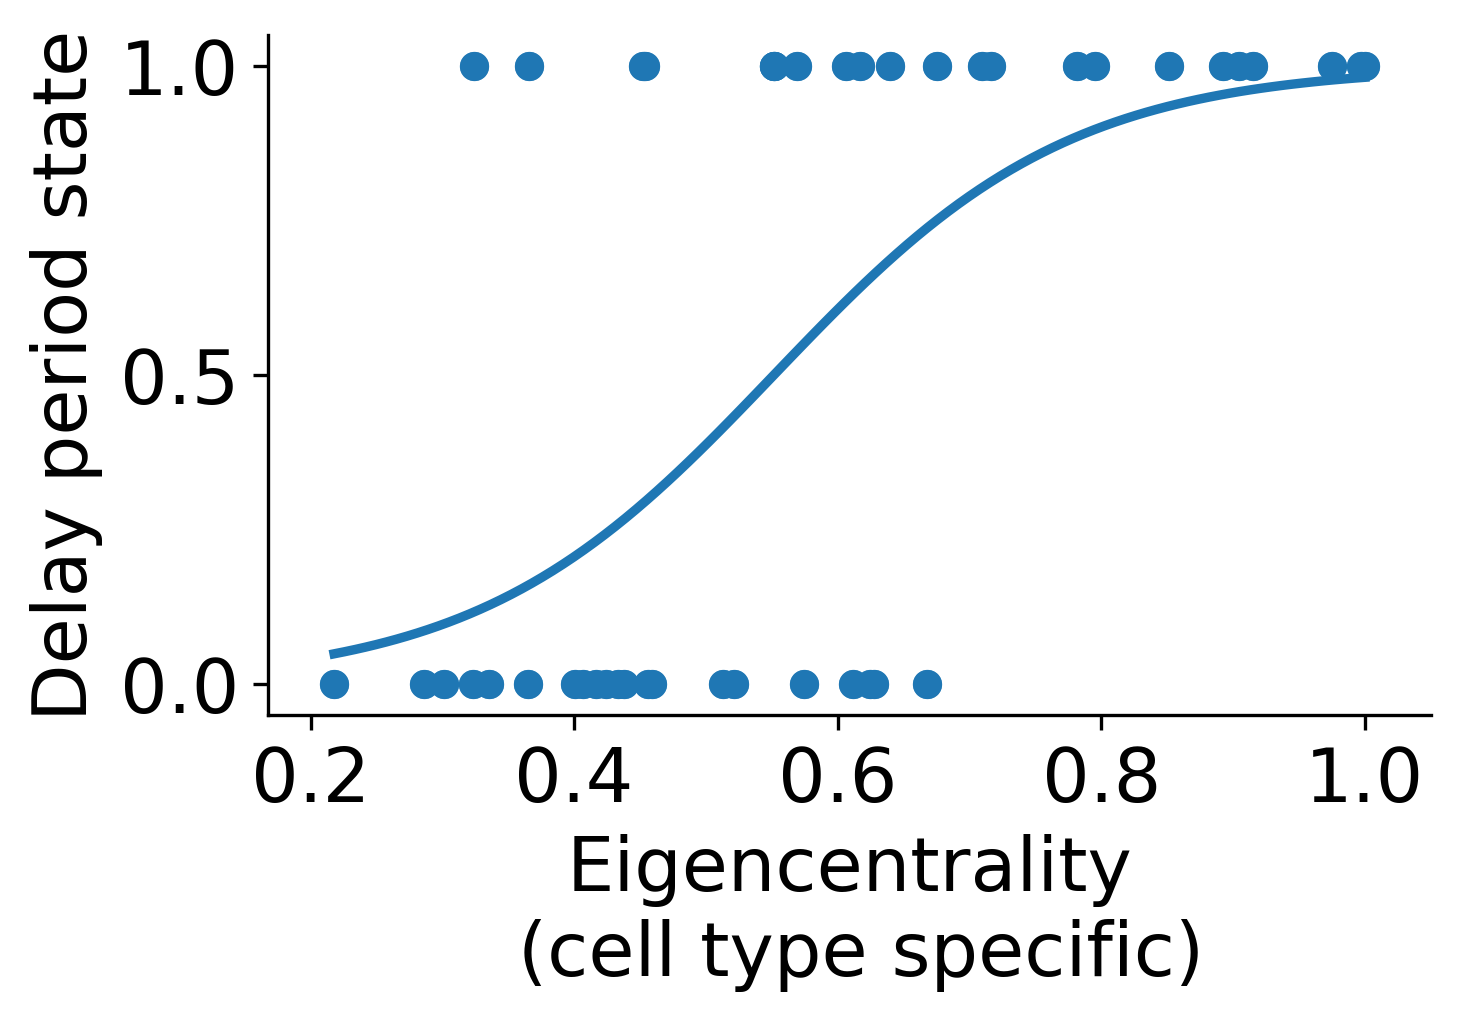

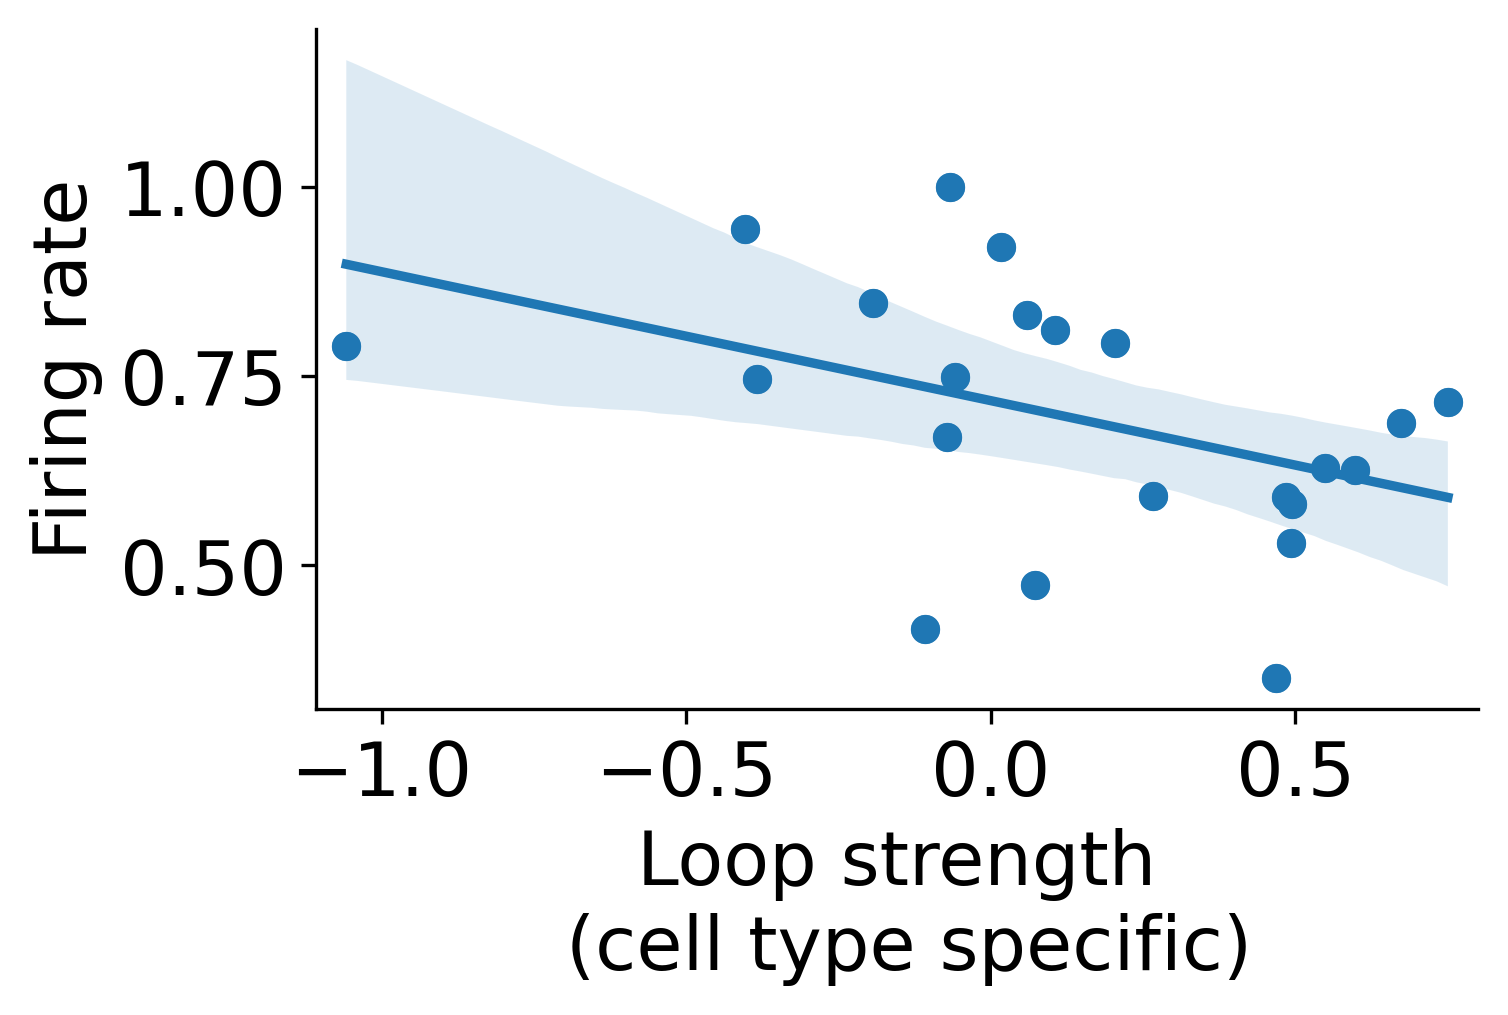

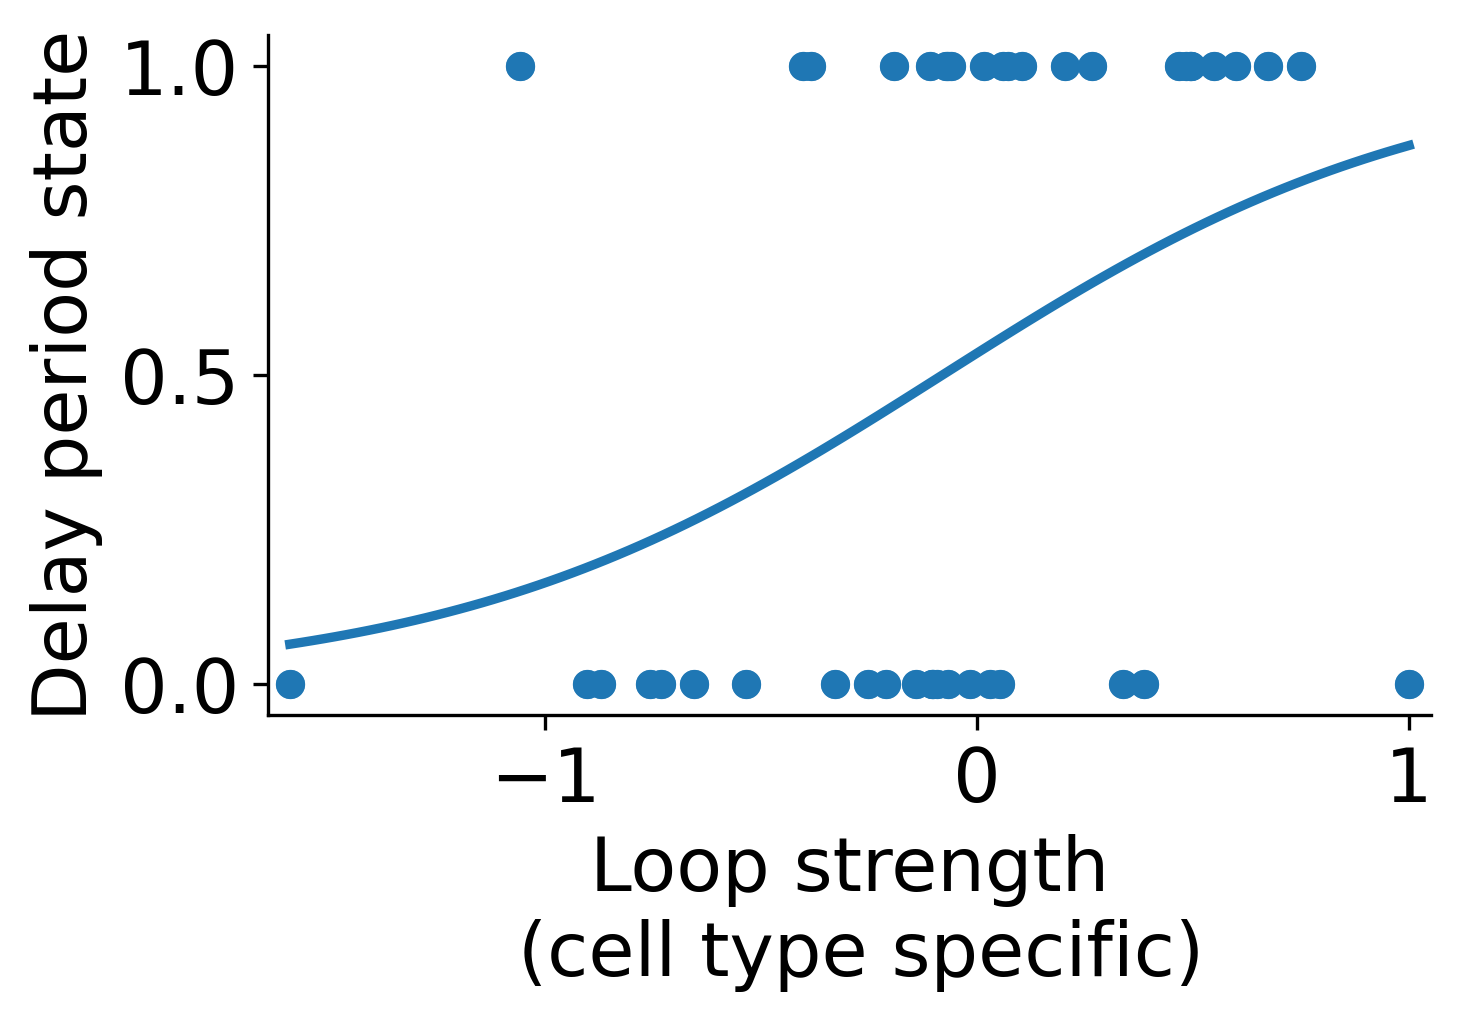

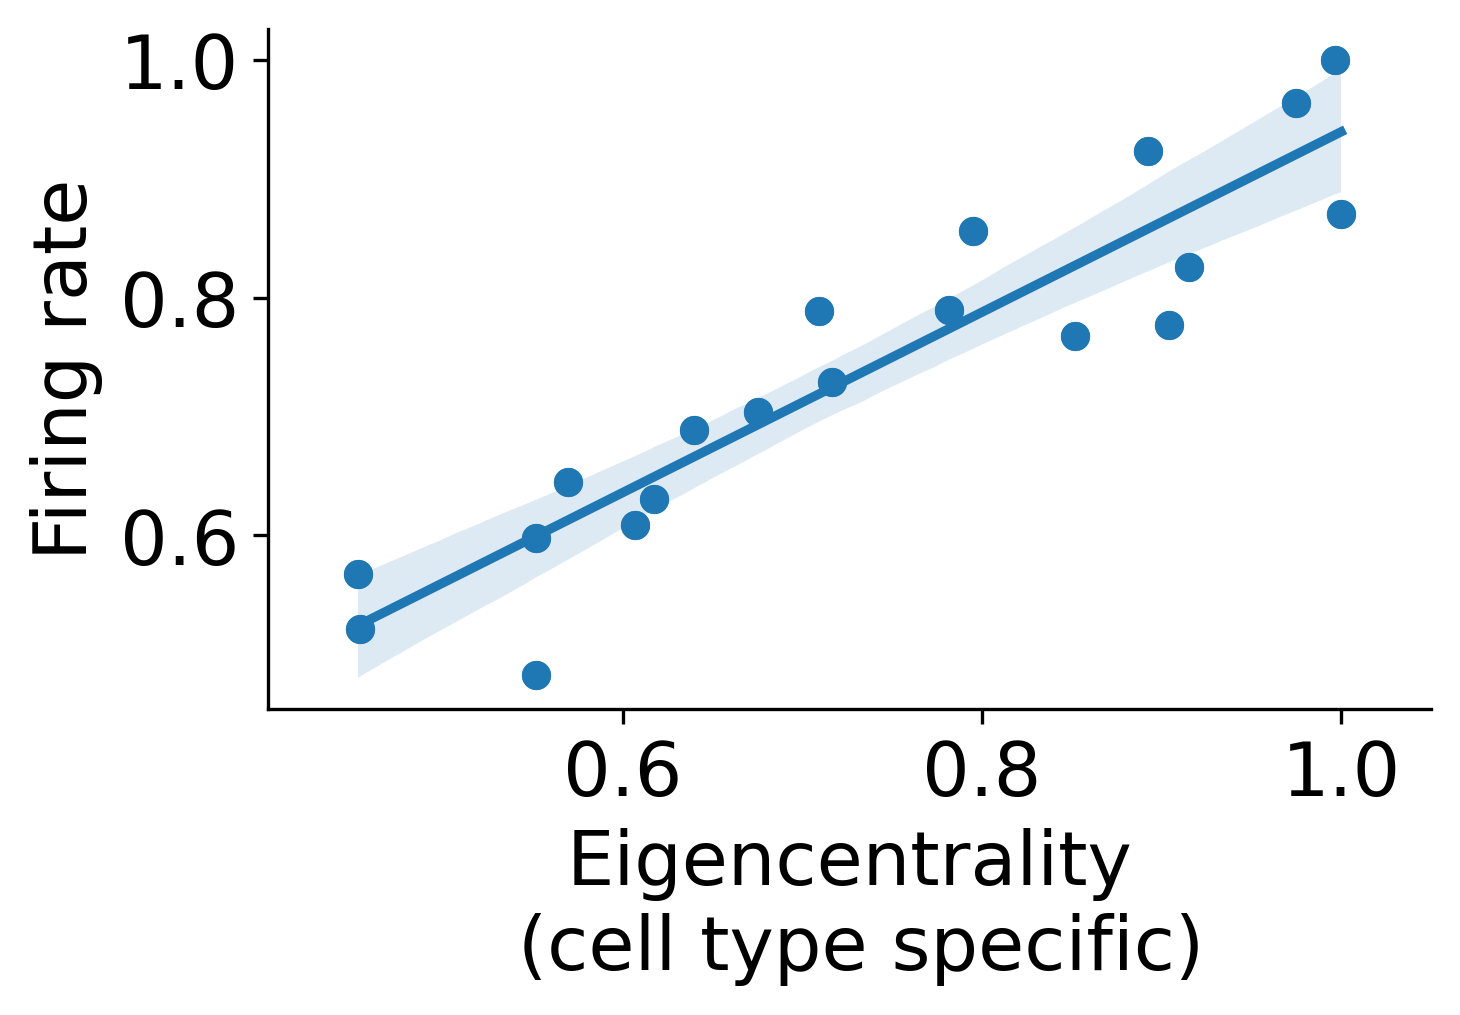

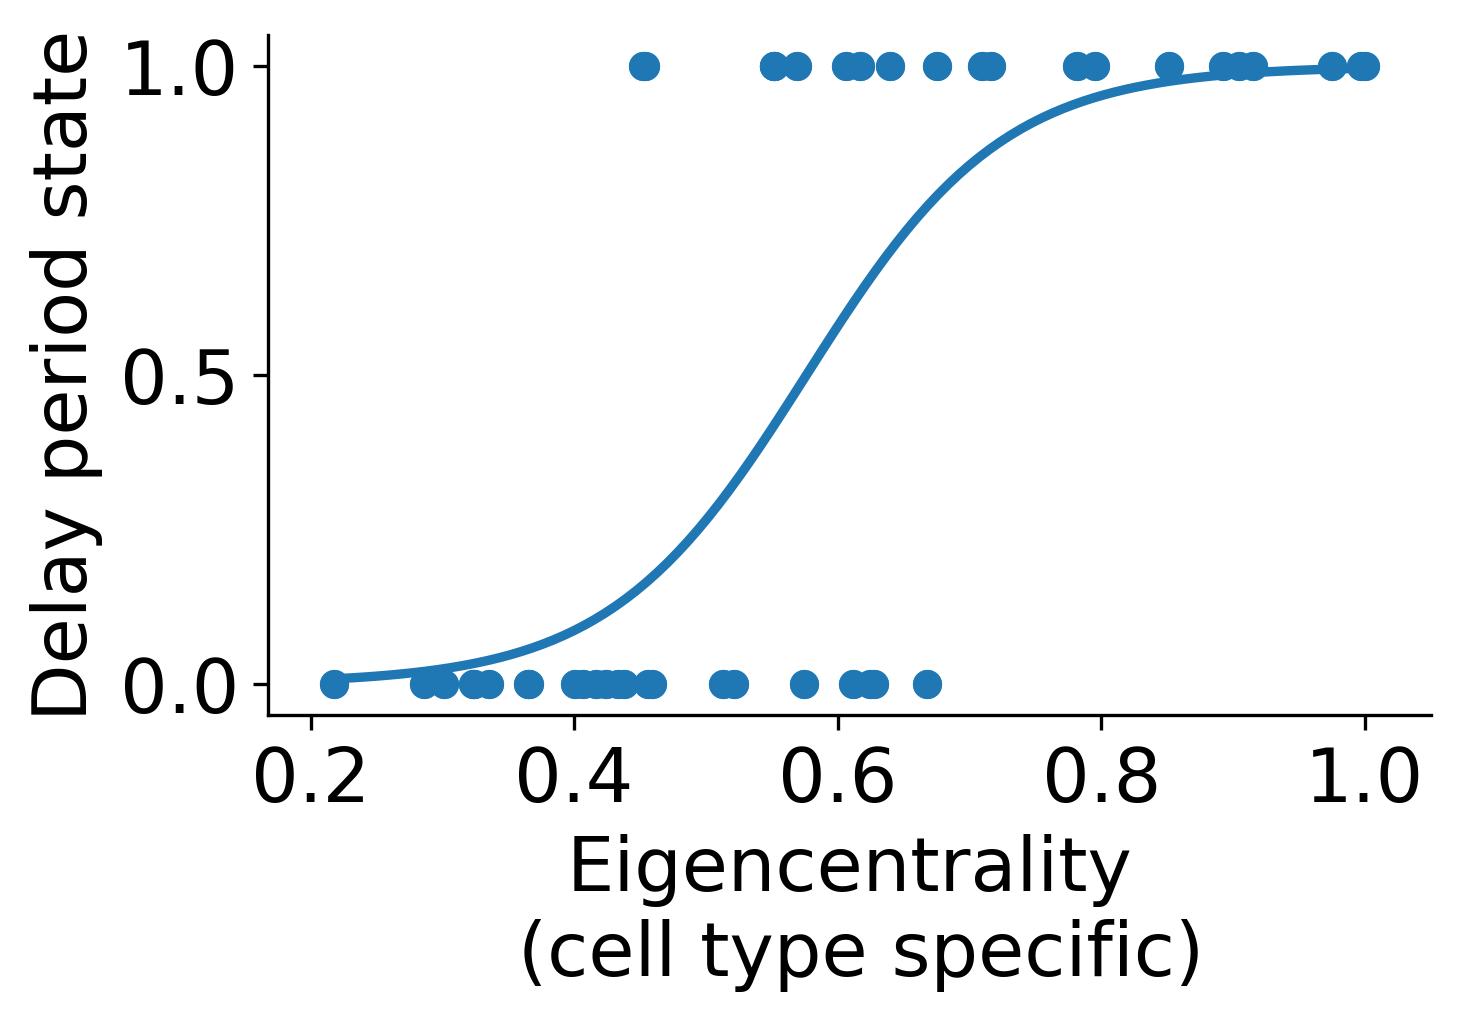

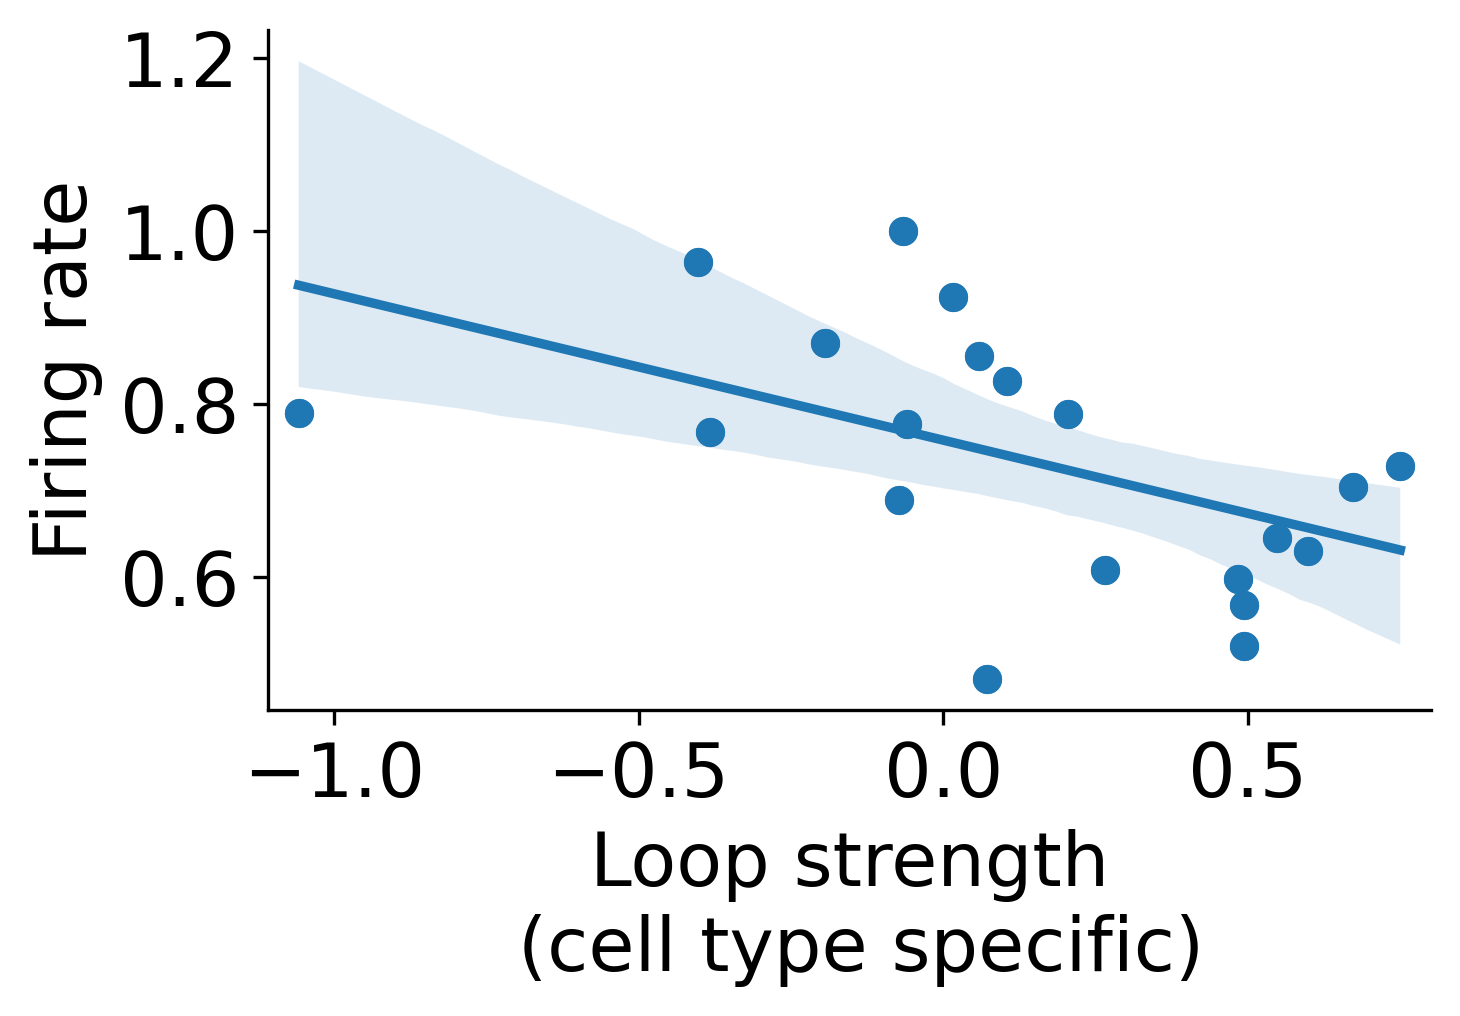

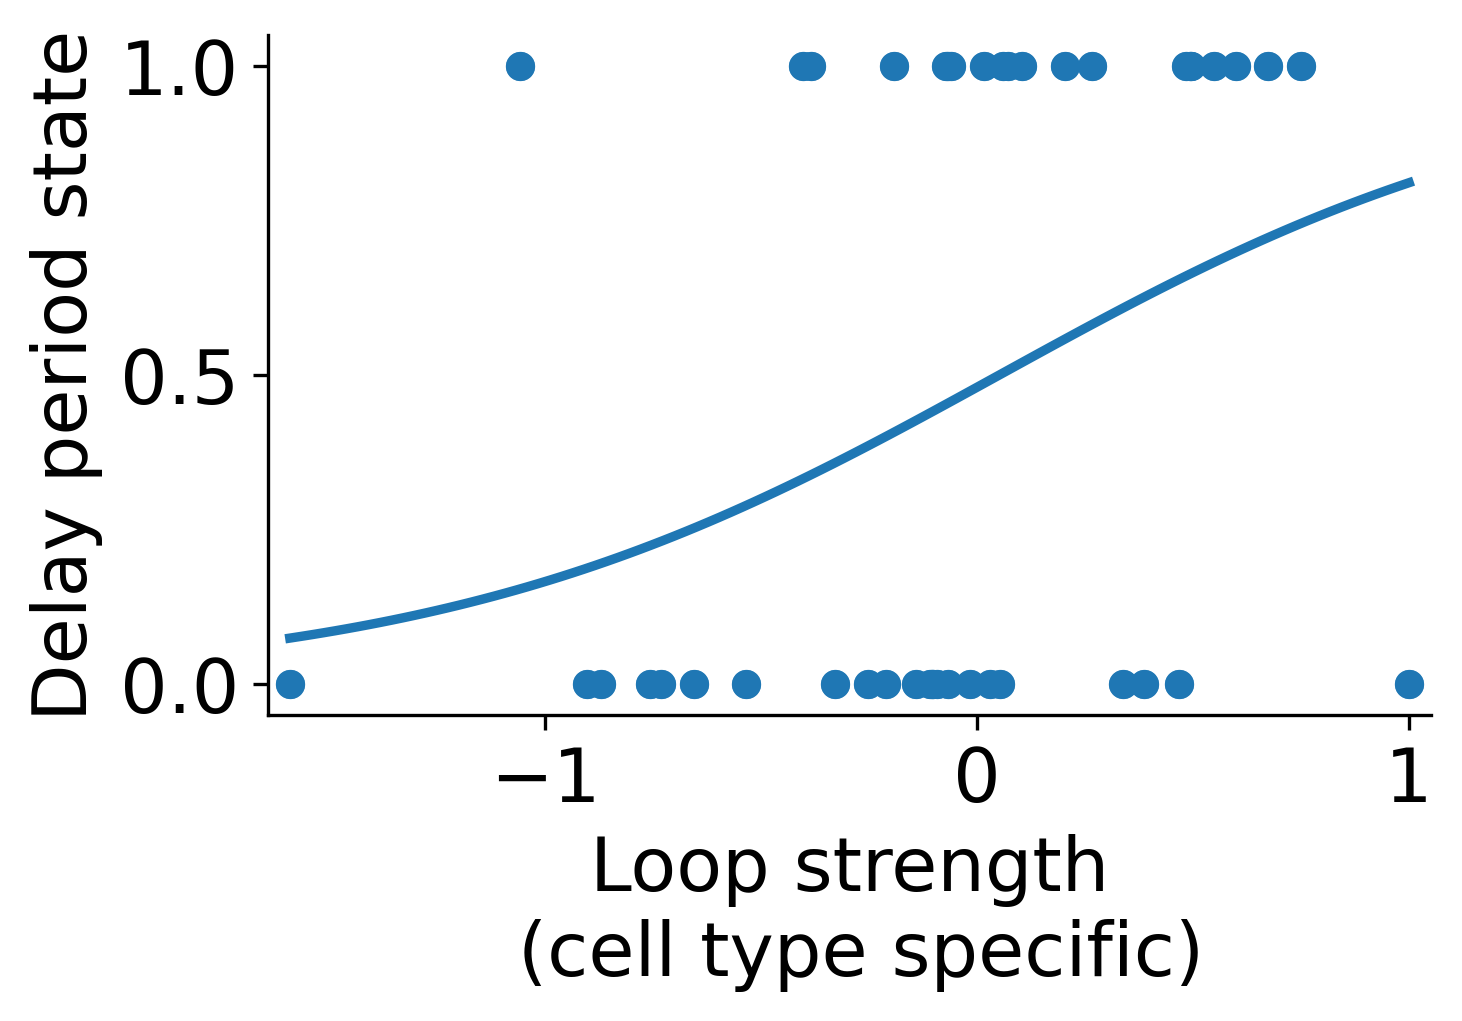

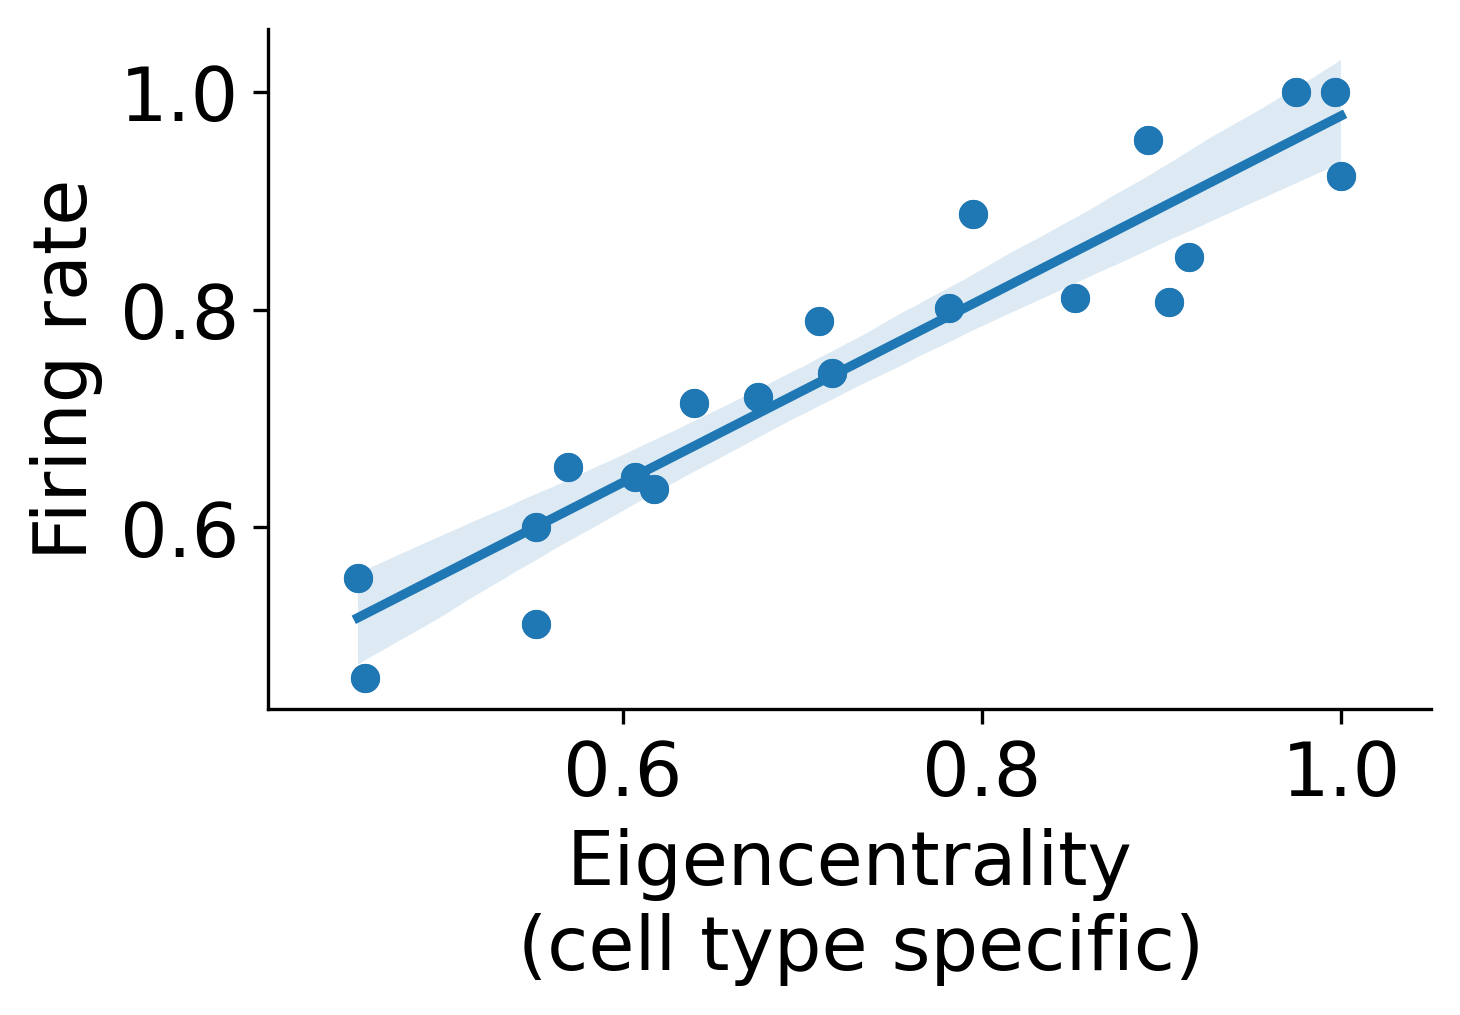

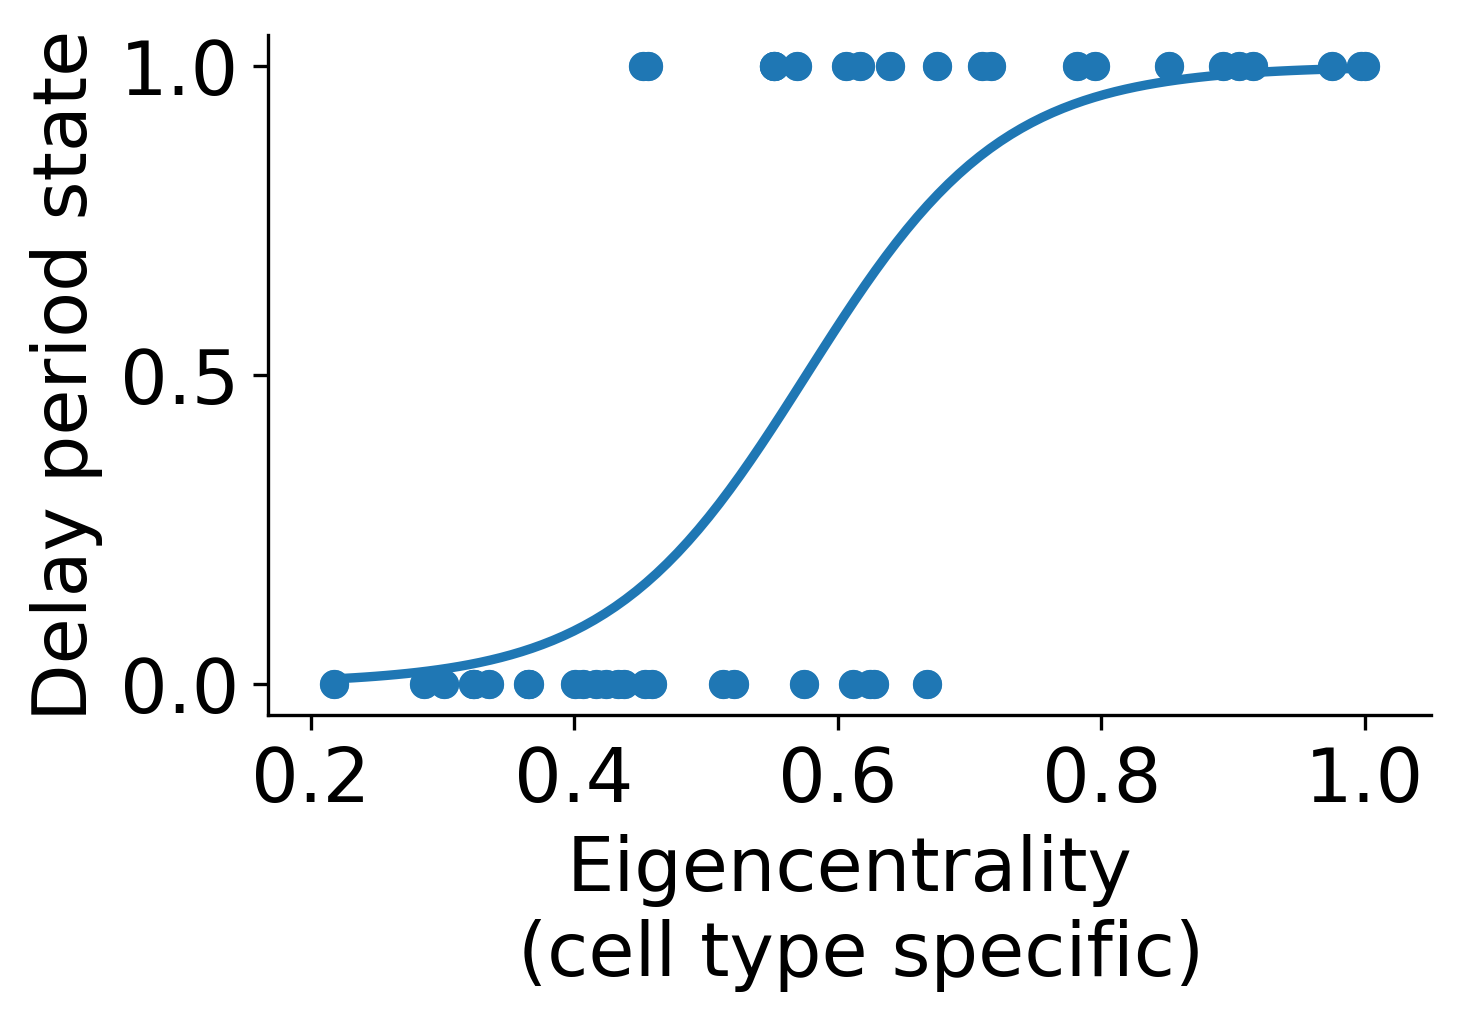

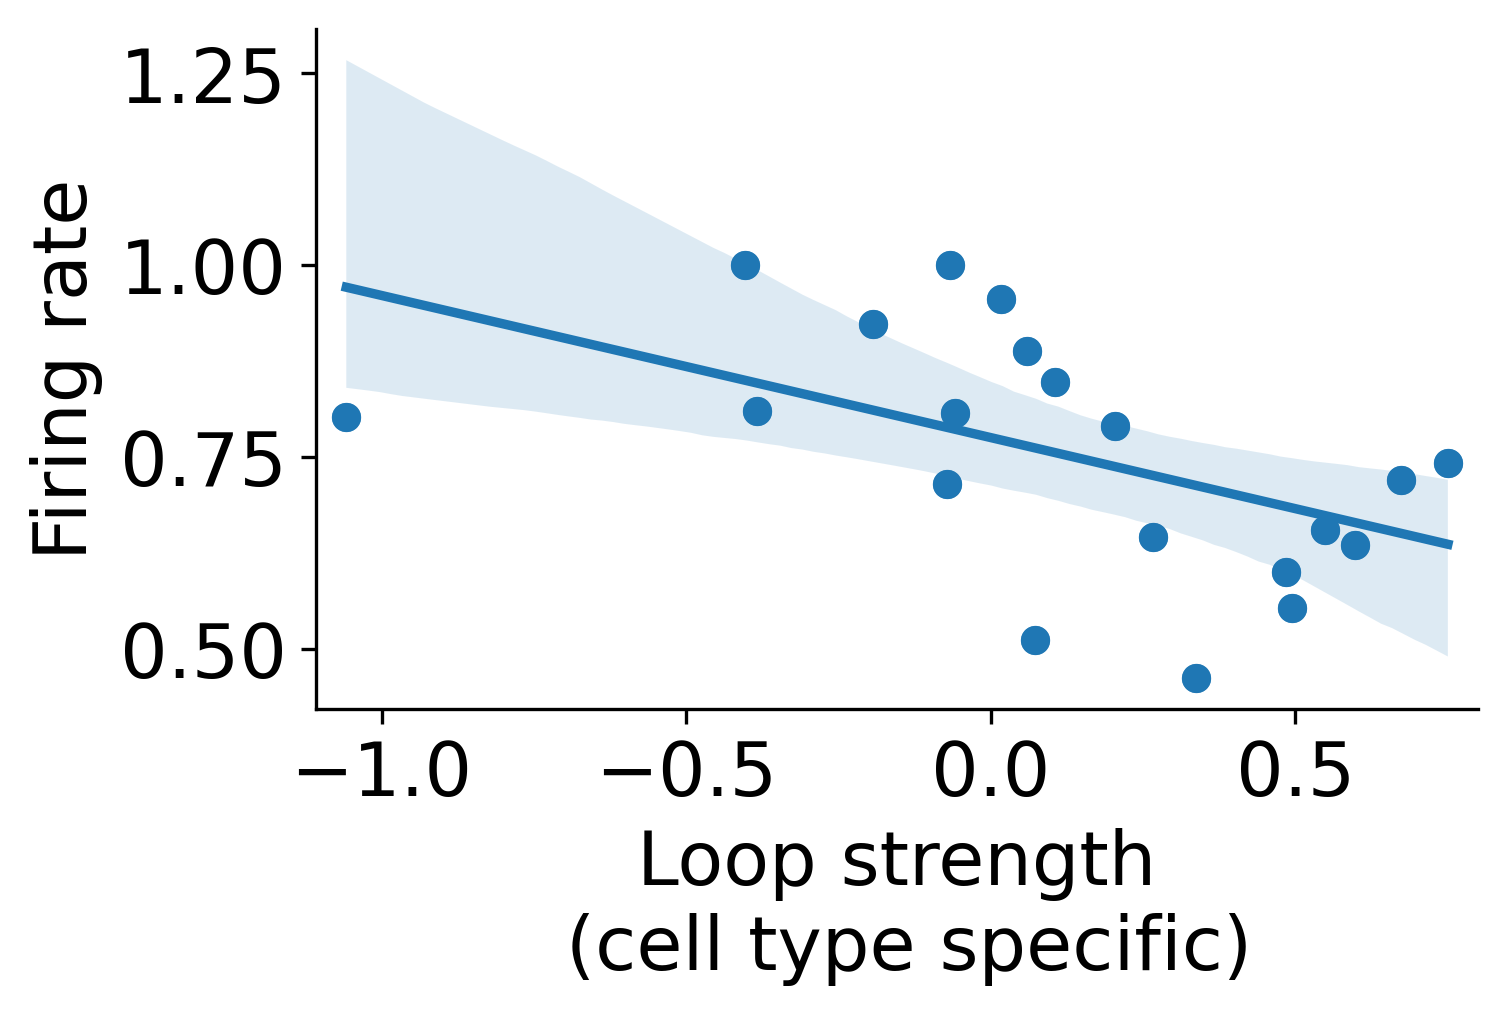

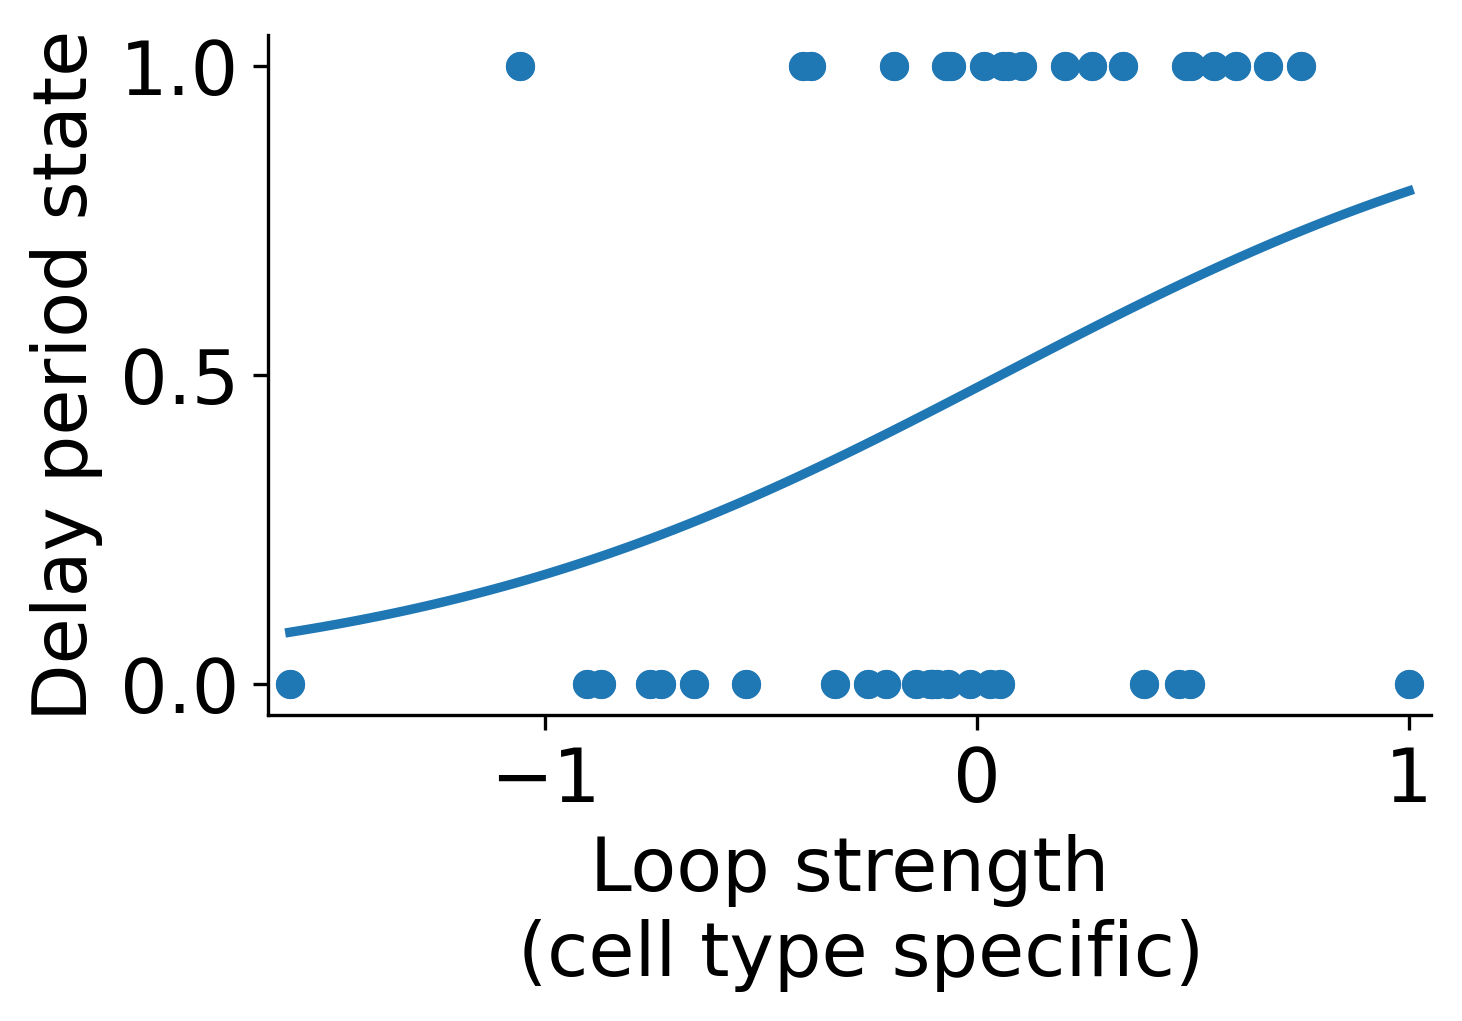

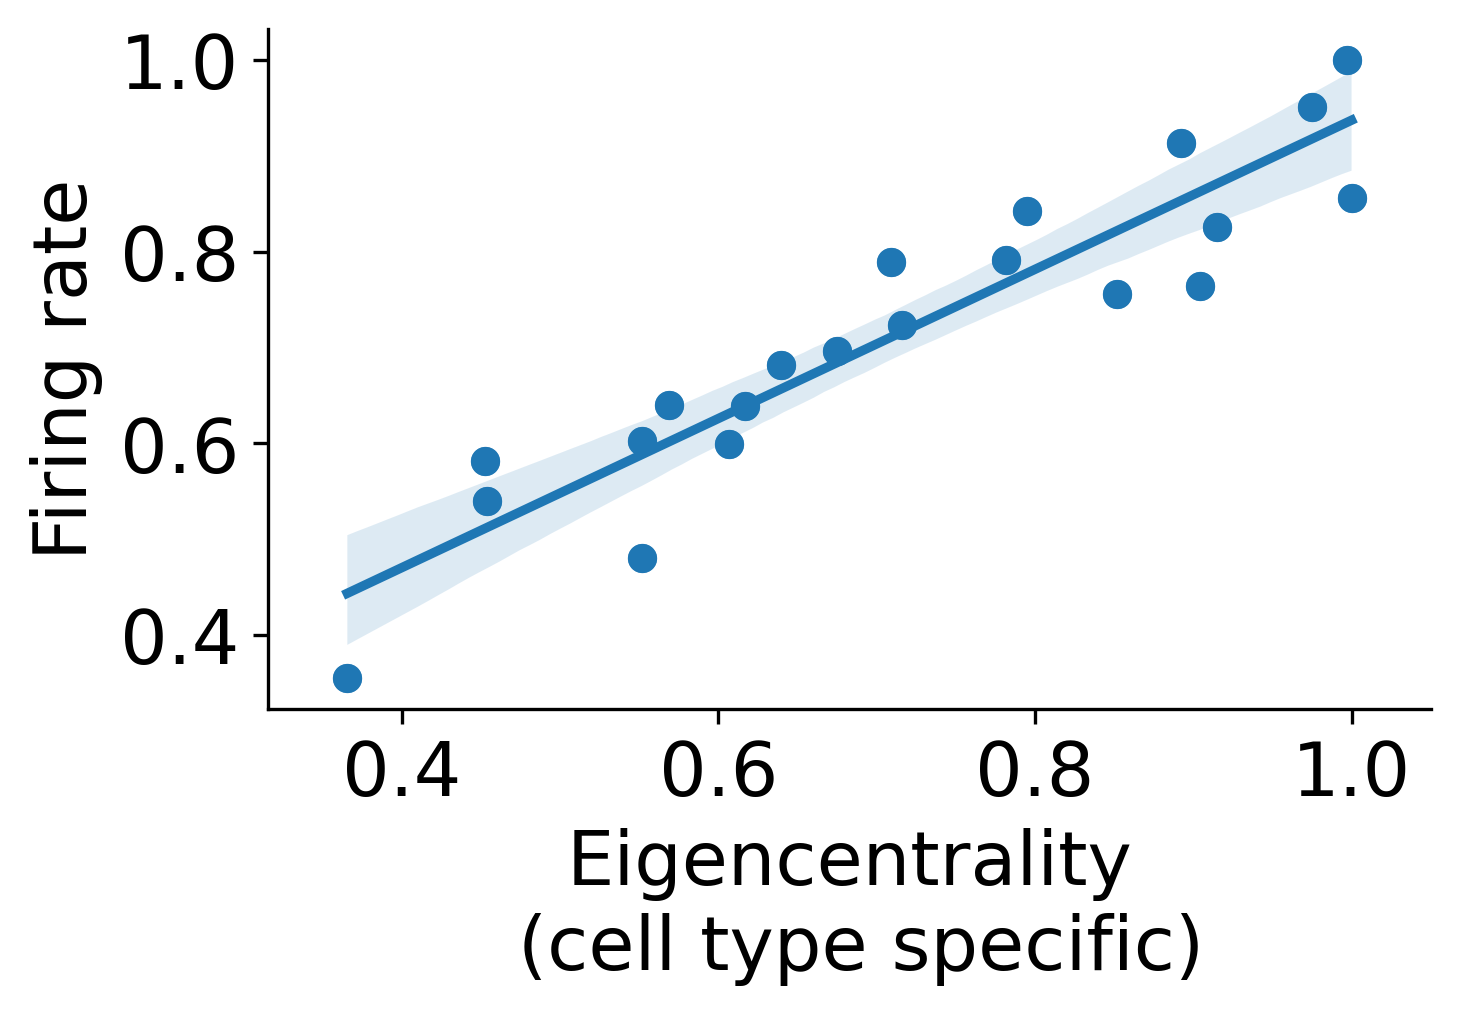

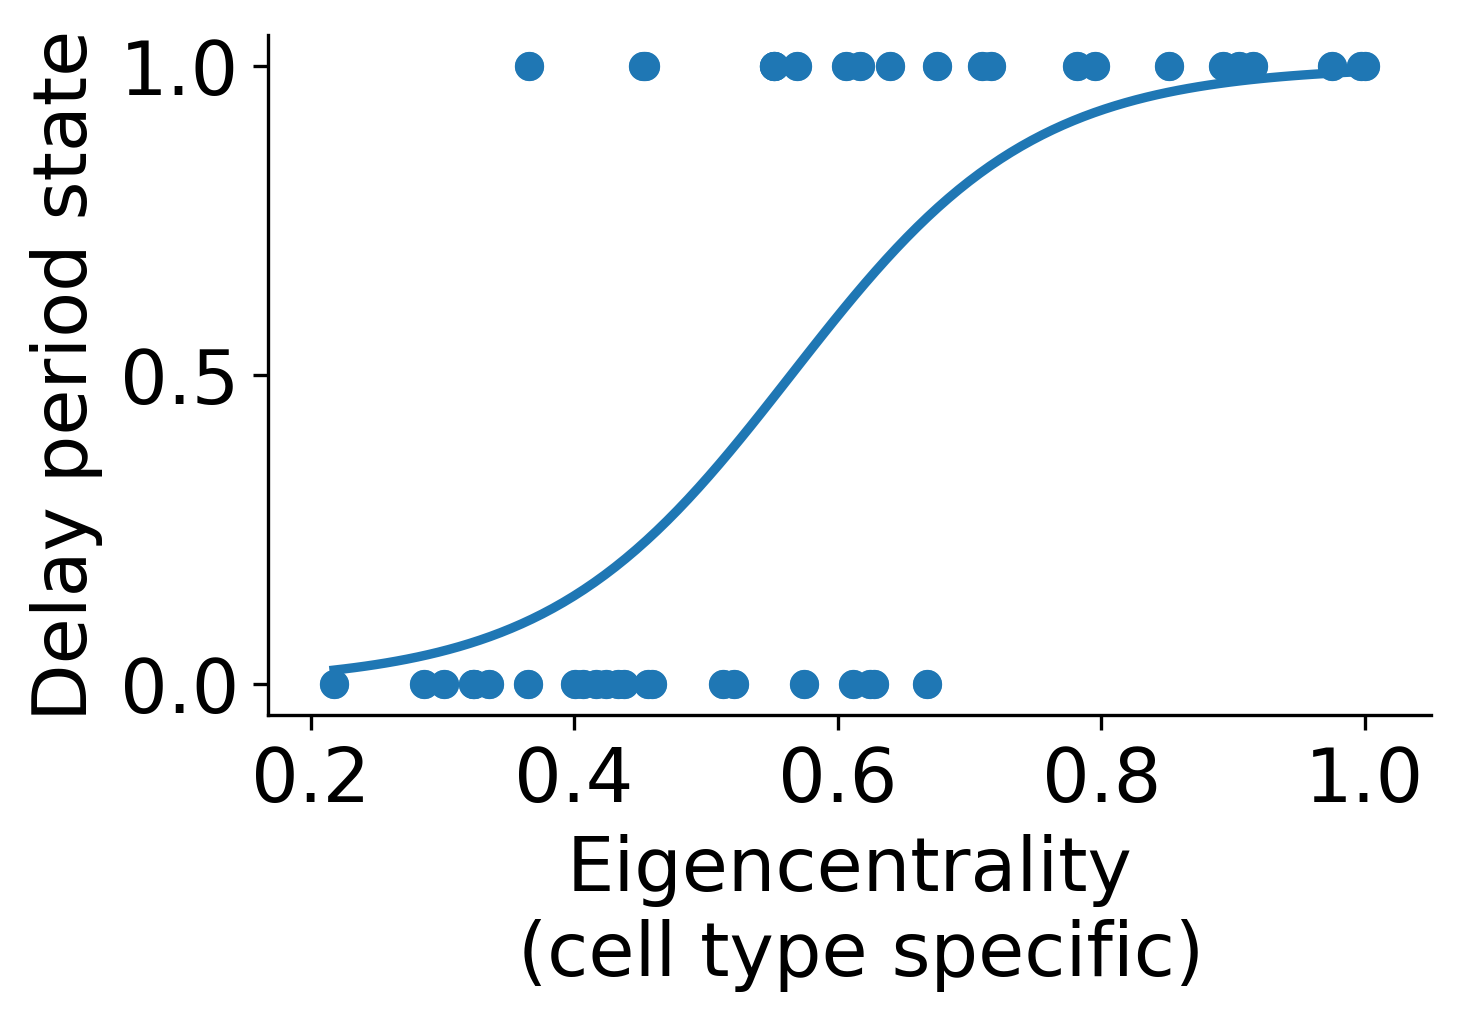

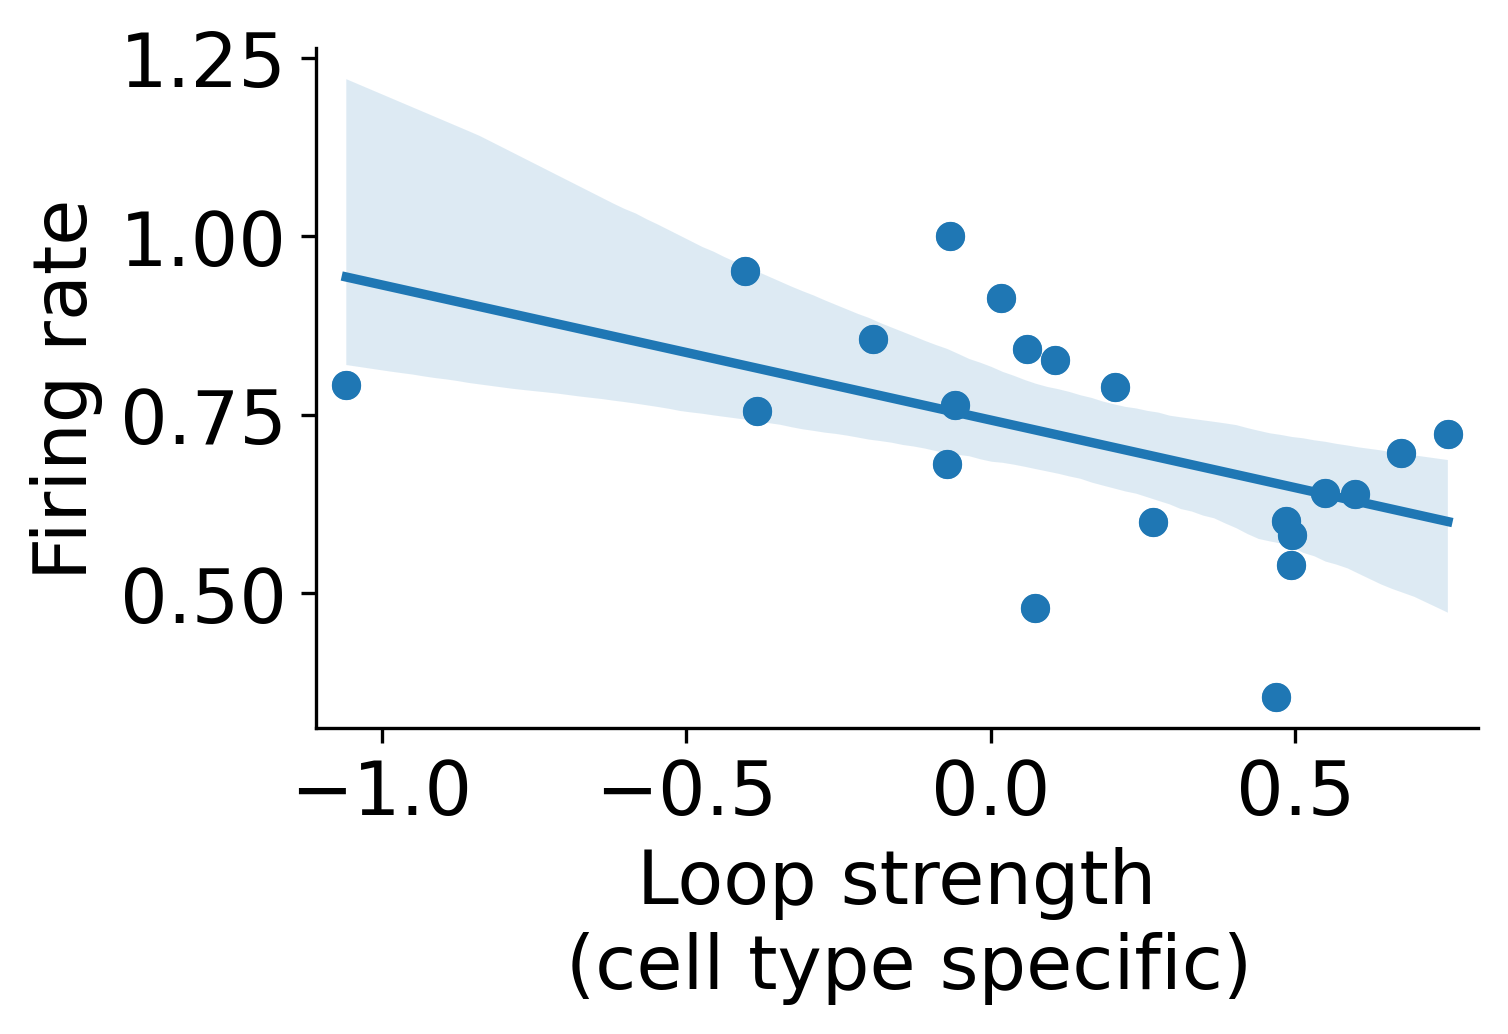

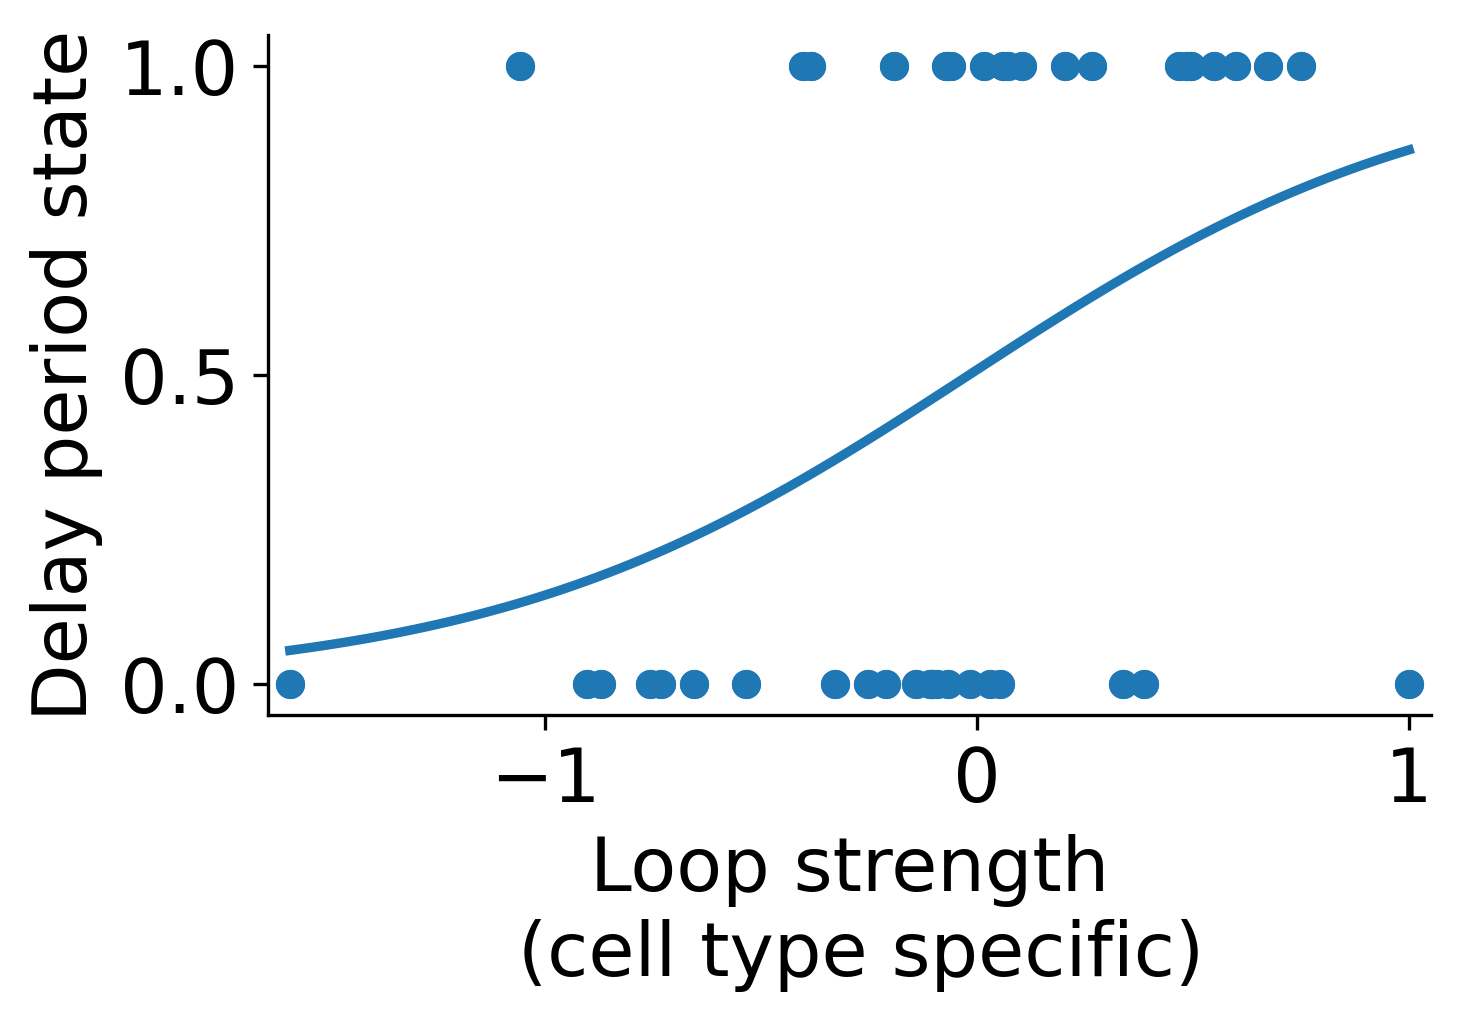

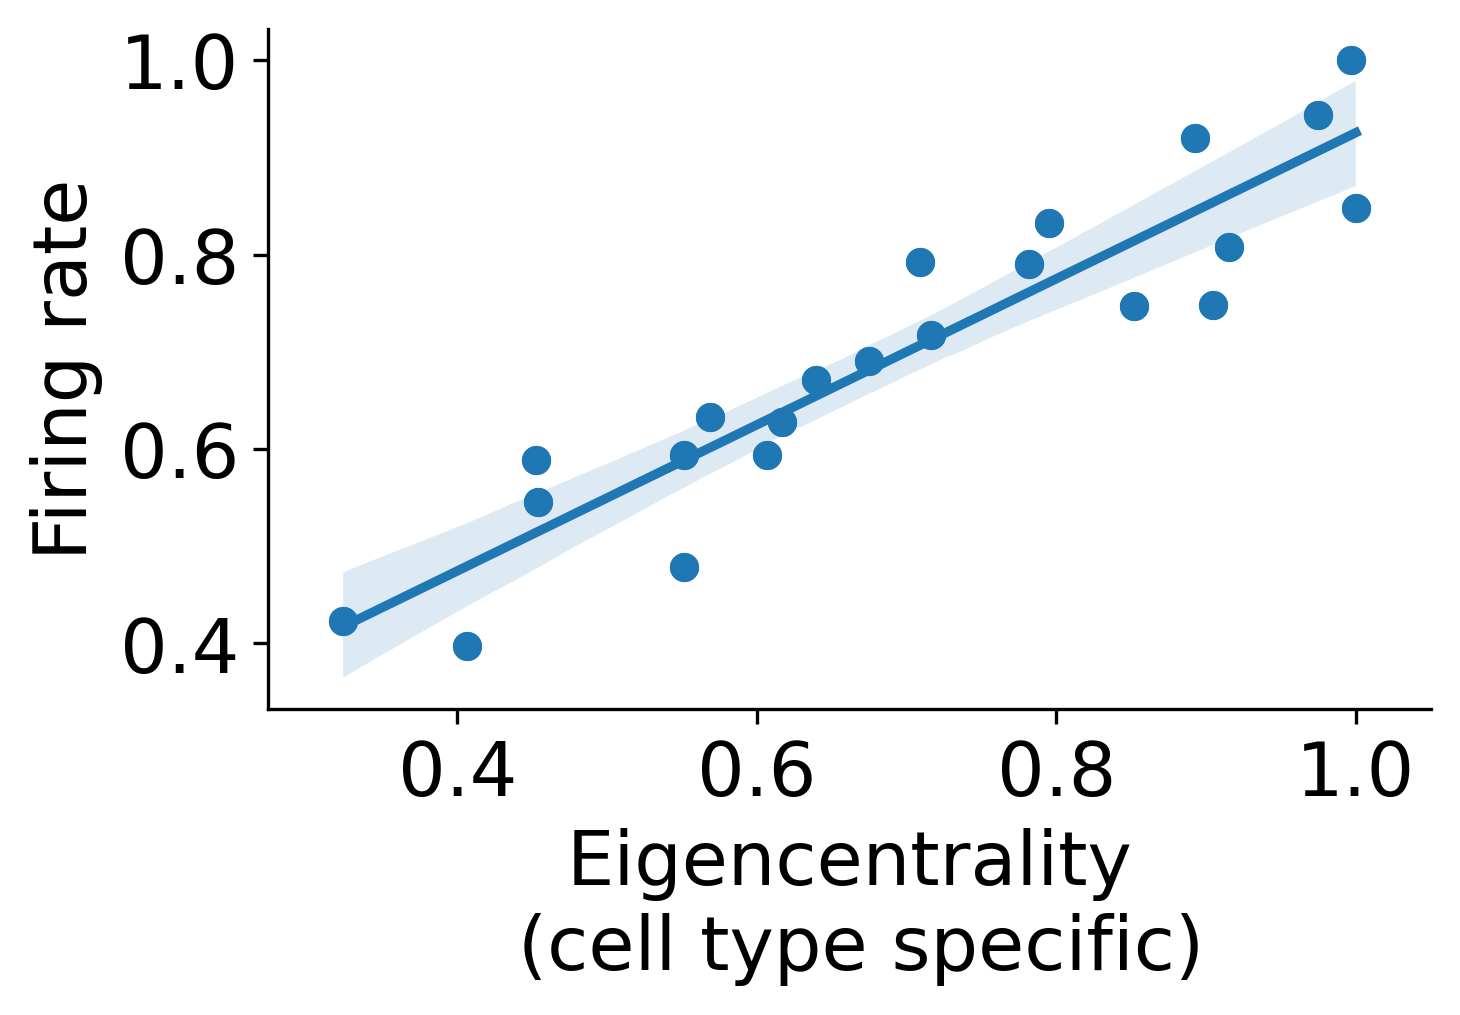

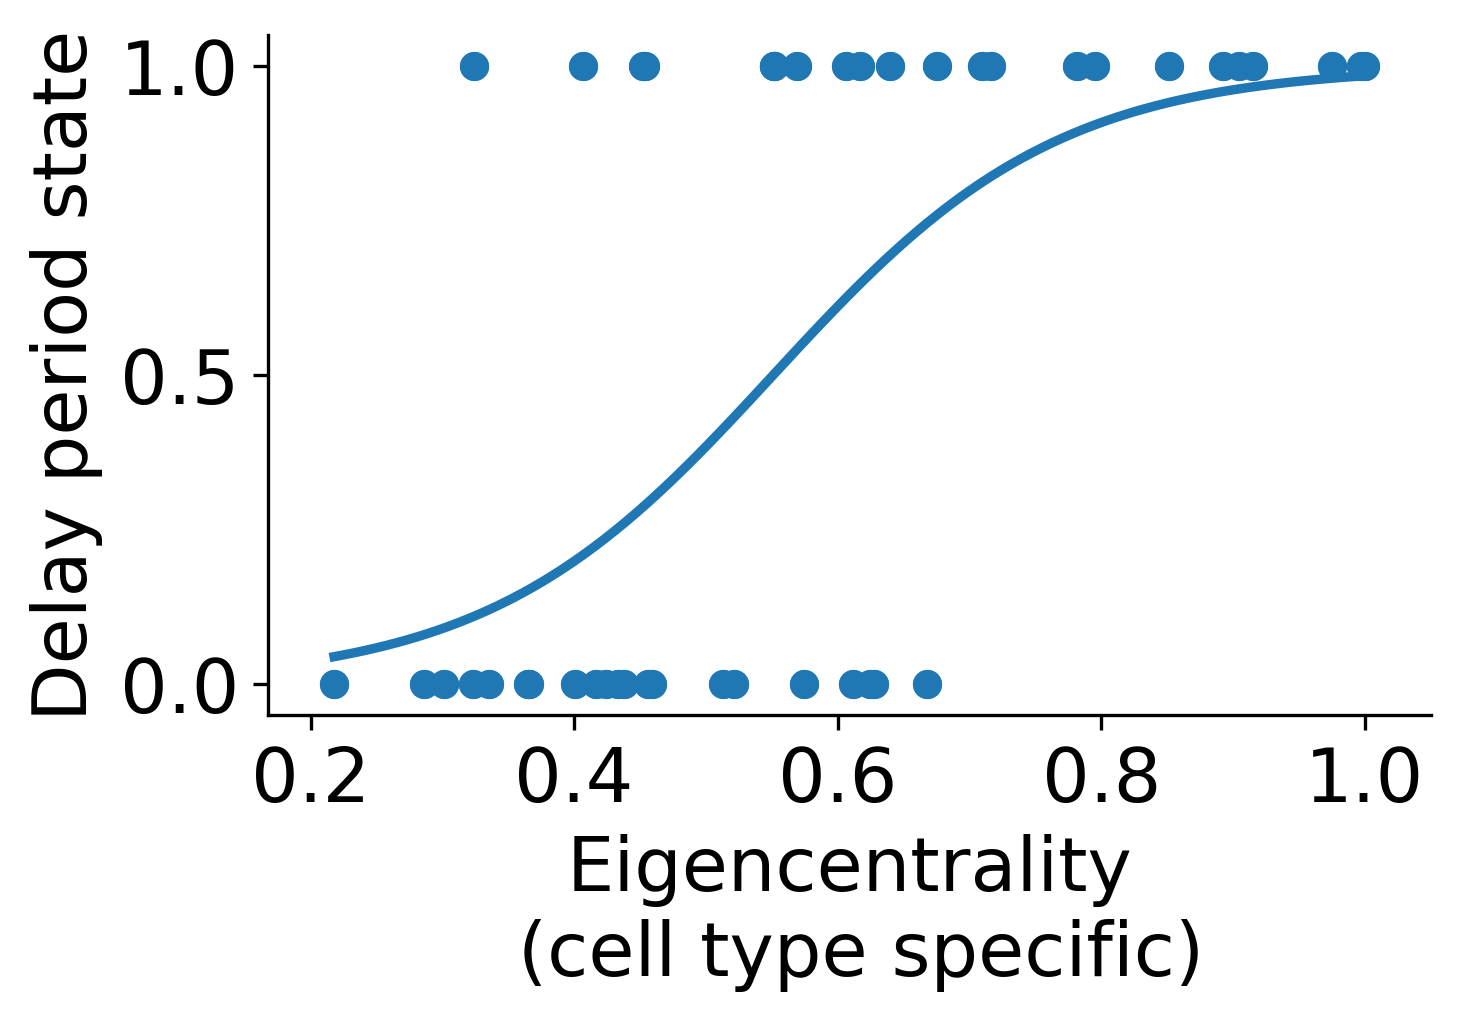

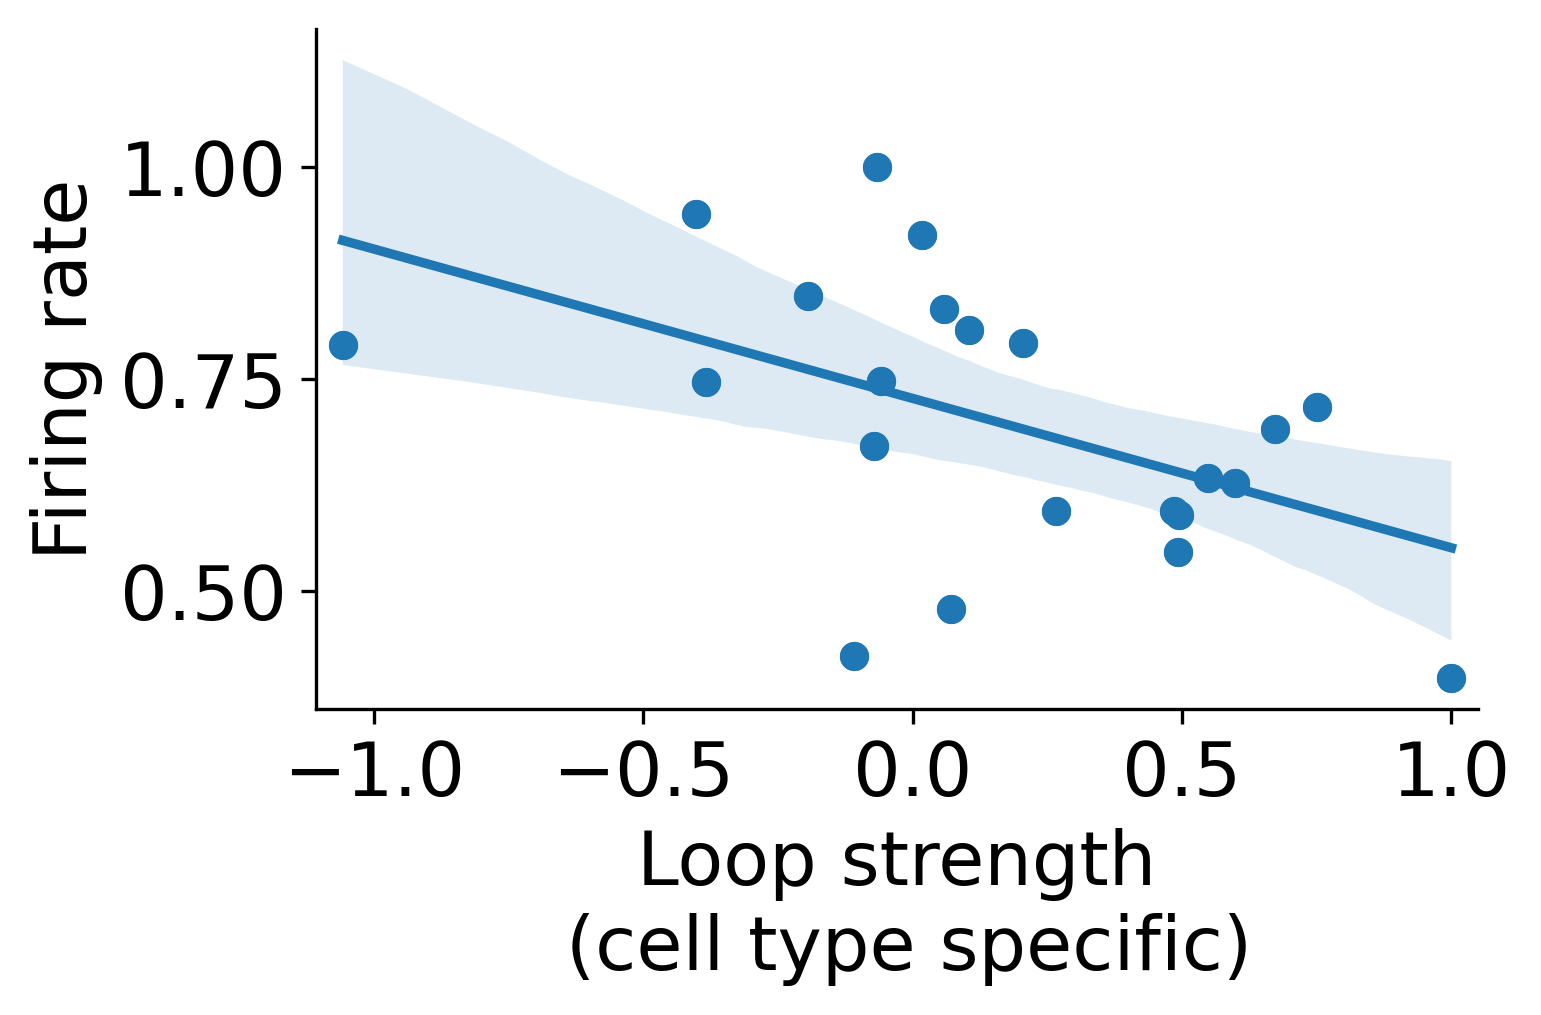

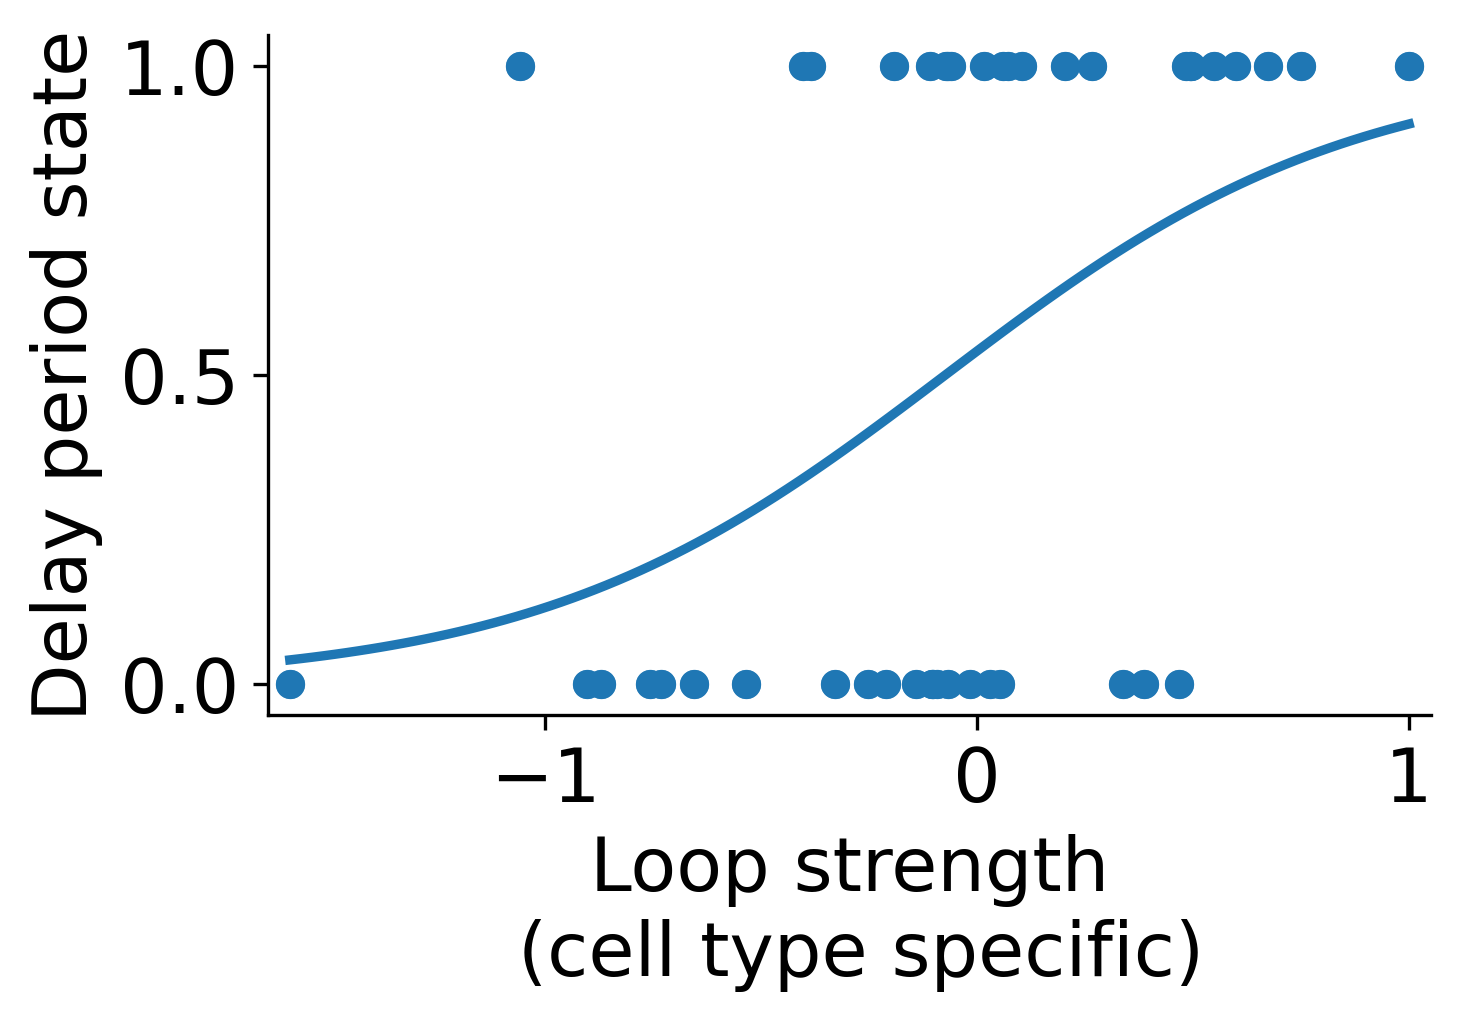

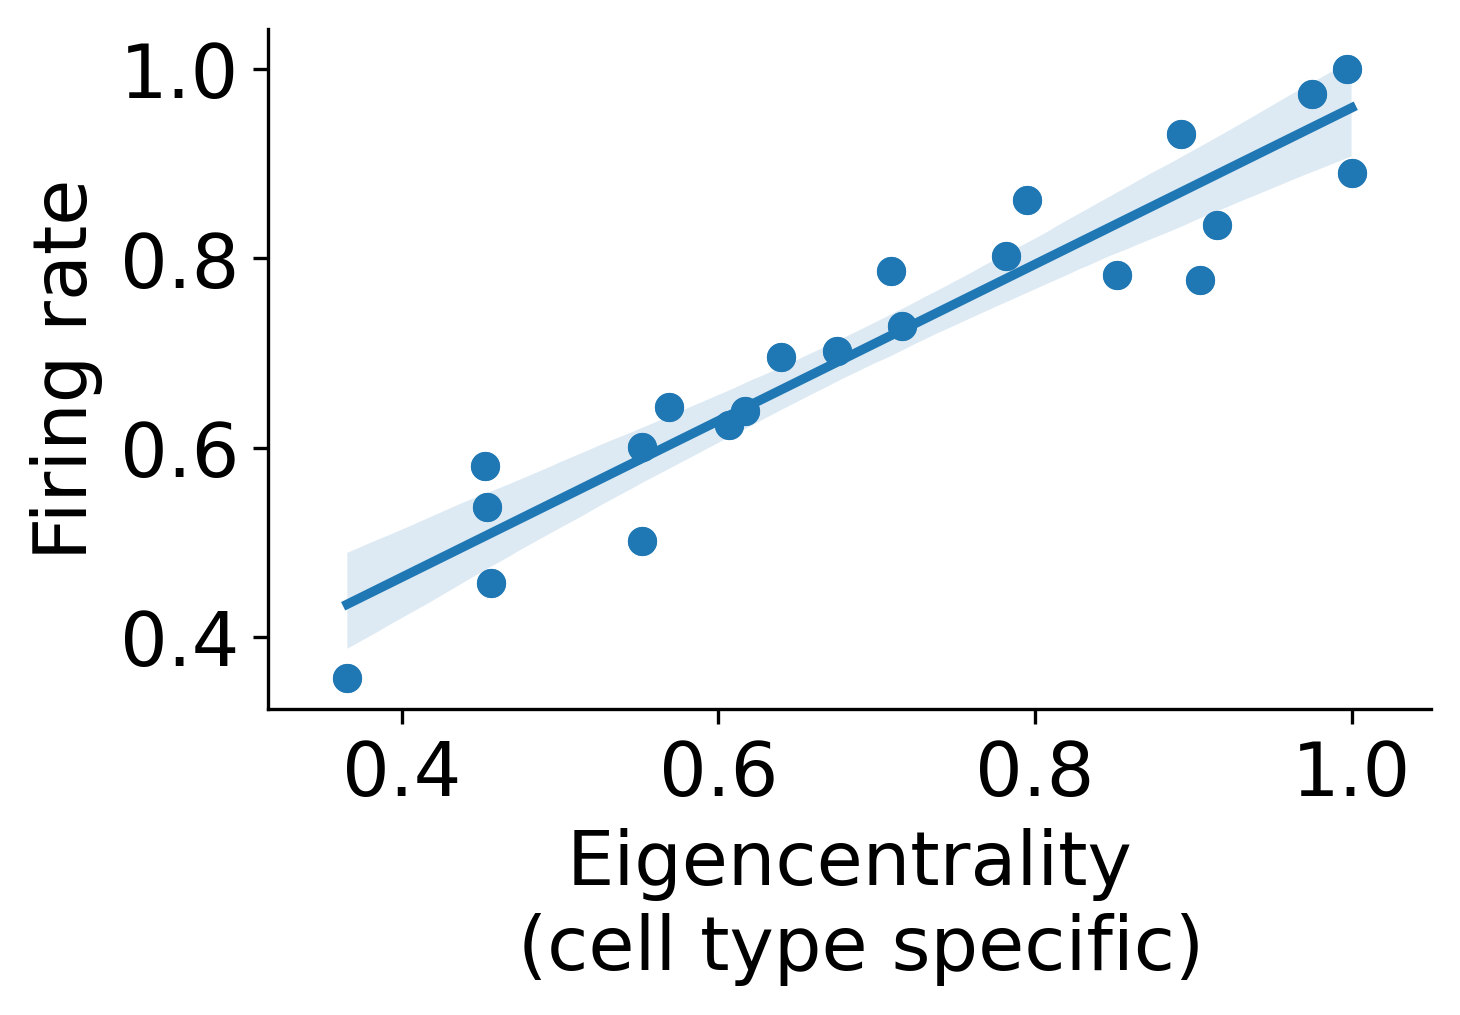

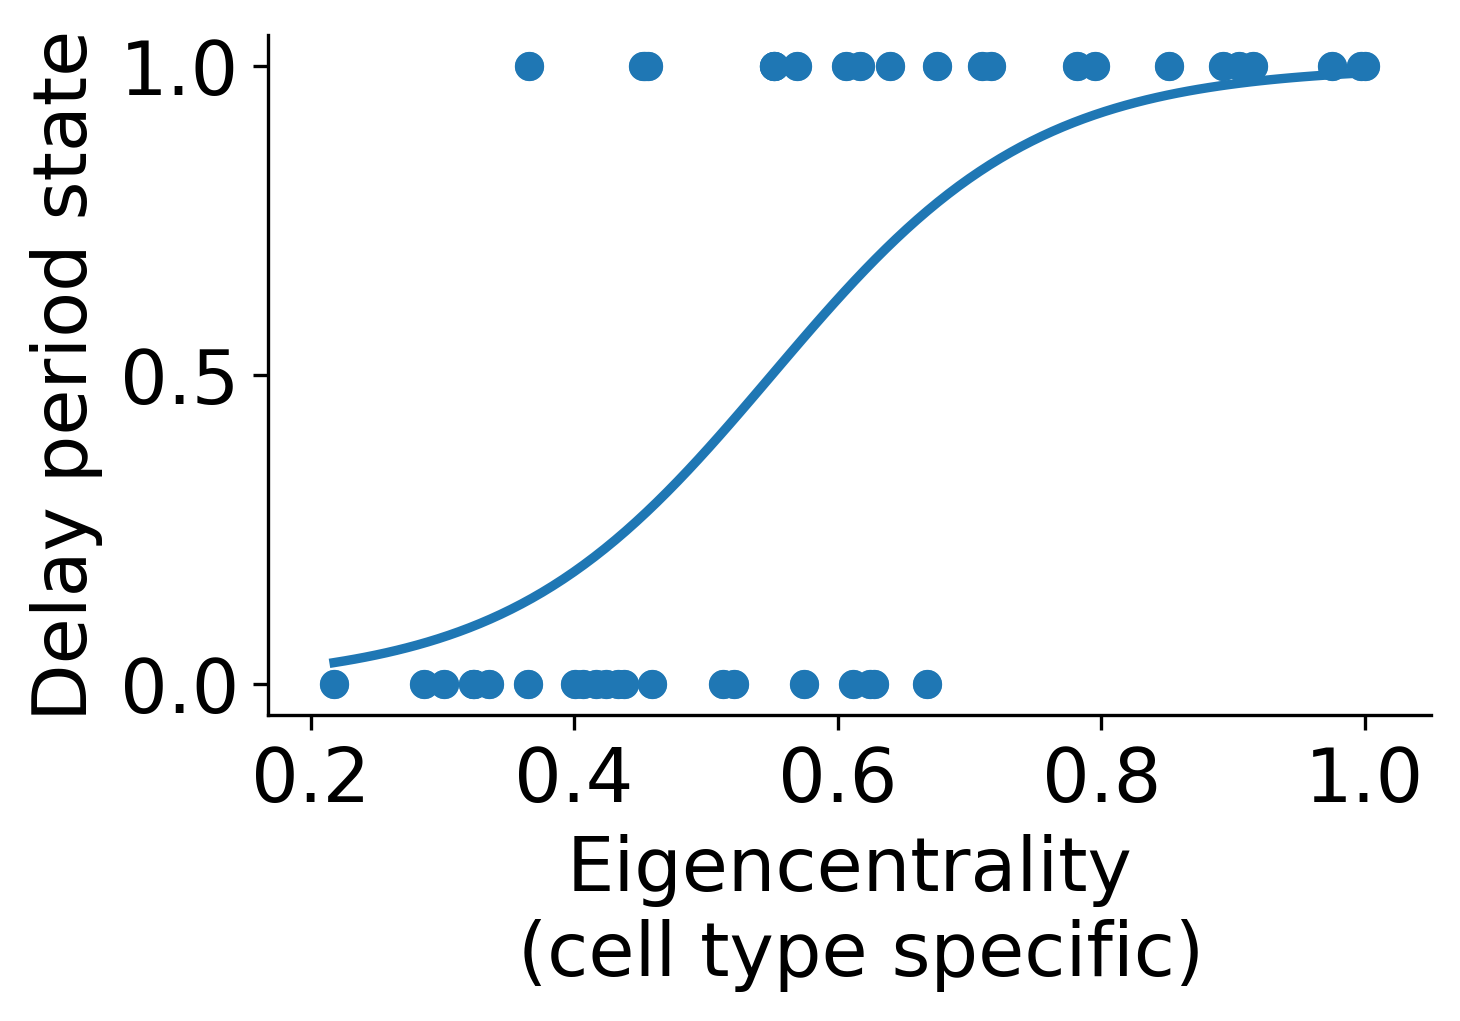

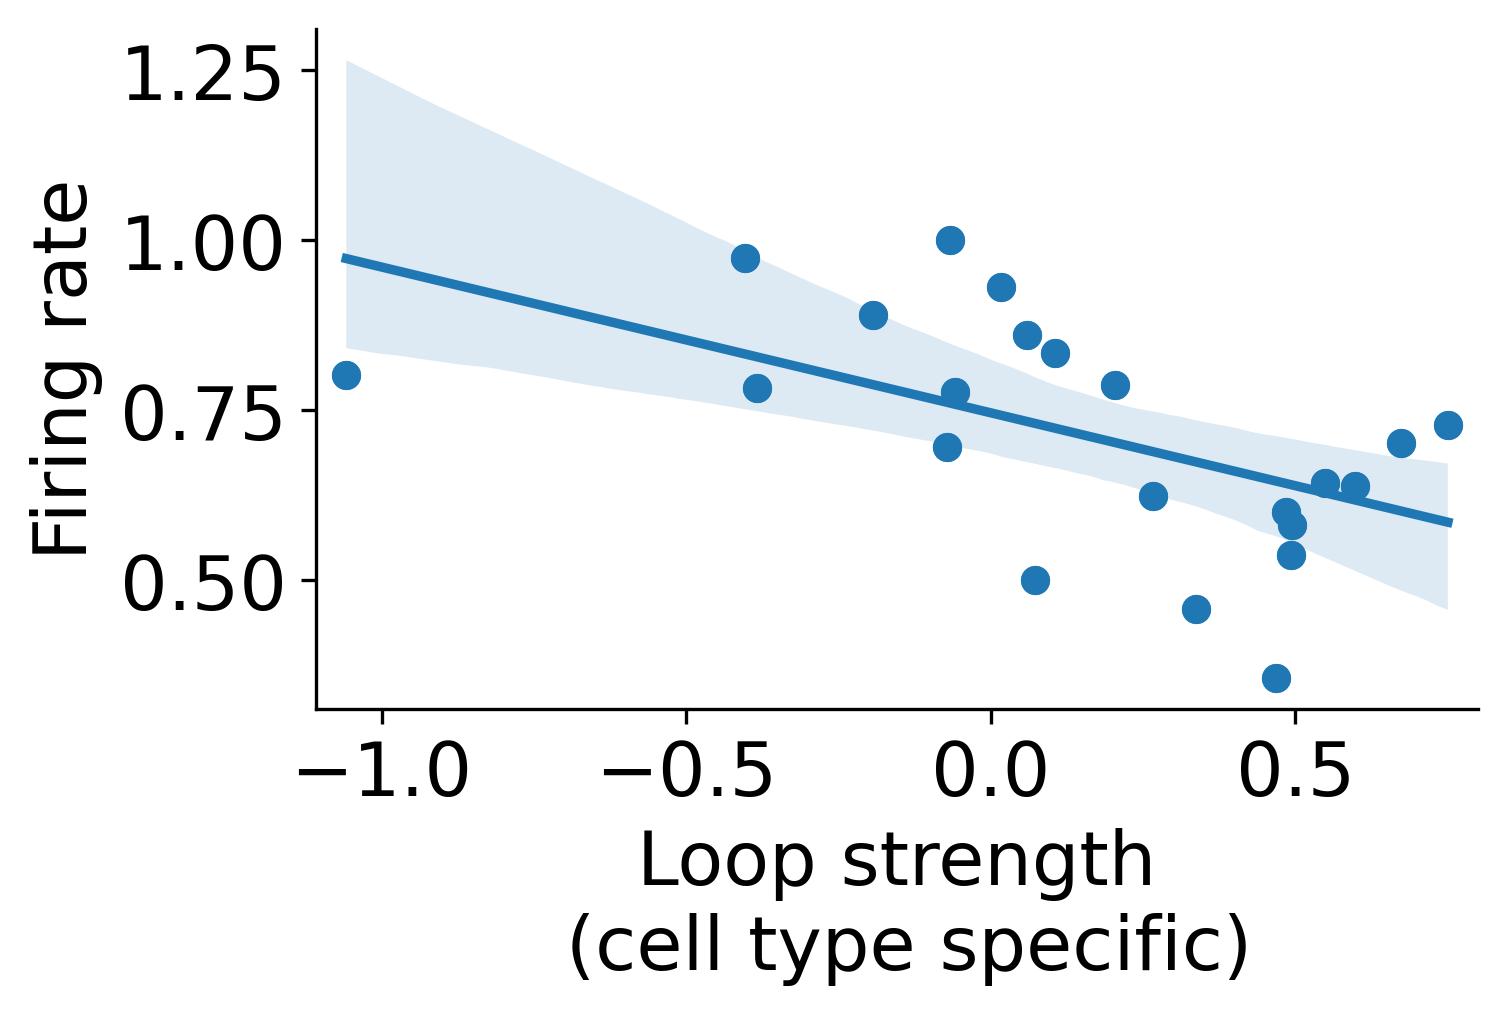

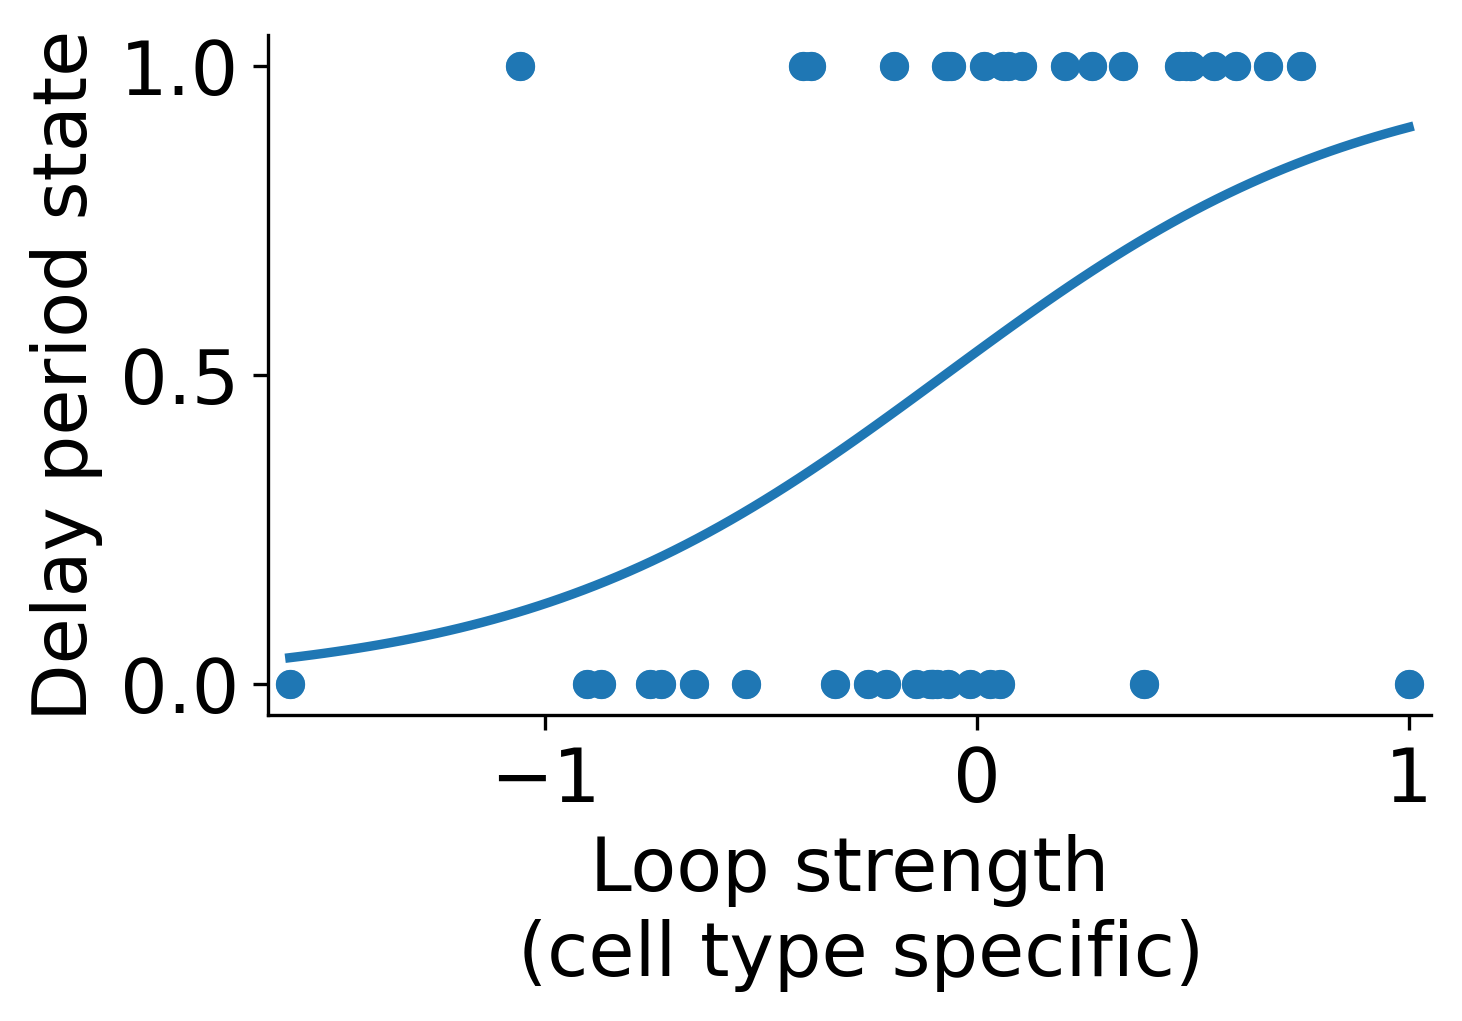

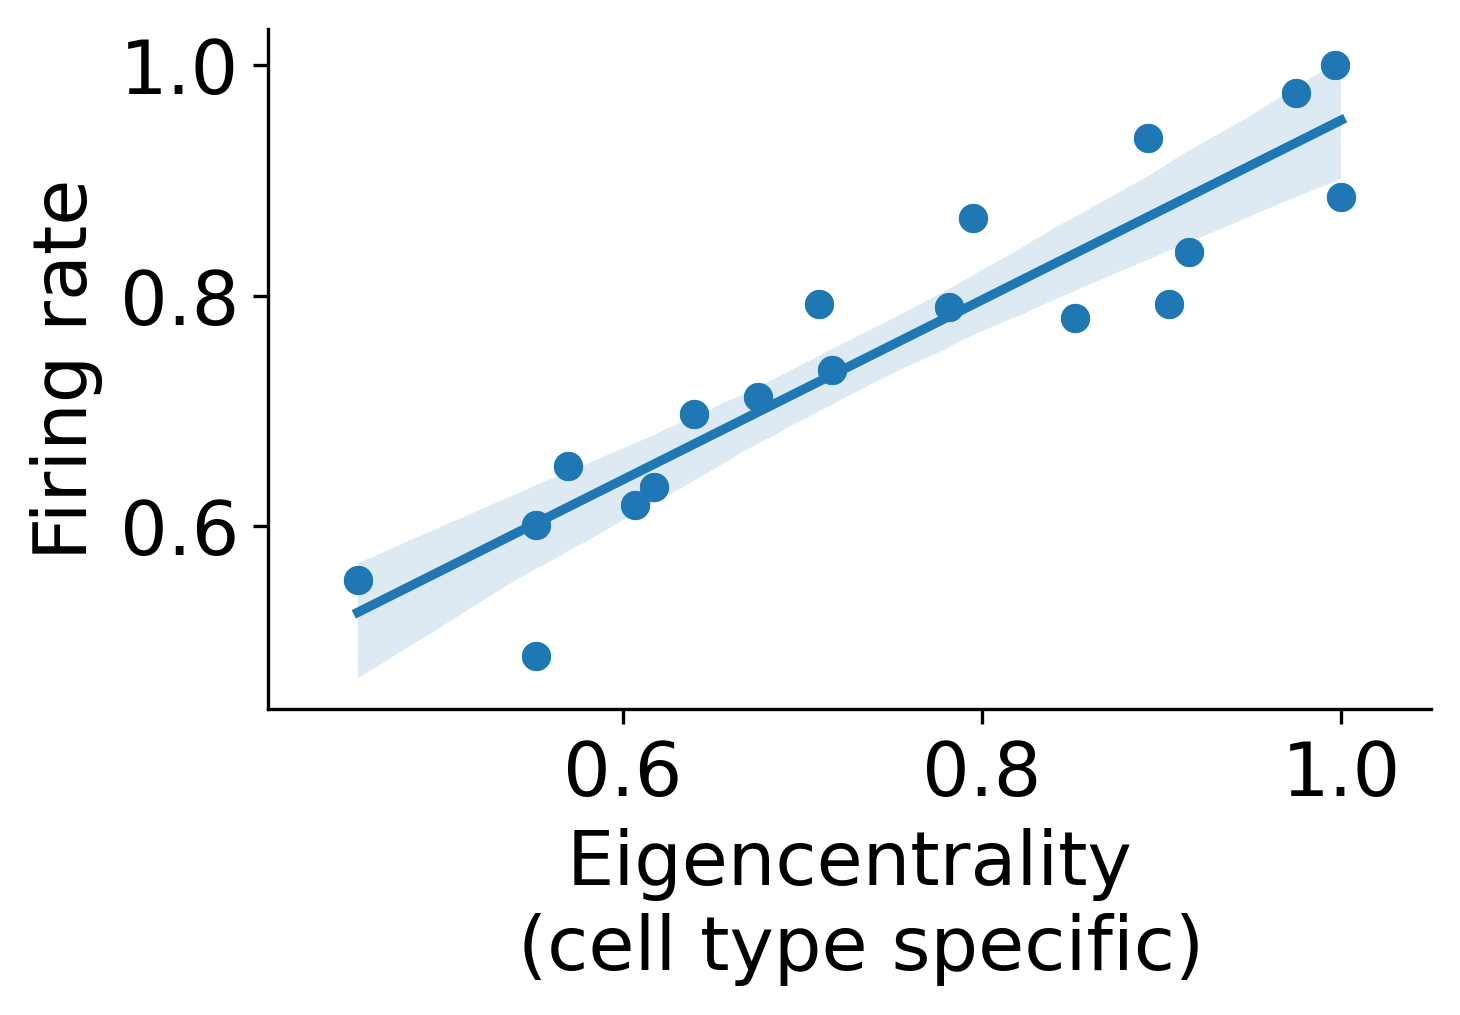

Error in callback <function flush_figures at 0x7fb081082840> (for post_execute):


KeyboardInterrupt: 

In [37]:

corrList, logRegList = getCorrLogRegMulti(attractmat, threshold, hierarchy_df, area_list, 20)


WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
 [py.warnings]


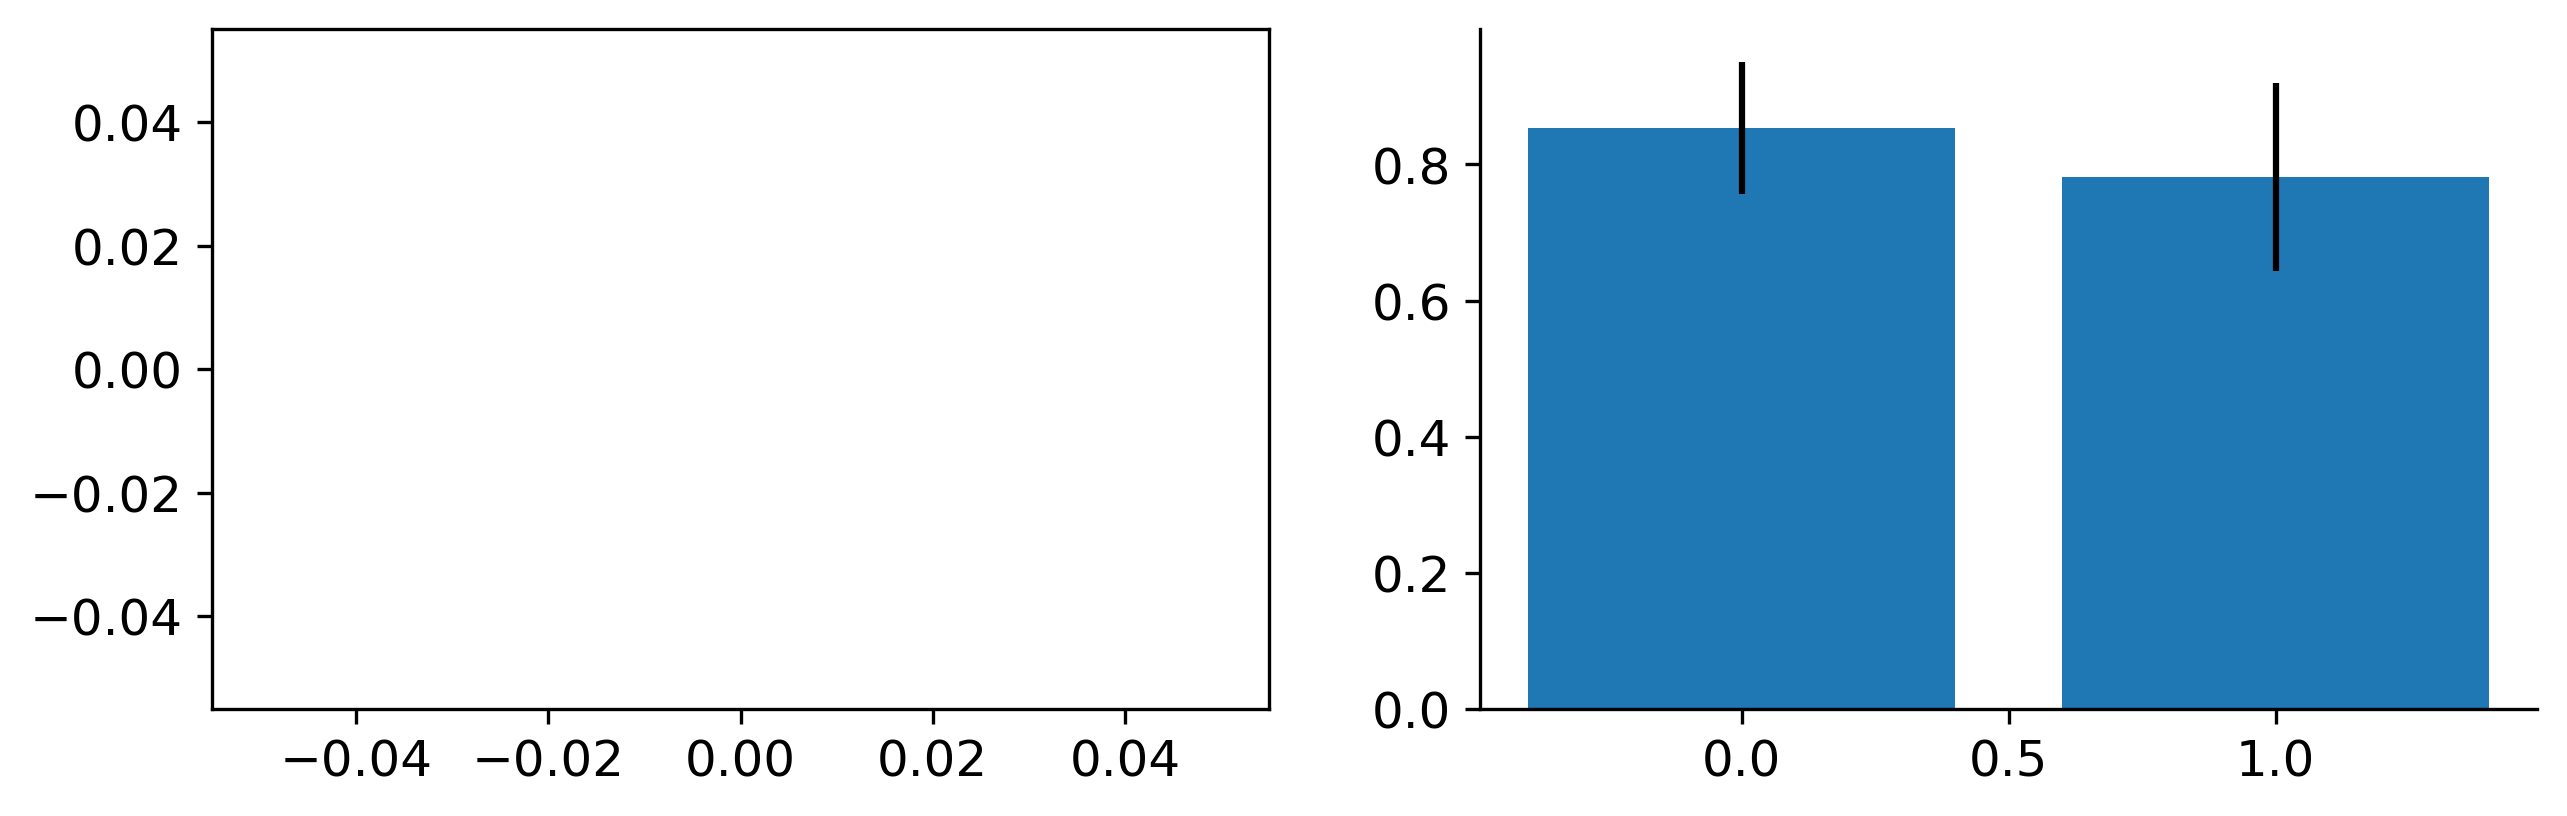

In [38]:
plotCorrLogRegMulti(corrList, logRegList, (10,3), 12, False, 
                    'processMulti/'+ folderName + '_attDistribution.svg' )

In [39]:



X = eigCentX
Y = np.array(model_V1.persistentact_df['persistentact'])
frThreshold = 5
Xlabel = 'Eigencentrality\n (cell type specific)'
Ylabel = 'Firing rate'

plotXYcompr(X, Y, Xlabel, Ylabel, area_list, (5, 3), 12, True,
            'processMulti/eigHiermod_FRcompr1.svg')
eigHiermodCorr = plotXYcomprCorr(X, Y, Xlabel, Ylabel, frThreshold, (5, 3), 12, True,
            'processMulti/eigHiermod_FRcompr2.svg')

# key test  Hier vs. FR pattern
X = np.array(hierarchy_df).reshape((-1))

Xlabel = 'Hierarchy'


plotXYcompr(X, Y, Xlabel, Ylabel, area_list, (5, 3), 12, True,
            'processMulti/HierFRcompr1.svg')
HierCorr = plotXYcomprCorr(X, Y, Xlabel, Ylabel, frThreshold, (5, 3), 12, True,
            'processMulti/HierFRcompr2.svg')


# key test  Hier vs. FR pattern
X = np.array(normPVgrad_df).reshape((-1))

Xlabel = 'PVdensity'

plotXYcompr(X, Y, Xlabel, Ylabel, area_list, (5, 3), 12, True,
            'processMulti/PVFRcompr1.svg')
HierCorr = plotXYcomprCorr(X, Y, Xlabel, Ylabel, frThreshold, (5, 3), 12, True,
            'processMulti/PVFRcompr2.svg')

# target modified loop str vs FR

X = sum_SC_str_Hiermod

Xlabel = 'Loop strength\n (cell type specific)'

plotXYcompr(X, Y, Xlabel, Ylabel, area_list, (5, 3), 12, True,
            'processMulti/loopHiermod_FRcompr1.svg')
loopHiermodCorr = plotXYcomprCorr(X, Y, Xlabel, Ylabel, frThreshold, (5, 3), 12, True,
            'processMulti/loopHiermod_FRcompr2.svg')



AttributeError: 'list' object has no attribute 'max'

<Figure size 1500x900 with 0 Axes>

In [40]:

# key test  eigCent vs. FR pattern
# get the eigen centrality of the conn matrix

frThreshold = 5

eigV, eigCent = np.linalg.eig(conn_cxcx_norm_Hiermod)  # load saved data

# eigV, eigCent = np.linalg.eig(conn_sc)
ind = np.argmax(eigV)

X1 = np.abs(eigCent[:,ind])
X = (X1 - X1.min()) / (X1.max() - X1.min())
Y = np.array(model_V1.persistentact_df['persistentact'])  # read the attractor data
Xlabel = 'Eigencentrality\n (cell type specific)'
Ylabel = 'Firing rate'

plotXYcompr(X, Y, Xlabel, Ylabel, area_list, (5, 3), 12, True,
            'processMulti/eigHiermod_FRcompr1.svg')
eigHiermodCorr = plotXYcomprCorr(X, Y, Xlabel, Ylabel, frThreshold, (5, 3), 12, True,
            'processMulti/eigHiermod_FRcompr2.svg')
# plotXYcomprResidual(X, Y, Xlabel, frThreshold, (5, 3), 12, True,
#             'processMulti/eigHiermod_FRcompr3.svg')

NameError: name 'conn_cxcx_norm_Hiermod' is not defined

In [42]:
def plotMultipleAttractor(attractmat, hierarchy_df, figSize, fontSize, saveFig, fileName):
    fig = plt.figure(figsize=figSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    for i in np.arange(attractmat.shape[0]):
    #     if np.max(attractmat[i,:]) < model.parameters['PAthreshold']:
    #         pass
    #     else:
        if len(stimDict[i]) >= 0:
            plt.plot(hierarchy_df.iloc[hierarchy_df['hierarchy index'].argsort()],
                        attractmat[i, hierarchy_df['hierarchy index'].argsort()], 
                     '-o', markersize = 1, alpha = 0.5, label='attractor_'+str(i+1)
        #                     +', count = '+str(attract_count[i])
                        )
    plt.xlabel('Hierarchy')
    plt.ylabel('Firing rate(Hz)')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)

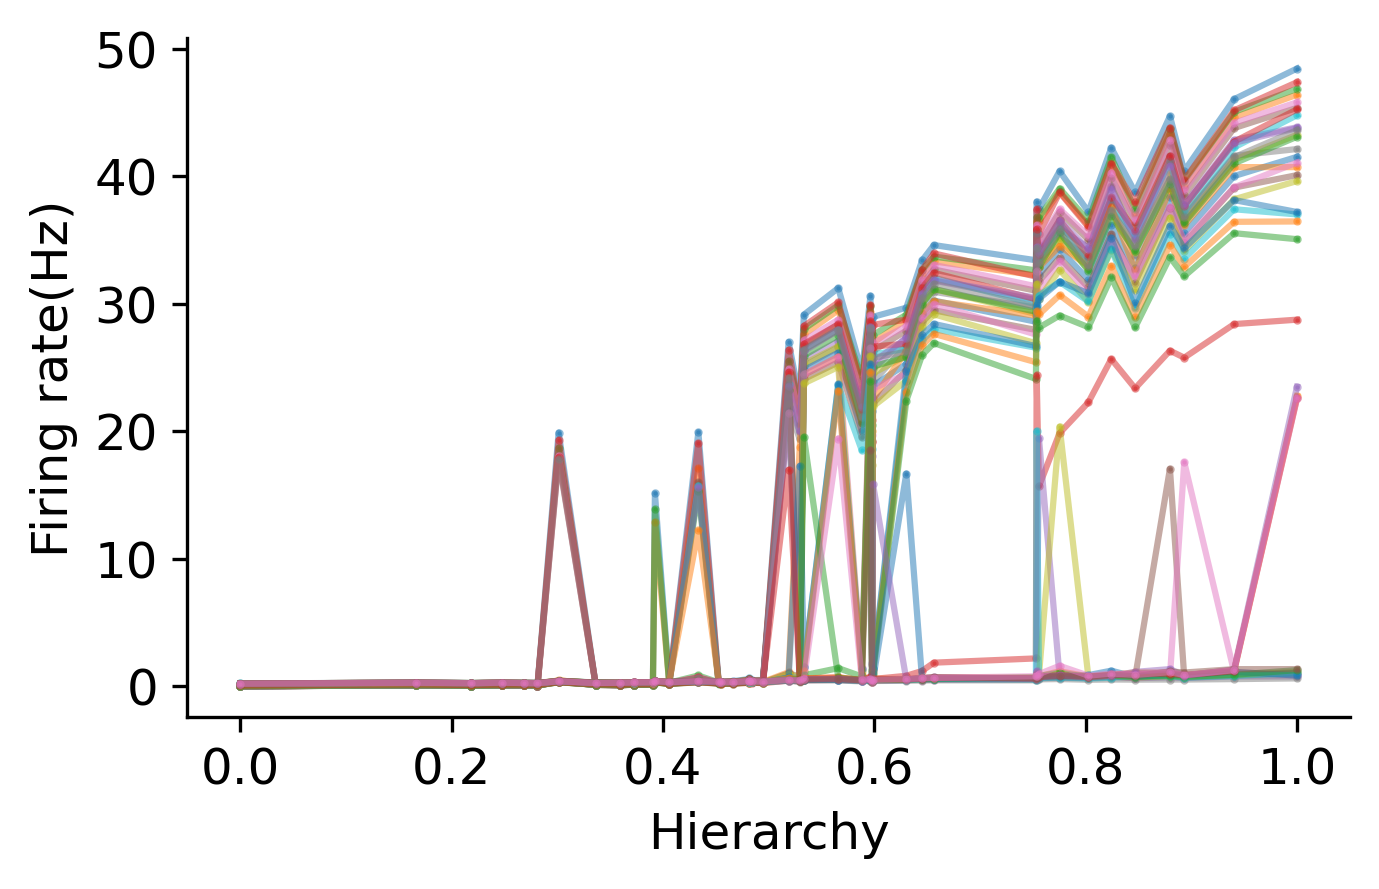

In [43]:
plotMultipleAttractor(attractmat, hierarchy_df, (5,3), 12, True, 
                      'processMulti/'+folderName+'_multAtt.svg')

In [54]:
def plotMultipleAttractorHeatmap(attractmat, hierarchy_df, figSize, fontSize, saveFig, fileName):
    fig = plt.figure(figsize=figSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    for i in np.arange(attractmat.shape[0]):
        if len(stimDict[i]) >= 0:
            plt.imshow(attractmat)
    plt.xticks(range(n_areas), area_list, rotation = 90, fontsize=fontSize*0.4)
    plt.yticks(range(attractmat.shape[0]), range(attractmat.shape[0]), fontsize = fontSize*0.4)
    plt.xlabel('Area')
    plt.ylabel('Attractor Index')
    plt.title('Firing rate profile of each attractor')
#     cbar = plt.colorbar()
#     cbar.set_label('Firing rate')
    ax = plt.gca()
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
    if saveFig:
        fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)

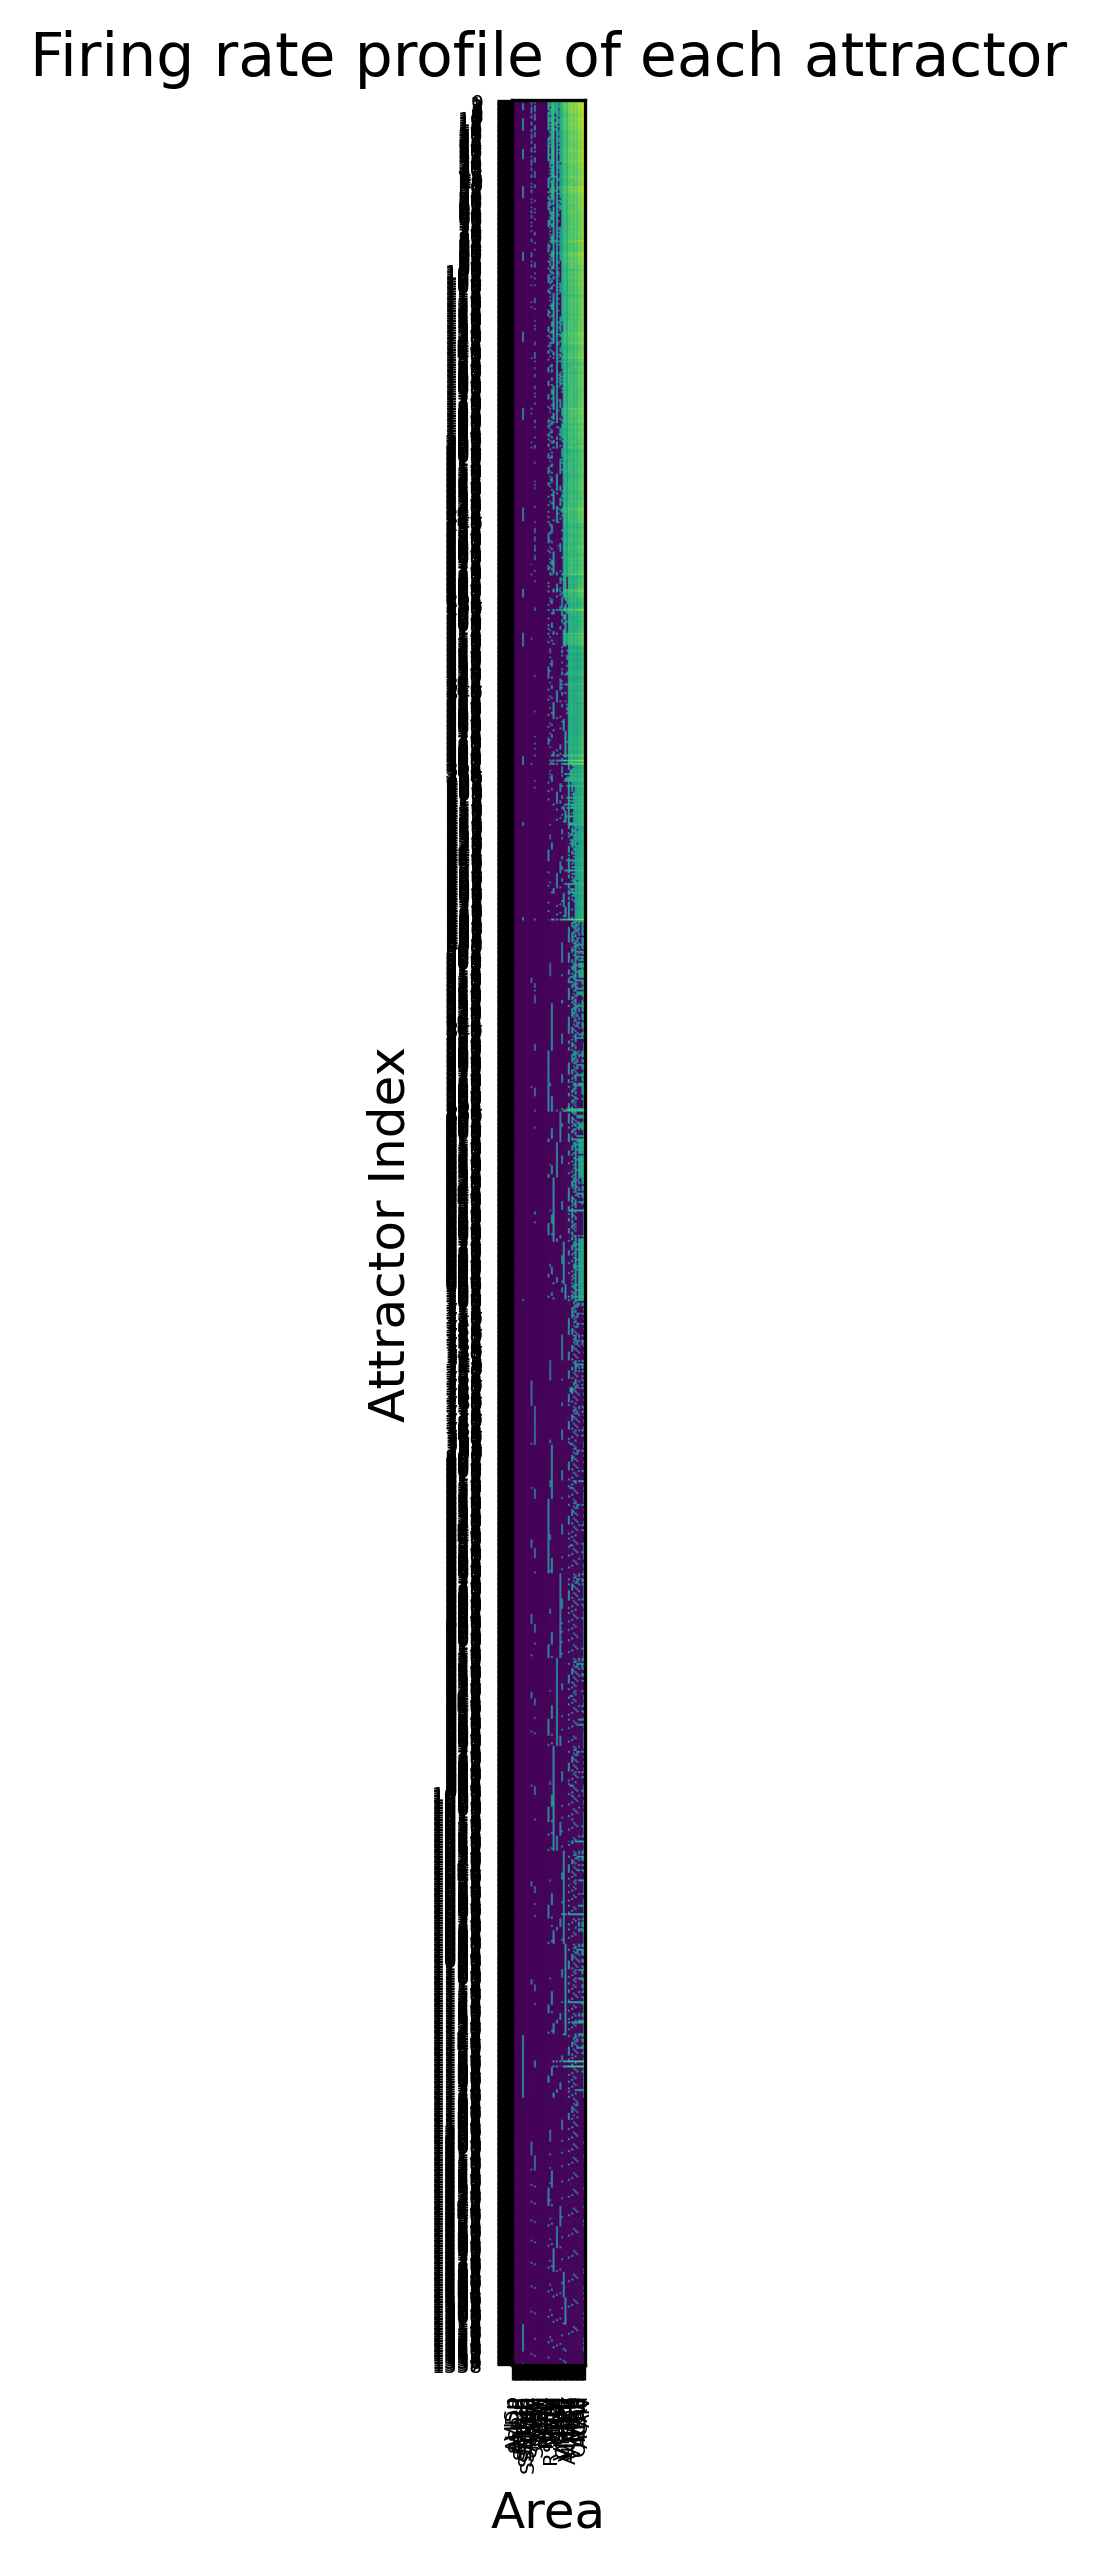

In [55]:
# plot all the attractors.
plotMultipleAttractorHeatmap(attractmat, hierarchy_df, (5,10), 12, True,  'processMulti/'+folderName+'_multAttHeatmap.svg')

In [25]:
# plot multiple attractors for large attractmat
def plotMultipleAttractorHeatmapLarge(attractmat, cutoffThres, hierarchy_df, figSize, fontSize, saveFig, fileName):
    fig = plt.figure(figsize=figSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    plt.title(f'{cutoffThres} attractors each plot')
    
    nx, ny = attractmat.shape
    
    nPlot = int(np.ceil(nx / cutoffThres))  # ceil and floor.
    
    for i in range(nPlot):
        plt.subplot(1, nPlot, i + 1)
        plt.imshow(attractmat[i * cutoffThres : (i+1) * cutoffThres, :])
    
#     for i in np.arange(nx):
#         if len(stimDict[i]) >= 0:
#             plt.imshow(attractmat)
    
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
    if saveFig:
        fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)

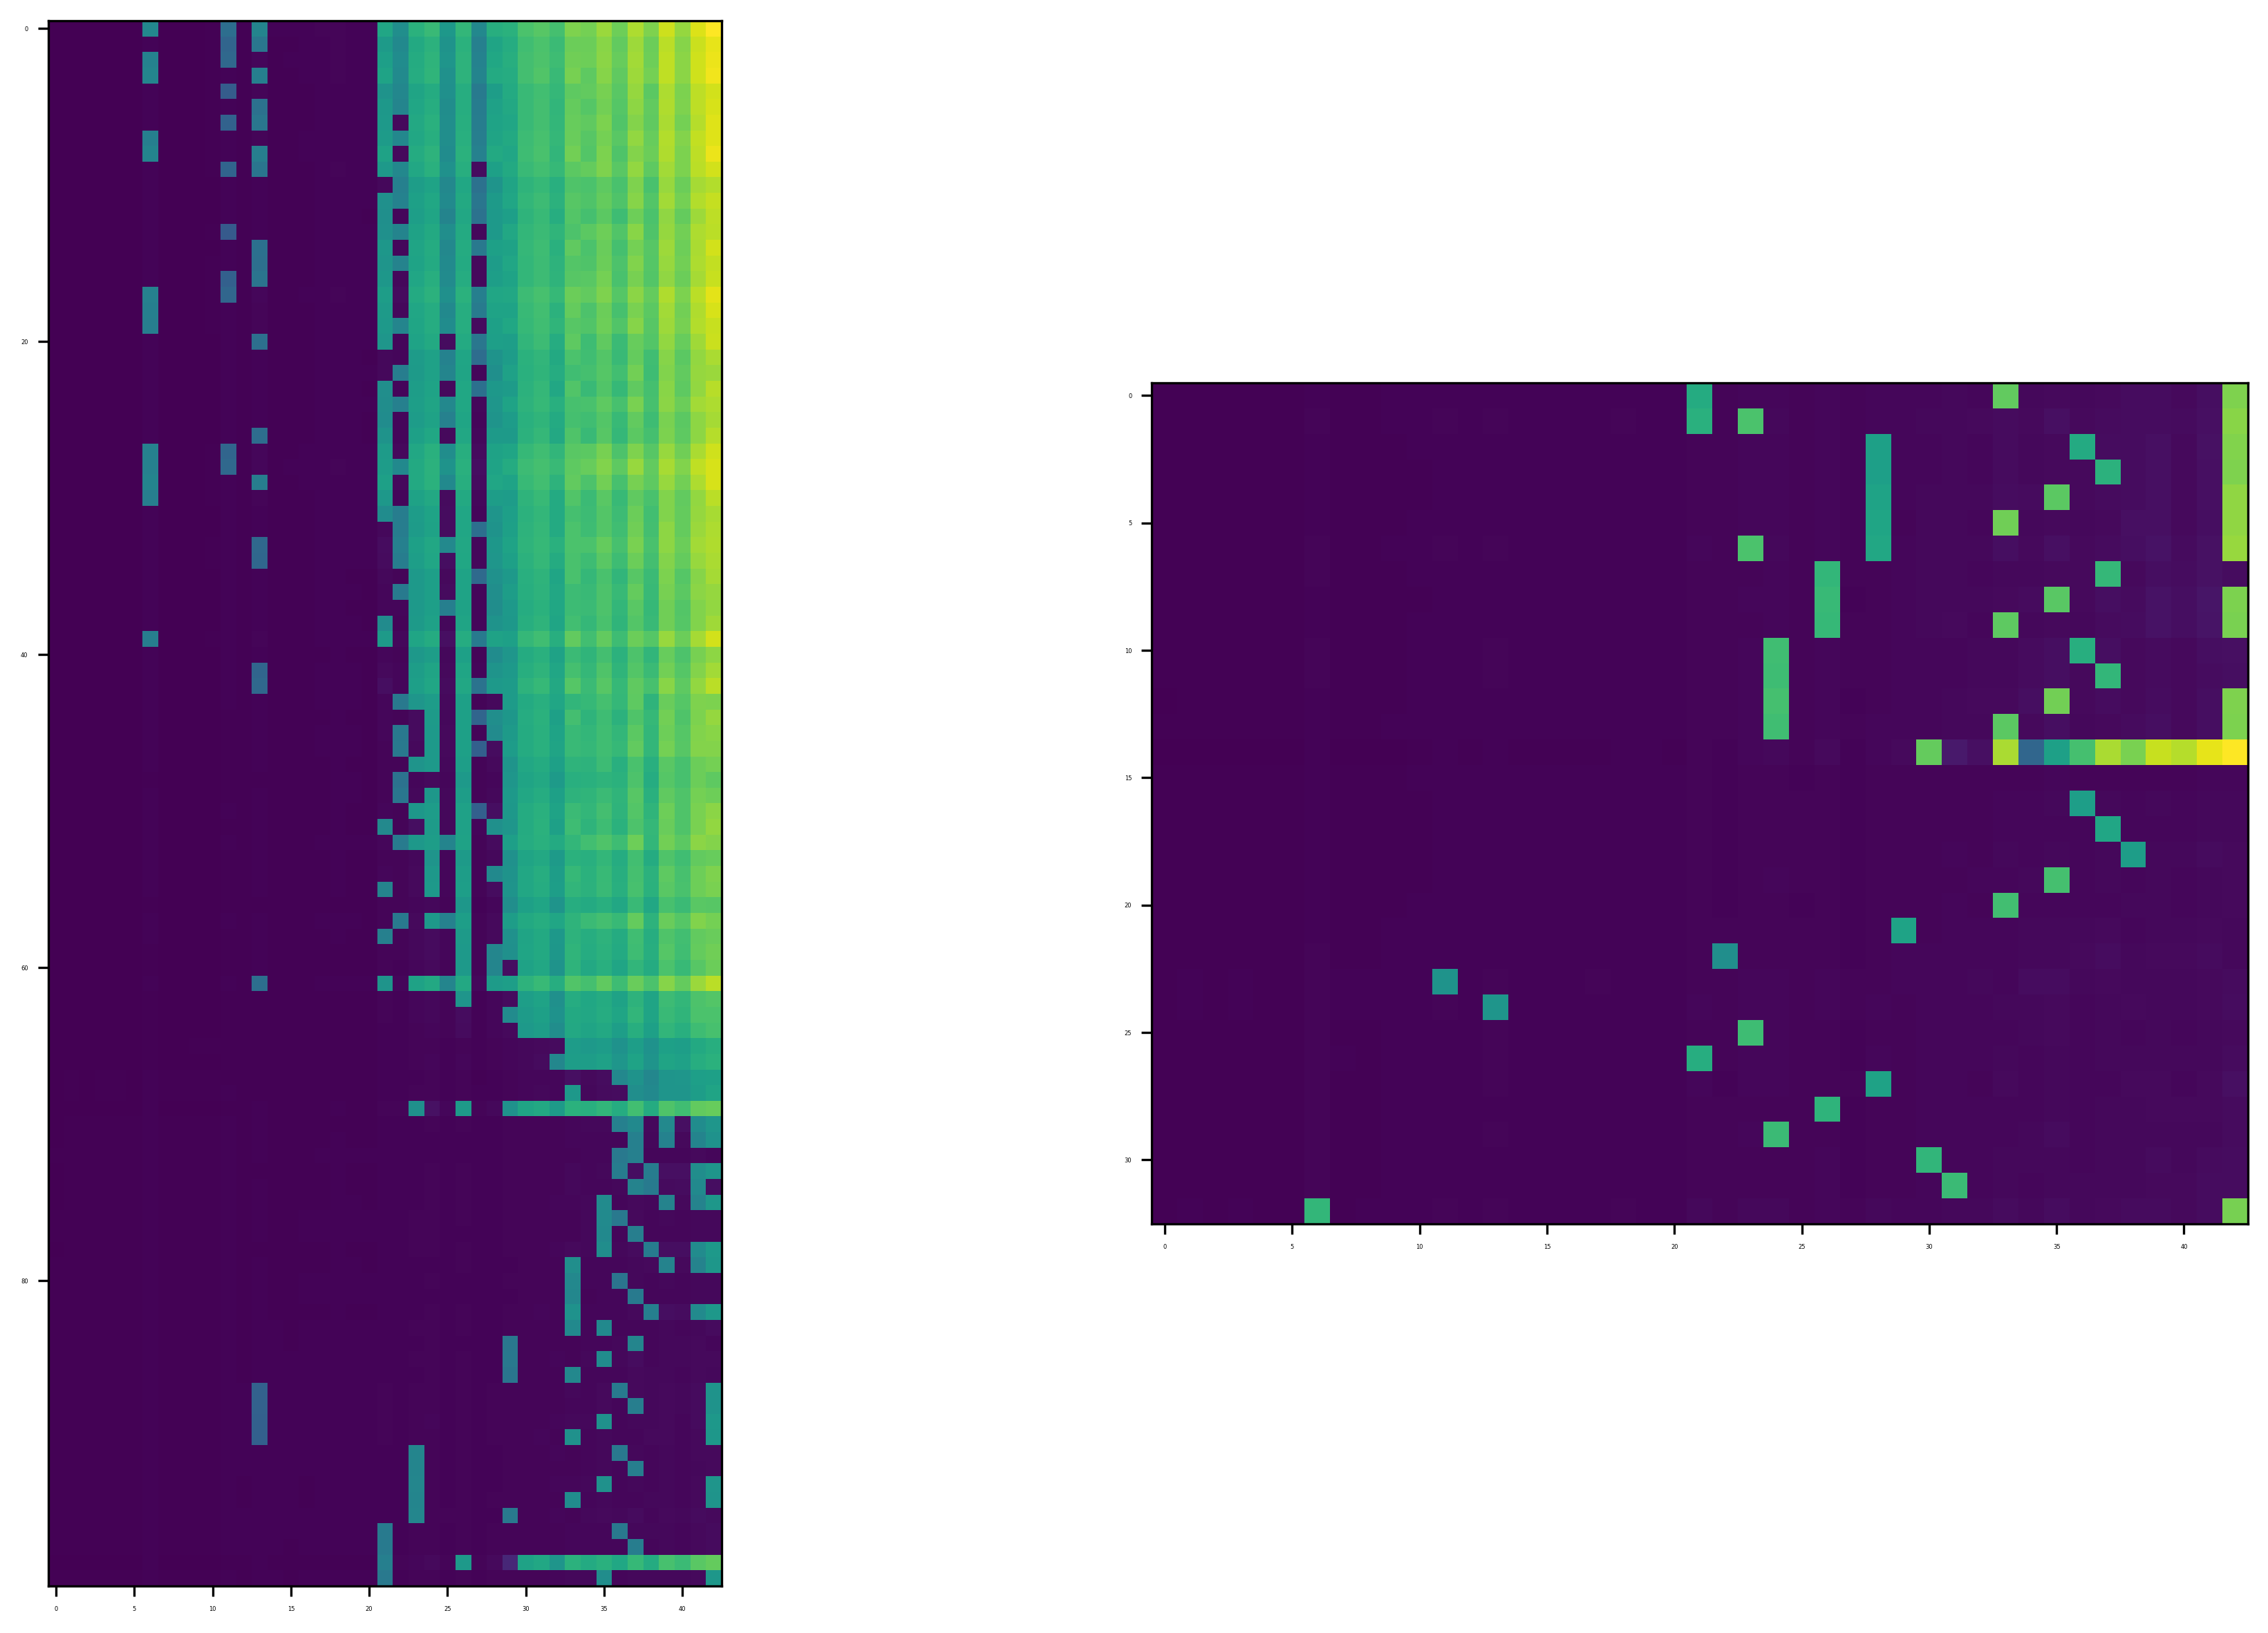

In [150]:
# plot all the attractors seperate into multiple panels. mm33
plotMultipleAttractorHeatmapLarge(attractmat, 100, hierarchy_df, (15,10), 2, False,  'processMulti/'+folderName+'_multAttHeatmap.svg')

In [151]:
# query the attractor with given properties.
nx, ny = attractmat.shape
print(nx, ny)
threshold = 5

result = []
for i in range(nx):
    curAtt = attractmat[i, :]
    noAreaAtt = np.sum(curAtt > threshold)
    frMOs = curAtt[area_list.index('MOs')]
    frAIv = curAtt[area_list.index('AIv')]
    frPM = curAtt[area_list.index('VISpm')]
#     frRSP = curAtt[area_list.index('RSPagl')]
#     print(noAreaAtt, frMOs, frAIv)
    if (noAreaAtt >= 2 and frMOs >= threshold) and frAIv <= threshold and frPM <=threshold:
        result.append([i, noAreaAtt, frMOs, frAIv])

133 43


In [152]:
# find the attractor with the MOS activated but not the AIv.
print(result[:10])
print(len(result))

# this is the attractor identified
targetAttractor = attractmat[491]  # attractmat[74] for 0444
# 491 for 0344   ['FRP', 'VISa', 'VISam', 'MOs', 'ACAd']
# 507 for 0344   ['VISpm', 'FRP', 'VISam', 'MOs', 'ACAd']
# 7905 for 0244 ['RSPagl', 'PERI', 'FRP', 'TEa', 'VISa', 'VISam', 'MOs', 'ACAd']
# 12469 for 0144  ['AUDv', 'VISC', 'GU', 'RSPagl', 'PERI', 'ILA', 'AId', 'FRP', 'TEa', 'VISa', 'VISam', 'MOs']


[[74, 3, 17.528363, 1.577096]]
1


IndexError: index 491 is out of bounds for axis 0 with size 133

In [153]:
# load input strength and cell type specific input strength.
with open('results/inputStr.json','r') as f:
    inputStr = np.array(json.load(f))
with open('results/inputStrHiermod.json','r') as f:
    inputStrHiermod = np.array(json.load(f))

In [154]:
def getXYCorr(X, Y, parameters, area_list, frThreshold):
    Ycopy = copy.copy(Y)
    Xnorm = X / X.max()
    Ynorm = Y / Y.max()
    Xnorm = Xnorm[Ycopy >= frThreshold]
    Ynorm = Ynorm[Ycopy >= frThreshold]
    r, pvalue = sp.stats.pearsonr(Xnorm, Ynorm)
    return r

In [155]:
X = inputStr
Xmod = inputStrHiermod
frThreshold= 5
corrList = []
corrModList = []
for i in range(attractmat.shape[0]):
    Y = attractmat[i,:]
    if sum(Y > frThreshold) >= 6: 
        corr = getXYCorr(X, Y, parameters, area_list, 5)
        corrMod = getXYCorr(Xmod, Y, parameters, area_list, 5)
        corrList.append(corr)
        corrModList.append(corrMod)
# print(corrList)
# print(corrModList)


In [156]:
def plotCorrList(corrList, xTicks, xlabel, ylabel, figSize, fontSize, saveFig, fileName):
    fig = plt.figure(figsize=figSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    x_pos = range(len(corrList))
    corrMean = [np.mean(x) for x in corrList]
    corrStd = [np.std(x) for x in corrList]
    plt.bar(x_pos, corrMean, yerr=corrStd)
    plt.xticks(x_pos, xTicks)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)
    return

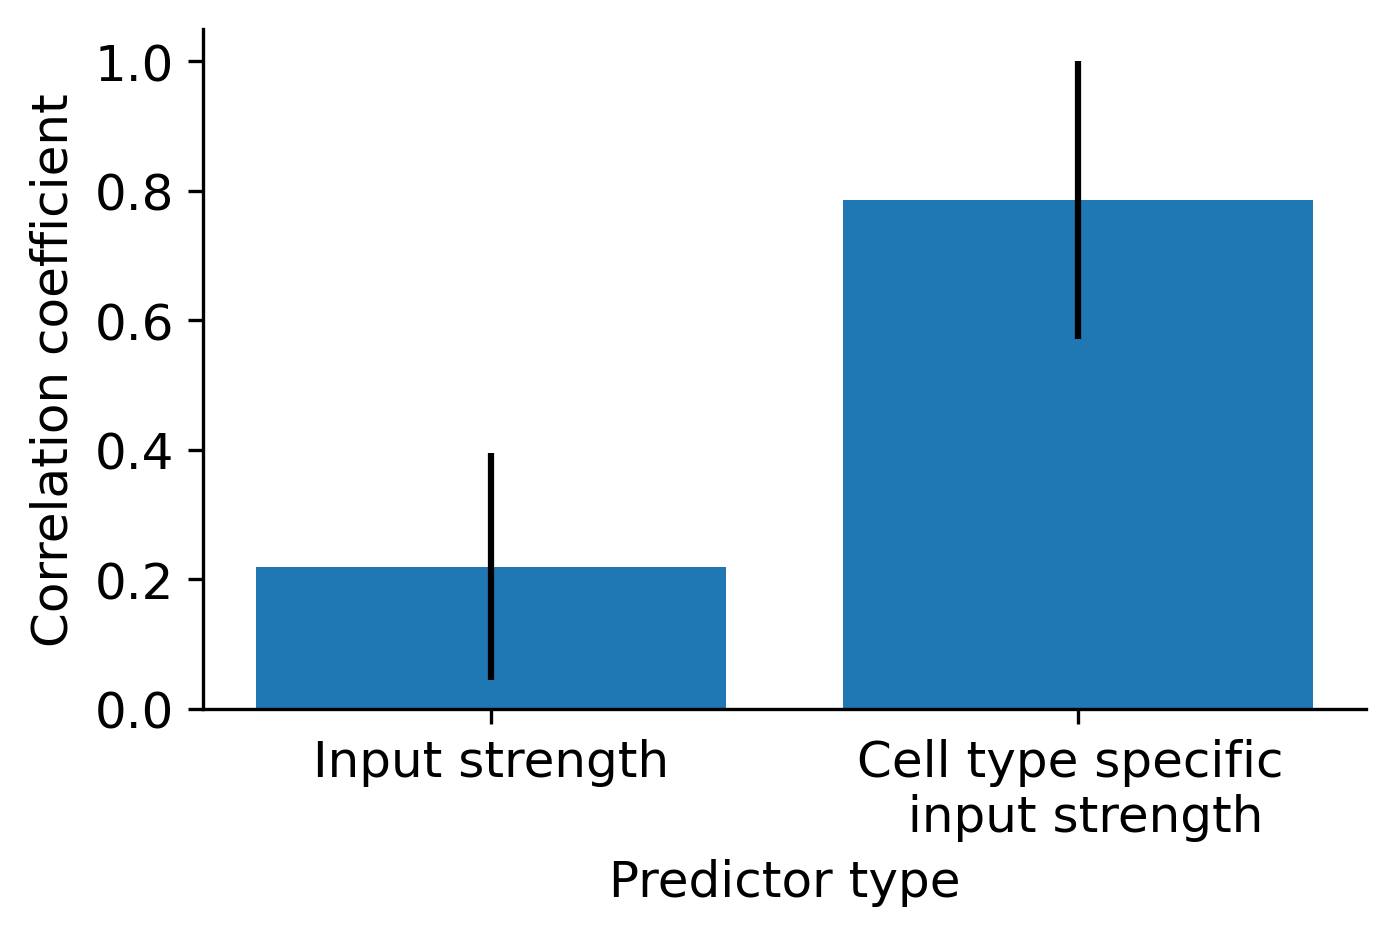

In [157]:
plotCorrList([corrList, corrModList], ['Input strength','Cell type specific \n input strength'],
             'Predictor type', 'Correlation coefficient', (5,3), 12, True,  'processMulti/'+folderName+'_inputCorr.svg')

In [93]:
# need to be deleted.
def generateColorMap(value, cmap, area_list):
    colorlist = []
    allstring = '{' 
    maxval = np.max(value)
    for i in range(len(area_list)):
        newstr = '"' + area_list[i] + '1":{},'.format(i + 1)
        allstring += newstr #allstring stores the names of all cortical areas 
        cval = value[i]
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        mycolor = list(cmap(norm(cval / maxval))[0:3])
        colorCode = [int(255*mycolor[0]), int(255*mycolor[1]), int(255*mycolor[2])]
        colorlist.append(colorCode)
    allstring = allstring[:-1] + '}'
    return allstring, colorlist

In [94]:
i = 32  # the index of stim pattern.
target = attractmat[i]
mapStr, FRcolorlist = generateColorMap(target, plt.cm.viridis, area_list)
print(mapStr)
print(FRcolorlist)
# generateColorbar(target, mpl.cm.viridis, 
#                  'Firing rate(Hz)', (0.25, 5), 12, False, 'processMulti/FRcolorbar_0.025_Att{}.svg'.format(i))

IndexError: index 32 is out of bounds for axis 0 with size 2

In [ ]:
with open('results/hierLoopStr.json','r') as f:
    loop_Hiermod = json.load(f)
with open('results/hierEigCent.json','r') as f:
    eigCentX = json.load(f)

In [95]:
# analaysis of attractor data.

In [358]:
# bar plot comparing the number of attractors for different settings.
def plotAttBar(noAttrac, yList, xLabel, figureSize, fontSize, saveFig, fileName):
    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    yData = noAttrac
    xData = range(len(yData))
    plt.bar(xData, yData)
    plt.xticks(xData, yList)
    plt.xlabel(xLabel)
    plt.ylabel('Number of attractors')
    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    if saveFig:
        fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)

In [368]:
# load data and plot attractor firing rate.  single area receive stimulation.
n_areas = len(area_list)

# nsize = 300
nsize = 1000
filepath = '.'
njobs = int(npattern/nsize) + 1

# folderList = ['resultsNov17_3', 'resultsNov17_2', 'resultsNov17_1', 'resultsNov17_0']
# folderList = ['results22Jul14_0240', 'results22Jul14_0241','results22Jul14_0242','results22Jul14_0243',
#              'results22Jul14_0244','results22Jul14_0245','results22Jul14_0246']
folderList = ['results22Jul15_0144', 'results22Jul15_0244', 'results22Jul15_0344', 'results22Jul15_0444', 
              'results22Jul15_0544']

noAtt = []
for folderName in folderList:
    pamat = np.zeros((n_areas, npattern))
    fullFolderName = filepath + '/tempdata/' + folderName

    for i in range(njobs):
        stimList = stimPatternList[i * nsize: (i + 1) * nsize]
        loadfilename = fullFolderName + '/att_' + str(i) + '_' + str(nsize) + '.txt'
        if Path(loadfilename).is_file():
            with open(loadfilename, 'r') as f:
                panew = json.load(f)
            pamat[:, i * nsize : (i + 1) * nsize] = np.array(panew).T
        else:
            print('error load file ' + loadfilename)
#     attractmat, n_attract, stimDict = getAttractors(pamat, 30)
    attractmat, n_attract, stimDict = getAttractorsBinary(pamat, 5)
    
    noAtt.append(n_attract)

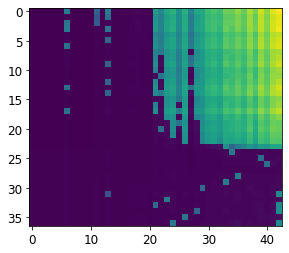

In [372]:
plt.imshow(attractmat)
print(attractmat)

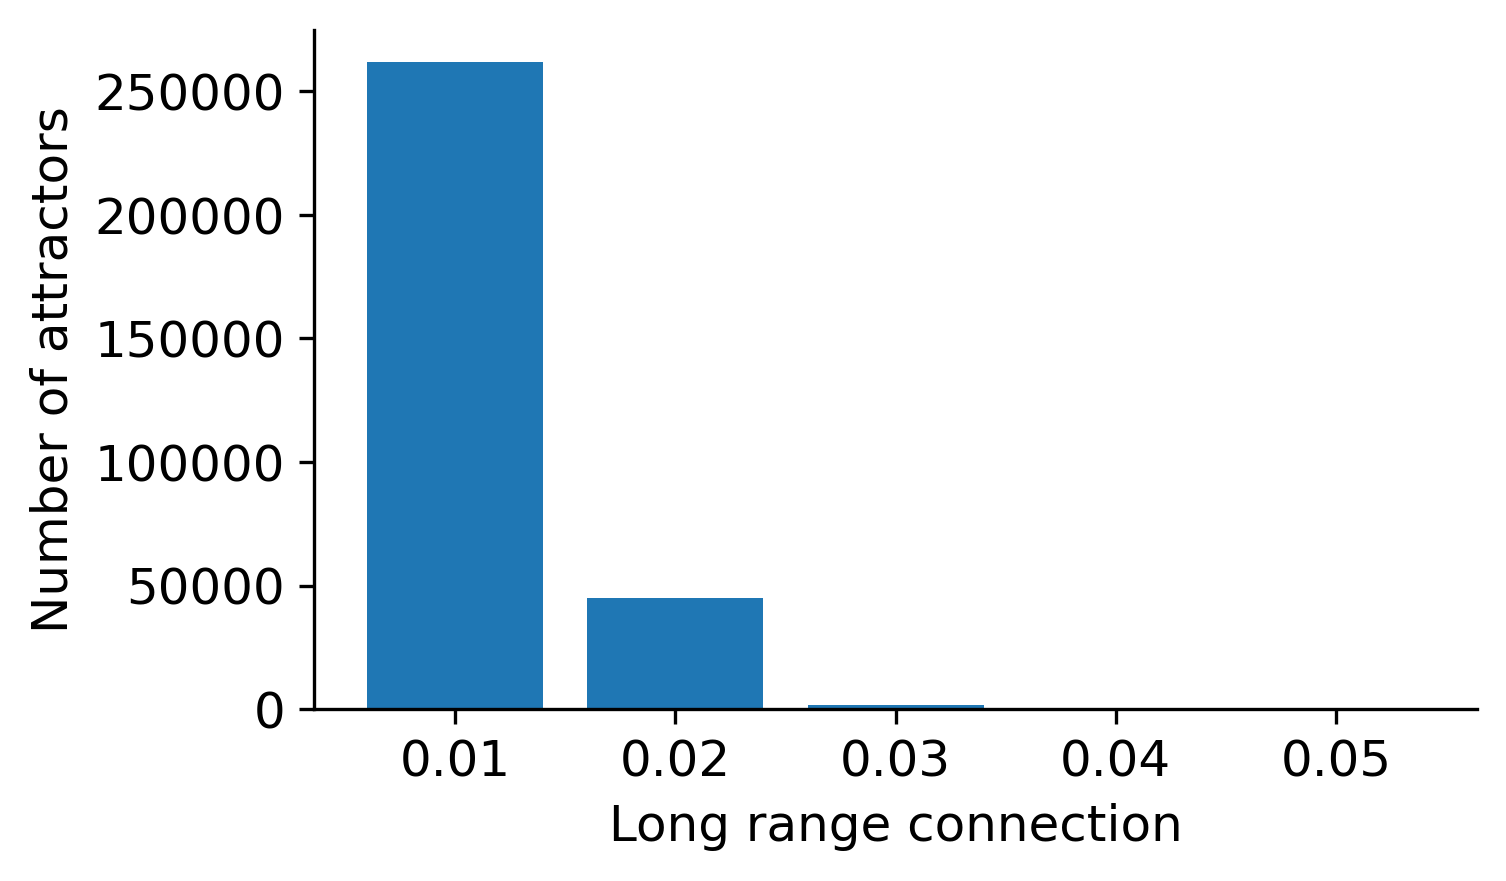

In [369]:
# paramList = [0.015, 0.02, 0.025, 0.03]
# paramList = [0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46]
paramList = [0.01, 0.02, 0.03, 0.04, 0.05]


# plotAttBar(noAtt[:5], paramList[:5], 'Local connection', (5,3), 12, True, 'processMulti/attractBarLocal.svg')
# plotAttBar(noAtt, paramList, 'Local connection', (5,3), 12, True, 'processMulti/attractBarLocalComplete.svg')
plotAttBar(noAtt, paramList, 'Long range connection', (5,3), 12, True, 'processMulti/attractBarLongrange.svg')

In [342]:
# load data and plot attractor firing rate.  single area receive stimulation.
n_areas = len(area_list)

nsize = 300
filepath = '.'
njobs = int(npattern/nsize) + 1

folderList = ['resultsNov18_1', 'resultsNov18_0', 'resultsNov17_1', 'resultsNov18_2']
paramList = [0.41, 0.43, 0.45, 0.47]
noAtt = []
for folderName in folderList:
    pamat = np.zeros((n_areas, npattern))
    fullFolderName = filepath + '/tempdata/' + folderName
#     with open(fullFolderName + '/allpars.pkl', 'rb') as file:  # open parameter file
#         [parameters, conn_cxcx, pref_matrix,
#          hierarchy_df, normPVgrad_df, normSSTgrad_df,
#          area_list, conn_thcx, conn_cxth, thal_list] = pickle.load(file)   
#     paramList.append(parameters['mu_EE'])

    for i in range(njobs):
        stimList = stimPatternList[i * nsize: (i + 1) * nsize]
        loadfilename = fullFolderName + '/att_' + str(i) + '_' + str(nsize) + '.txt'
        if Path(loadfilename).is_file():
            with open(loadfilename, 'r') as f:
                panew = json.load(f)
            pamat[:, i * nsize : (i + 1) * nsize] = np.array(panew).T
        else:
            print('error load file ' + loadfilename)

    attractmat, n_attract, stimDict = getAttractors(pamat, 30)

    noAtt.append(n_attract)



error load file ./tempdata/resultsNov18_1/att_82_300.txt
error load file ./tempdata/resultsNov18_1/att_83_300.txt
error load file ./tempdata/resultsNov18_1/att_216_300.txt
error load file ./tempdata/resultsNov18_1/att_217_300.txt
error load file ./tempdata/resultsNov18_1/att_222_300.txt
error load file ./tempdata/resultsNov18_1/att_229_300.txt
error load file ./tempdata/resultsNov18_1/att_238_300.txt
error load file ./tempdata/resultsNov18_1/att_240_300.txt
error load file ./tempdata/resultsNov18_1/att_312_300.txt
error load file ./tempdata/resultsNov18_1/att_313_300.txt
error load file ./tempdata/resultsNov18_1/att_314_300.txt
error load file ./tempdata/resultsNov18_1/att_315_300.txt
error load file ./tempdata/resultsNov18_1/att_316_300.txt
error load file ./tempdata/resultsNov18_1/att_318_300.txt
error load file ./tempdata/resultsNov18_1/att_320_300.txt
error load file ./tempdata/resultsNov18_1/att_321_300.txt
error load file ./tempdata/resultsNov18_1/att_324_300.txt
error load file 

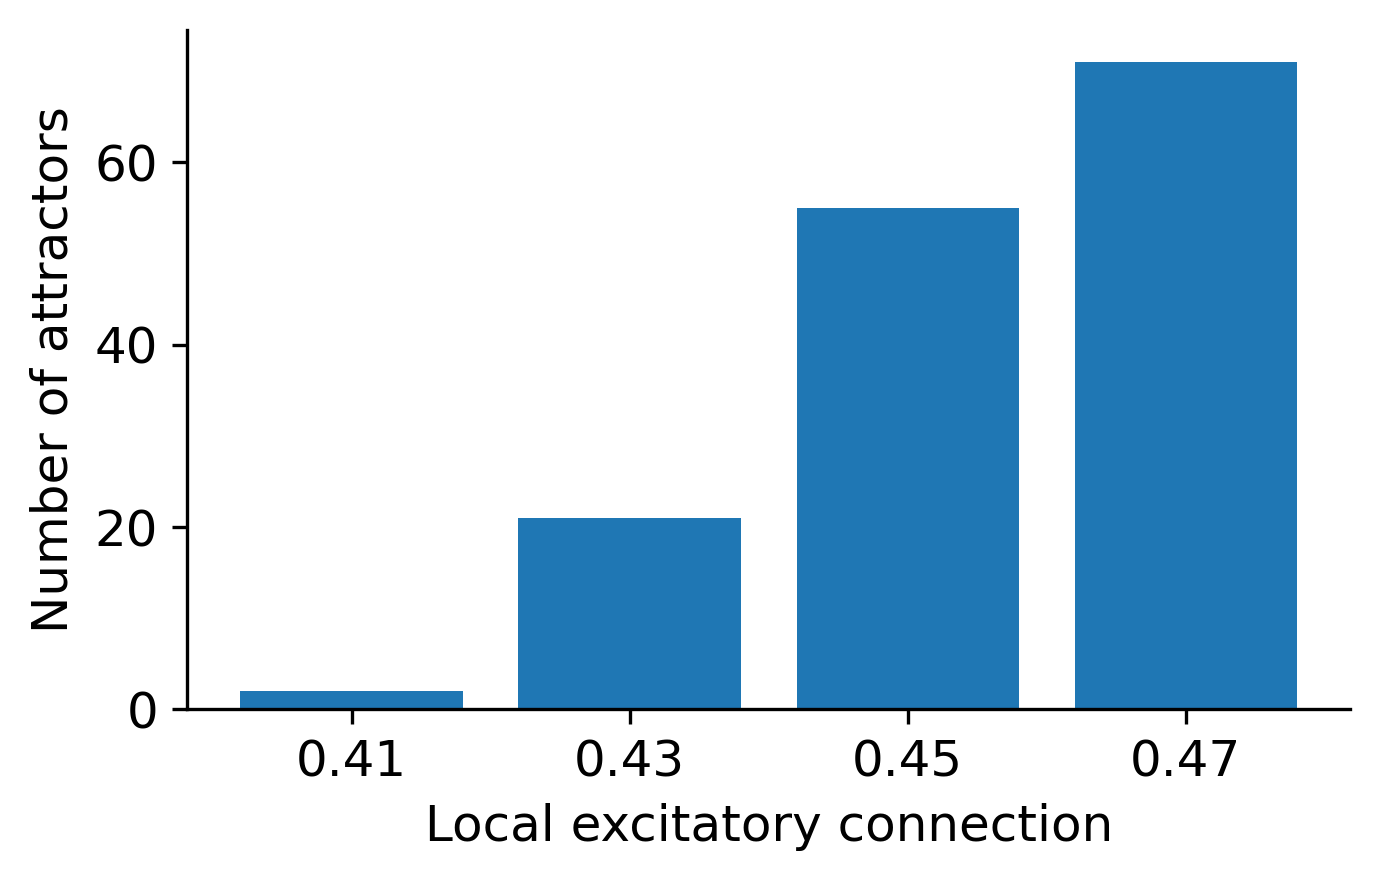

In [346]:
plotAttBar(noAtt, paramList, 'Local excitatory connection', (5,3), 12, True, 'processMulti/attractBar2.svg')

In [309]:
# muEElist = [0.025, 0.03, 0.35, 0.04, 0.05]
# noAtt = [242-1, 67-1, 21-1, 6-1, 4-1] # not including the baseline attractor.
# plotAttBar(noAtt, muEElist, (5,3), 12, False, 'processMulti/attractBar.svg')

In [27]:
stimDict[3]
stimPatternList[155432]

['AIp', 'PERI', 'FRP', 'PL', 'ECT', 'GU', 'ILA', 'TEa', 'AIv', 'ACAv']

In [ ]:
def getsNMDA(sNMDAmat, thresholdDif):
    attractmat = []
    stimDict = defaultdict(list)

    for i in range(pamat.shape[1]):
        panew = pamat[:, i]
    #     print(panew)
        n_attract = len(attractmat)
        YNnewattract =[False for k in range(n_attract)]
        if n_attract == 0:
            attractmat.append(panew)
        else:
            for j in range(n_attract):
                if np.linalg.norm(attractmat[j] - panew) > thresholdDif:
            #             print(np.linalg.norm(attractmat[:,j] - panew))
                    YNnewattract[j] = True
                else:
                    stimDict[j].append(i)
                if all(YNnewattract) == True:
                    attractmat.append(panew)
    n_attract = len(attractmat)
    attractmat = np.array(attractmat)
    return attractmat, n_attract, stimDict